## New York State External Appeal Data From 2019-2022


We investigate the New York State (NYS) database of external appeal decisions maintained by the NYS Department of Financial Services (DFS).

At the time of writing, the database is hosted at: https://www.dfs.ny.gov/public-appeal/search.


### Setup


In [4]:
import os
import re
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


pd.set_option("display.max_columns", None)
sys.path.append("../..")

from src.utils.data.claims_denials import (
    get_overturn_rate,
    get_overturn_rates_by_categorical_col,
)
from src.utils.download import download_file_from_url
from src.utils.plot import plot_bar, plot_pie, heatmap_from_df_cols

INPUT_DATA_DIR = "./input_data"
OUTPUT_IMAGE_DIR = "./images/nys_external"
OUTPUT_DATA_DIR = "./output_data/nys_external"  # Set to None if you don't want to save non-required data for external use
NO_PLOT_TITLES = False  # If True, plots have no titles. Useful for cases where one wants titles rendered separately from underlying plots.

In [5]:
os.makedirs(INPUT_DATA_DIR, exist_ok=True)
if OUTPUT_IMAGE_DIR:
    os.makedirs(OUTPUT_IMAGE_DIR, exist_ok=True)
if OUTPUT_DATA_DIR:
    os.makedirs(OUTPUT_DATA_DIR, exist_ok=True)

### Download Raw Data


In [6]:
# URL obtained by clicking "Export" here: https://www.dfs.ny.gov/public-appeal/search
url = "https://myportal.dfs.ny.gov/o/peasa/peasaserviceexcel"
appeal_data_path = os.path.join(INPUT_DATA_DIR, "nys_external_appeal_outcomes.xlsx")
download_file_from_url(url, appeal_data_path)

Success.


### Read and Clean Data


In [8]:
df = pd.read_excel(appeal_data_path)

# Remove single 2002 record, as it appears to be accidentally included, or a typo on date
df = df[df["Decision Year"] != 2002]

# Standardize agent names
df["Agent"] = df["Agent"].apply(
    lambda x: "MCMC" if x == "MCMC Services, L.L.C." or x == "MCMC, LLC" else x
)

# Remove 2024 records, since claims are still being adjudicated, there are pending internal appeals, etc.
# Yields view of statistics that is inconsistent with methodology for complete years
df = df[df["Decision Year"] != 2024]

/home/mike/envs/investigations_venv/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [9]:
print(f"This dataset contains a total of {len(df)} external appeals from NY.")
for year, count in df["Decision Year"].value_counts().items():
    print(f"\t{count} external appeals from {year}")

This dataset contains a total of 33259 external appeals from NY.
	8529 external appeals from 2023
	8244 external appeals from 2022
	6540 external appeals from 2021
	5816 external appeals from 2020
	4130 external appeals from 2019


**Question**: What is the total population of _initial claims_, _initially denied claims_, and _internally appealed claims_ for each insurer/year combination documented in this external appeal database? These denominators are crucial for drawing certain conclusions from this data. Can the corresponding total pools of claims for some (or all) of the insurers documented here be extracted from existing CMS public use files?

The only places these sorts of figures partially exist, of which I am aware, are:

- NY Consumer guides (exist historically, detail appeal numbers, but not base denial numbers!)
  - e.g. https://www.dfs.ny.gov/system/files/documents/2021/08/ny_consumer_guide_health_insurers_2021.pdf
- NY claim reports (starting 2022)
  - e.g. https://www.dfs.ny.gov/reports_and_publications/health_care_claim_reports


### Helper Functions


In [10]:
def get_overturn_rates_by_category(
    df: pd.DataFrame, cat_col: str, by_year: bool = False
) -> dict:
    """Given a column in df, specified by cat_col, break down appeal decision outcomes split on distinct values in the column."""
    decision_data = {}
    for val in df[cat_col].unique():
        decision_data[val] = {}
        rel_df = df[df[cat_col] == val]
        overturn_counts = rel_df["Appeal Decision"].value_counts()
        decision_data[val]["overall"] = {}
        overturned = overturn_counts.get("Overturned", None)
        decision_data[val]["overall"]["upheld"] = overturn_counts.get("Upheld", None)
        decision_data[val]["overall"]["completely_overturned"] = overturned
        decision_data[val]["overall"]["partially_overturned"] = overturn_counts.get(
            "Overturned in Part", None
        )
        decision_data[val]["overall"]["complete_overturn_rate"] = (
            overturned / overturn_counts.values.sum() if overturned else None
        )

        if by_year:
            for year in rel_df["Decision Year"].unique():
                decision_data[val][year] = {}
                sub_df = rel_df[rel_df["Decision Year"] == year]
                overturn_counts = sub_df["Appeal Decision"].value_counts()
                overturned = overturn_counts.get("Overturned", None)
                decision_data[val][year]["upheld"] = overturn_counts.get("Upheld", None)
                decision_data[val][year]["completely_overturned"] = overturned
                decision_data[val][year]["partially_overturned"] = overturn_counts.get(
                    "Overturned in Part", None
                )
                decision_data[val][year]["complete_overturn_rate"] = (
                    overturned / overturn_counts.values.sum() if overturned else None
                )
    return decision_data

### High Level Stats


In [11]:
def print_appeal_results(appeal_decision_counts):
    bar_names, bar_vals = (
        list(appeal_decision_counts.index),
        appeal_decision_counts.values,
    )
    print(bar_names)
    print(
        f"{int(100* (round(bar_vals[0]/ bar_vals.sum(), 2)))}% of all original determinations in external appeals were upheld"
    )
    print(
        f"{int(100* (round(bar_vals[1]/ bar_vals.sum(), 2)))}% of all original determinations in external appeals were completely overturned."
    )
    print(
        f"{int(100* (round(bar_vals[2]/ bar_vals.sum(), 2)))}% of all original determinations in external appeals were partially overturned."
    )
    return None

In [12]:
appeal_decision_counts = df["Appeal Decision"].value_counts()
print_appeal_results(appeal_decision_counts)

['Upheld', 'Overturned', 'Overturned in Part']
55% of all original determinations in external appeals were upheld
43% of all original determinations in external appeals were completely overturned.
2% of all original determinations in external appeals were partially overturned.


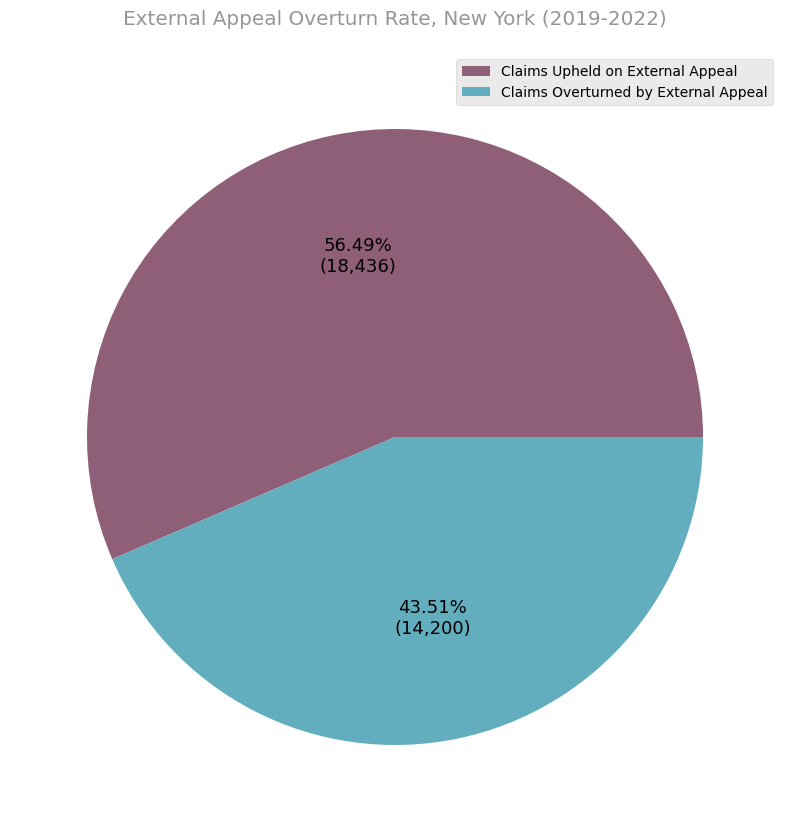

In [13]:
claims_externally_appealed = (
    appeal_decision_counts["Upheld"] + appeal_decision_counts["Overturned"]
)
claims_externally_overturned = appeal_decision_counts["Overturned"]
external_appeals_upheld = claims_externally_appealed - claims_externally_overturned
plot_pie(
    slice_names=[
        "Claims Upheld on External Appeal",
        "Claims Overturned by External Appeal",
    ],
    slice_vals=[external_appeals_upheld, claims_externally_overturned],
    title="External Appeal Overturn Rate, New York (2019-2022)"
    if not NO_PLOT_TITLES
    else None,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "external_appeal_success_rates.png"),
    show=True,
)

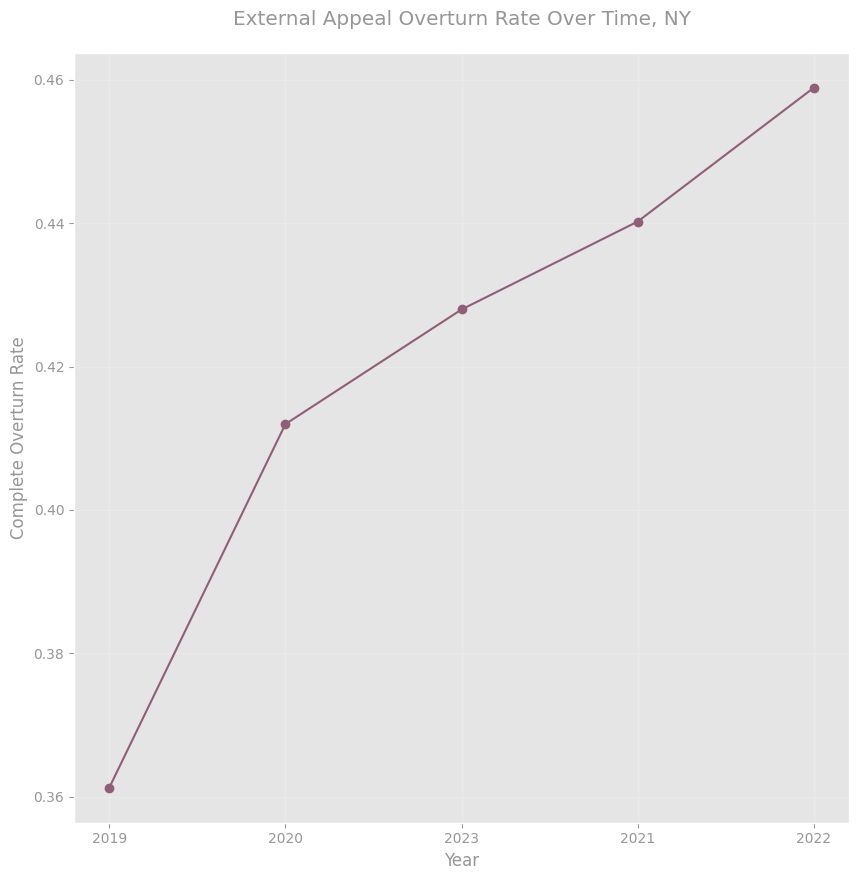

In [14]:
# Plot overall decision rates by year
decision_data = get_overturn_rates_by_category(df, "Decision Year")
fig, ax = plt.subplots(figsize=(10, 10))
x = list(df["Decision Year"].unique())
if not NO_PLOT_TITLES:
    ax.set_title("External Appeal Overturn Rate Over Time, NY")
ax.set_ylabel("Complete Overturn Rate")
ax.set_xlabel("Year")
timeseries = []
for year in x:
    if decision_data.get(year, None):
        timeseries.append(decision_data[year]["overall"]["complete_overturn_rate"])
    else:
        timeseries.append(None)
dates = np.asarray(x).astype(str)
ax.plot(dates, timeseries, "o-")
save_path = os.path.join(OUTPUT_IMAGE_DIR, "external_appeal_overturn_rates_by_year.png")
plt.savefig(save_path, transparent=True, bbox_inches="tight")
plt.show()

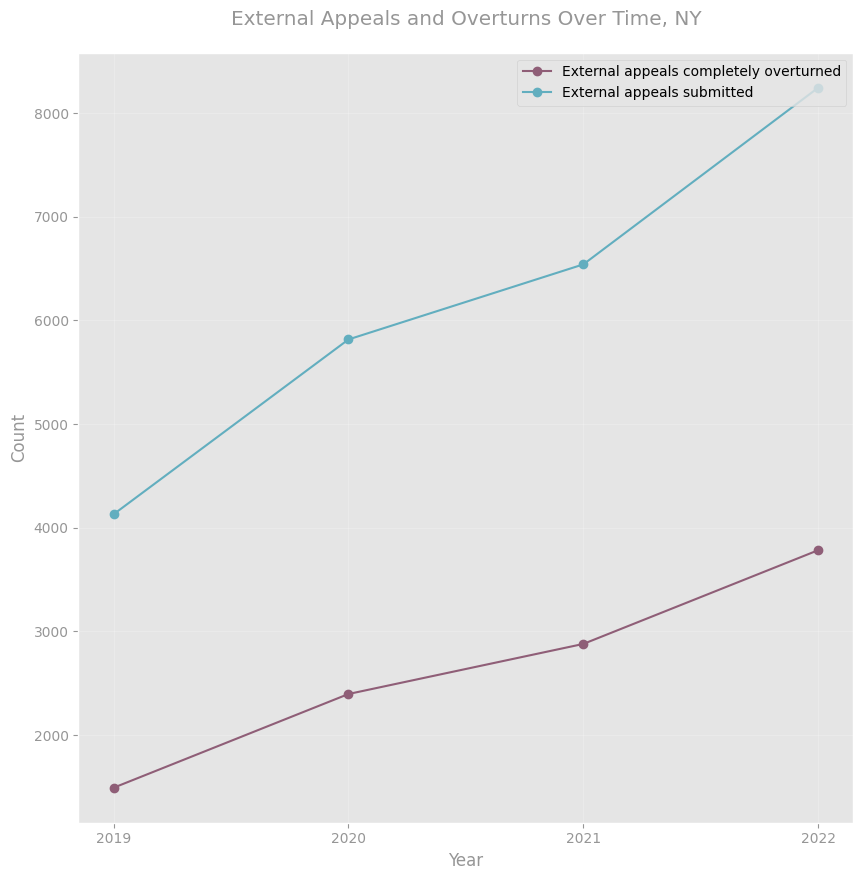

In [11]:
# Plot complete overturns and number of external appeals over same time period, to see what's affecting rate
fig, ax = plt.subplots(figsize=(10, 10))
x = list(df["Decision Year"].unique())
if not NO_PLOT_TITLES:
    ax.set_title("External Appeals and Overturns Over Time, NY")
ax.set_ylabel("Count")
ax.set_xlabel("Year")
appeals_timeseries = []
overturns_timeseries = []
for year in x:
    if decision_data.get(year, None):
        year_data = decision_data[year]["overall"]
        appeals_timeseries.append(
            year_data["completely_overturned"]
            + year_data["partially_overturned"]
            + year_data["upheld"]
        )
        overturns_timeseries.append(year_data["completely_overturned"])
    else:
        appeals_timeseries.append(None)
        overturns_timeseries.append(None)
dates = np.asarray(x).astype(str)
ax.plot(
    dates, overturns_timeseries, "o-", label="External appeals completely overturned"
)
ax.plot(dates, appeals_timeseries, "o-", label="External appeals submitted")
ax.legend(labelcolor="black")
save_path = os.path.join(OUTPUT_IMAGE_DIR, "external_appeals_by_year.png")
plt.savefig(save_path, transparent=True, bbox_inches="tight")
plt.show()

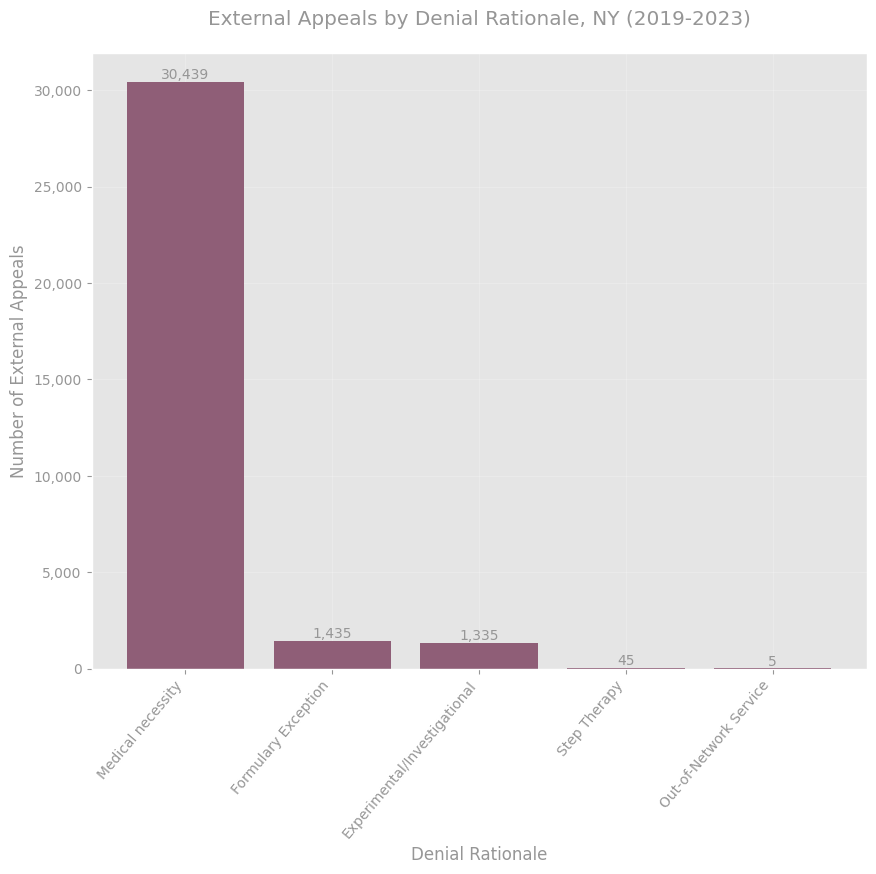

In [16]:
# Breakdown Appeals by Initial Denial Rationale
title = "External Appeals by Denial Rationale, NY (2019-2023)"
val_axis_label = "Number of External Appeals"
cat_axis_label = "Denial Rationale"
denial_val_counts = df["Denial Reason"].value_counts()
bar_names, bar_vals = list(denial_val_counts.index), denial_val_counts.values
plot_bar(
    bar_names,
    bar_vals,
    title=title if not NO_PLOT_TITLES else None,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    bar_label=True,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "external_appeals_by_denial_reason.png"),
    figsize=(10, 8),
)

In [17]:
def get_subgrp_rates(subgrp):
    d = {}
    d["overturn_rate"] = (subgrp["Appeal Decision"] == "Overturned").sum() / len(subgrp)
    d["external_appeals"] = len(subgrp)
    return pd.Series(d, index=["overturn_rate", "external_appeals"])


insurer_groups = df.groupby("Health Plan").apply(get_subgrp_rates).reset_index()
insurer_groups = insurer_groups.sort_values("external_appeals", ascending=False)

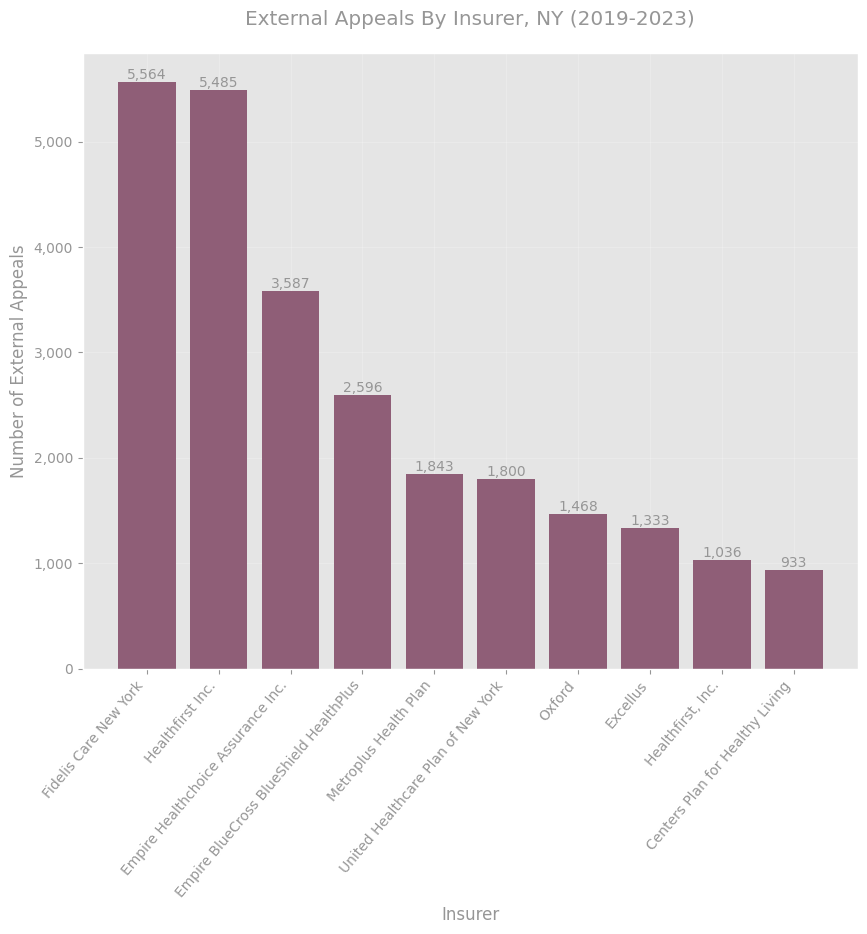

In [18]:
# Breakdown Appeals by Insurer/Issuer
title = "External Appeals By Insurer, NY (2019-2023)"
val_axis_label = "Number of External Appeals"
cat_axis_label = "Insurer"
bar_vals = insurer_groups["external_appeals"].values[:10]
bar_names = insurer_groups["Health Plan"].values[:10]
plot_bar(
    bar_names,
    bar_vals,
    title=title if not NO_PLOT_TITLES else None,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "external_appeals_top_insurers.png"),
    bar_label=True,
    int_vals=True,
    htick_rotation=50,
    figsize=(10, 8),
)

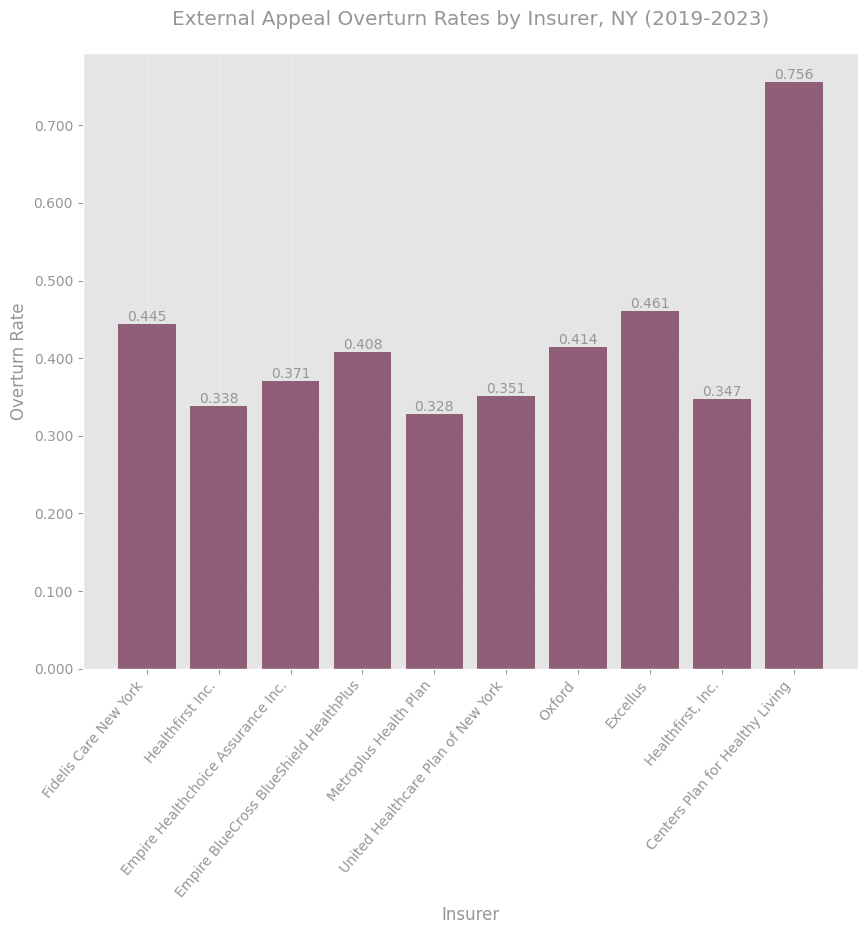

In [19]:
title = "External Appeal Overturn Rates by Insurer, NY (2019-2023)"
val_axis_label = "Overturn Rate"
cat_axis_label = "Insurer"
bar_vals = insurer_groups["overturn_rate"].values[:10]
bar_names = insurer_groups["Health Plan"].values[:10]
plot_bar(
    bar_names,
    bar_vals,
    title=title if not NO_PLOT_TITLES else None,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "overturn_rates_by_insurer.png"),
    bar_label=True,
    int_vals=False,
    htick_rotation=50,
    figsize=(10, 8),
)

**Question** As before, it'd be interesting and useful to know the relevant population counts here. E.g., external appeals for denials due to medical necessity dominate
this dataset, so we'd like to know: what is the distribution of denial rationales (for denials externally appealed, or not) among the insurers and years represented in this data?
Is this distribution of denial reasons among external appeals just following that initial denial distribution, or is there more to it than that? For example, it could be the case that consumers are more likely to externally
appeal medical necessity denials, all else equal. Or it could be the case that consumers are equally likely to appeal decisions in any category, all else equal, but insurers are more likely to overturn decisions on internal appeals
in categories other than medical necessity, leading to a higher than otherwise expected weight to the medical necessity external appeals in this data. These questions are unfortunately unanswerable from this data alone.


#### Agent Breakdowns


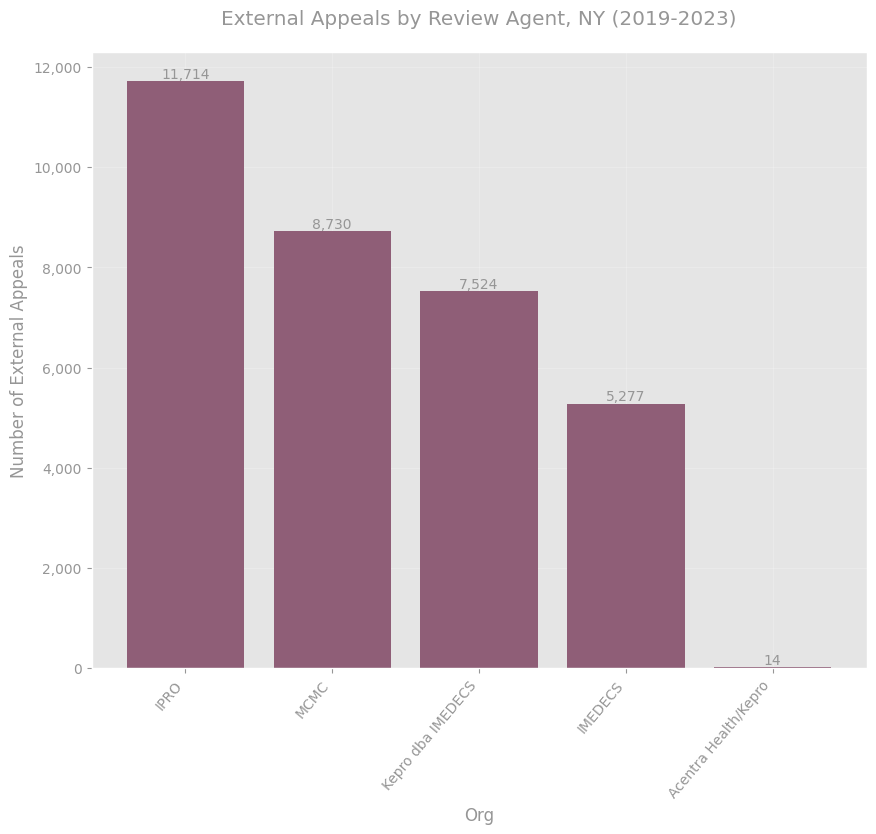

In [20]:
# Agent breakdowns
title = "External Appeals by Review Agent, NY (2019-2023)"
val_axis_label = "Number of External Appeals"
cat_axis_label = "Org"
agent_val_counts = df["Agent"].value_counts()
bar_names, bar_vals = list(agent_val_counts.index), agent_val_counts.values
plot_bar(
    bar_names,
    bar_vals,
    title=title if not NO_PLOT_TITLES else None,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "external_appeals_by_agent.png"),
    bar_label=True,
    figsize=(10, 8),
)

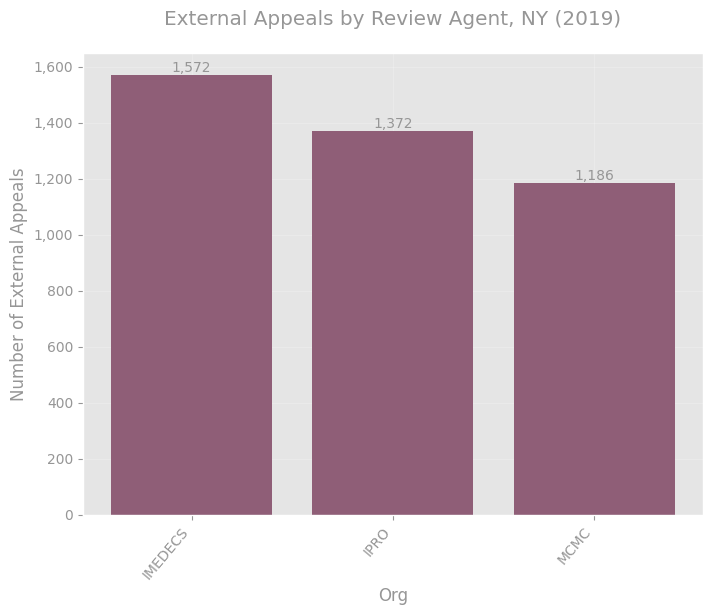

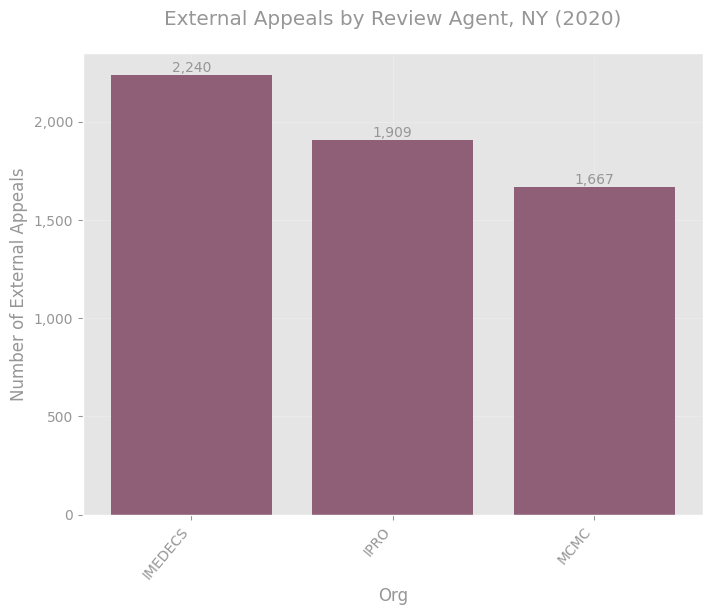

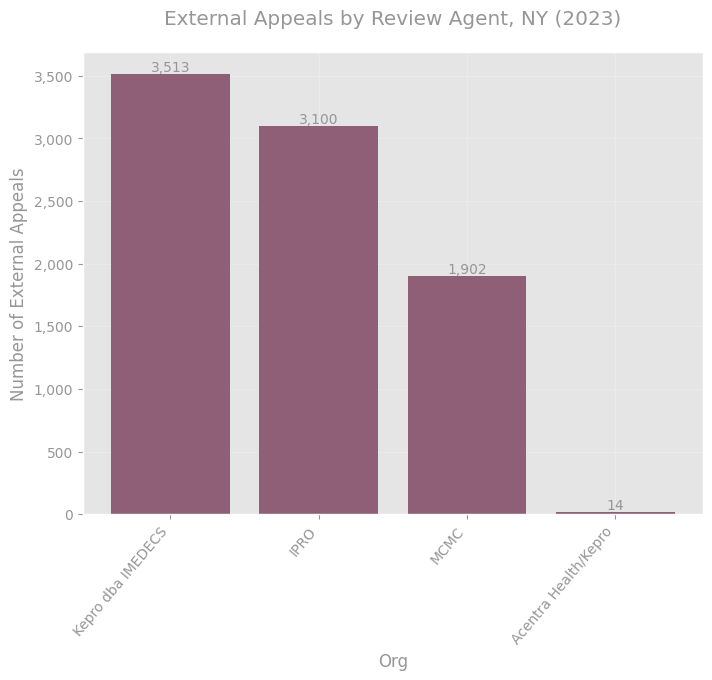

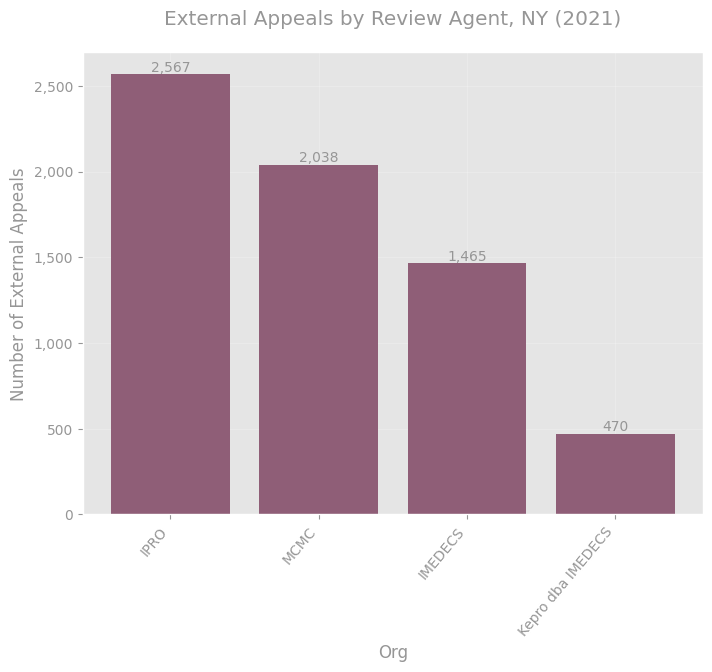

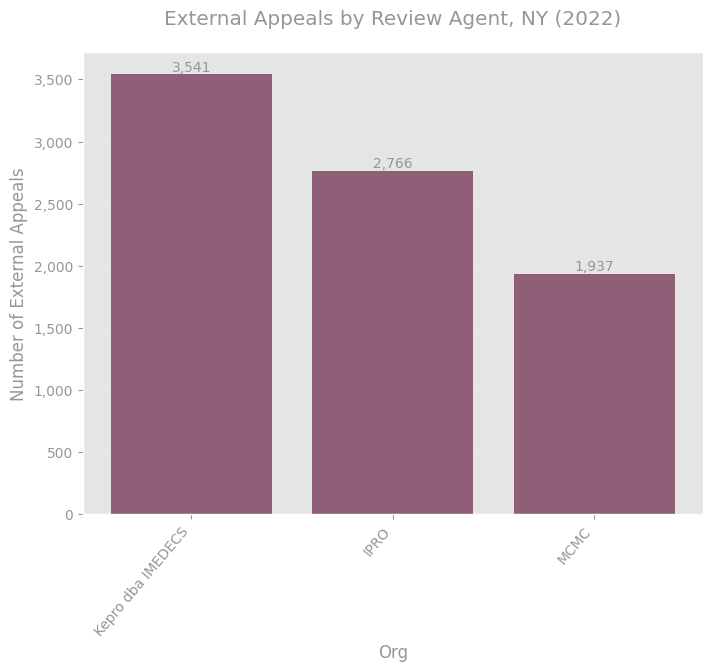

In [21]:
# Agent breakdowns by year
for year in df["Decision Year"].unique():
    rel_df = df[df["Decision Year"] == year]
    agent_val_counts = rel_df["Agent"].value_counts()
    title = f"External Appeals by Review Agent, NY ({year})"
    val_axis_label = "Number of External Appeals"
    cat_axis_label = "Org"
    bar_names, bar_vals = list(agent_val_counts.index), agent_val_counts.values
    plot_bar(
        bar_names,
        bar_vals,
        title=title if not NO_PLOT_TITLES else None,
        val_axis_label=val_axis_label,
        cat_axis_label=cat_axis_label,
        save_path=os.path.join(
            OUTPUT_IMAGE_DIR, f"external_appeals_by_agent_{year}.png"
        ),
        bar_label=True,
        figsize=(8, 6),
    )

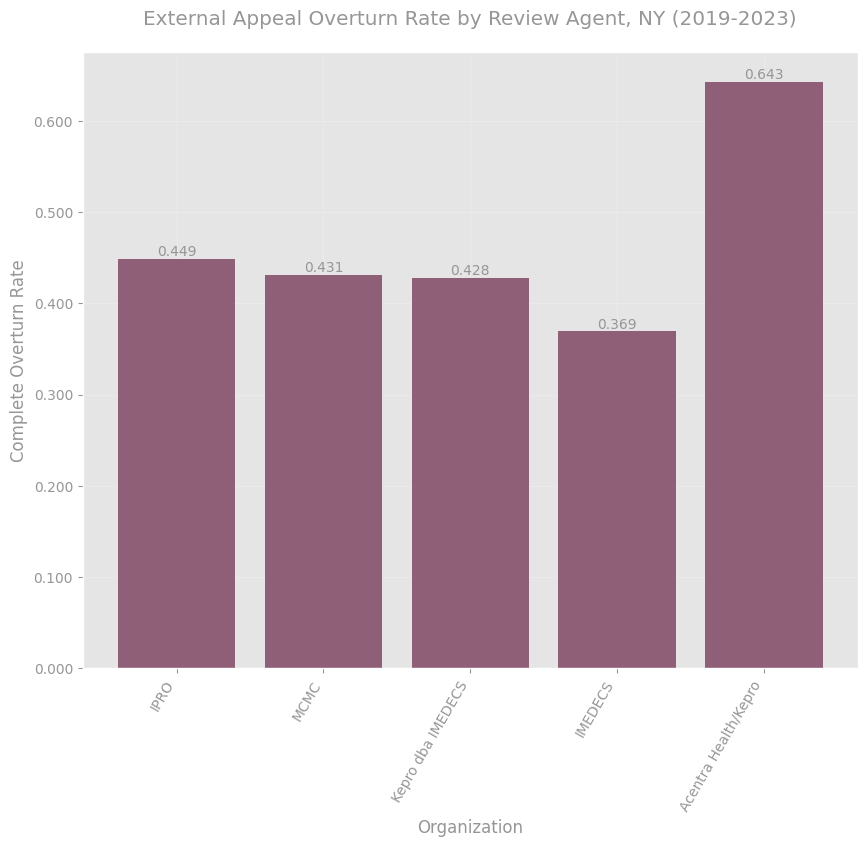

In [25]:
# Agent breakdowns overturn rates (averaged over years)


def get_subgrp_rates(subgrp):
    d = {}
    d["overturn_rate"] = (subgrp["Appeal Decision"] == "Overturned").sum() / len(subgrp)
    d["external_appeals"] = len(subgrp)
    return pd.Series(d, index=["overturn_rate", "external_appeals"])


agent_groups = df.groupby("Agent").apply(get_subgrp_rates).reset_index()
agent_groups = agent_groups.sort_values("external_appeals", ascending=False)

bar_names, bar_vals = agent_groups["Agent"].values, agent_groups["overturn_rate"].values

title = "External Appeal Overturn Rate by Review Agent, NY (2019-2023)"
val_axis_label = "Complete Overturn Rate"
cat_axis_label = "Organization"
plot_bar(
    bar_names,
    bar_vals,
    title=title if not NO_PLOT_TITLES else None,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(
        OUTPUT_IMAGE_DIR, "external_appeal_overturn_rates_by_agent.png"
    ),
    bar_label=True,
    int_vals=False,
    htick_rotation=60,
    figsize=(10, 8),
)

In [26]:
agent_decision_data = get_overturn_rates_by_category(df, cat_col="Agent", by_year=True)

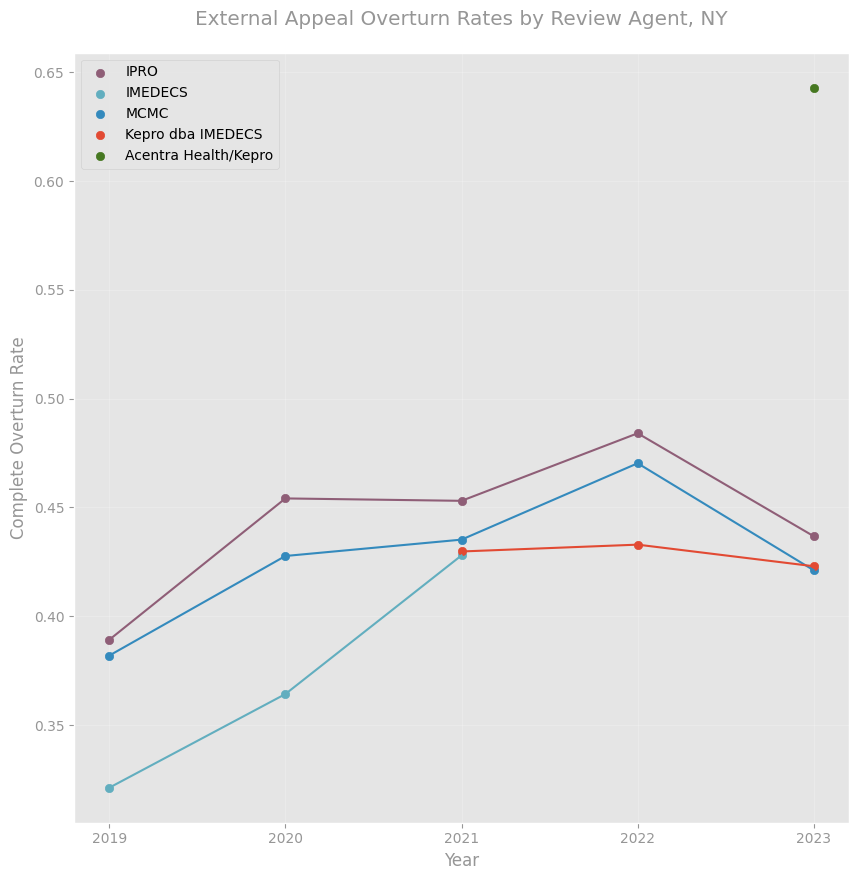

In [31]:
# Plot agent decision rates over time
fig, ax = plt.subplots(figsize=(10, 10))
x = sorted(list(df["Decision Year"].unique()))
if not NO_PLOT_TITLES:
    ax.set_title("External Appeal Overturn Rates by Review Agent, NY")
ax.set_ylabel("Complete Overturn Rate")
ax.set_xlabel("Year")
dates = np.asarray(x).astype(str)
for agent in agent_decision_data:
    agent_timeseries = []
    for year in x:
        if agent_decision_data[agent].get(year, None):
            agent_timeseries.append(
                agent_decision_data[agent][year]["complete_overturn_rate"]
            )
        else:
            agent_timeseries.append(None)
    ax.scatter(dates, agent_timeseries, label=agent)
    ax.plot(dates, agent_timeseries)
ax.legend(labelcolor="black", loc="upper left")
save_path = os.path.join(
    OUTPUT_IMAGE_DIR, "external_appeal_overturn_rates_by_review_org.png"
)
plt.savefig(save_path, transparent=True, bbox_inches="tight")
plt.show()

# Seems overall overturn improvement is mostly due to IMEDECS -> Kepro acquisition

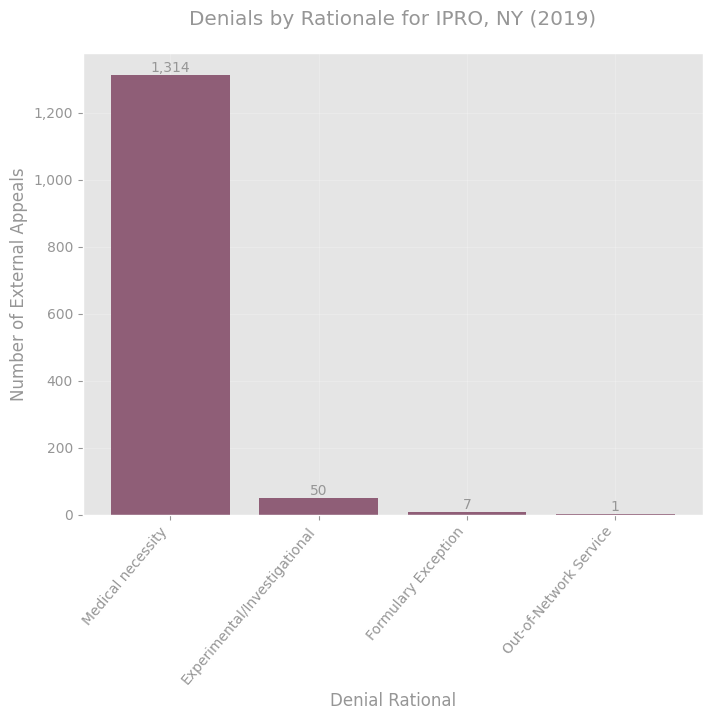

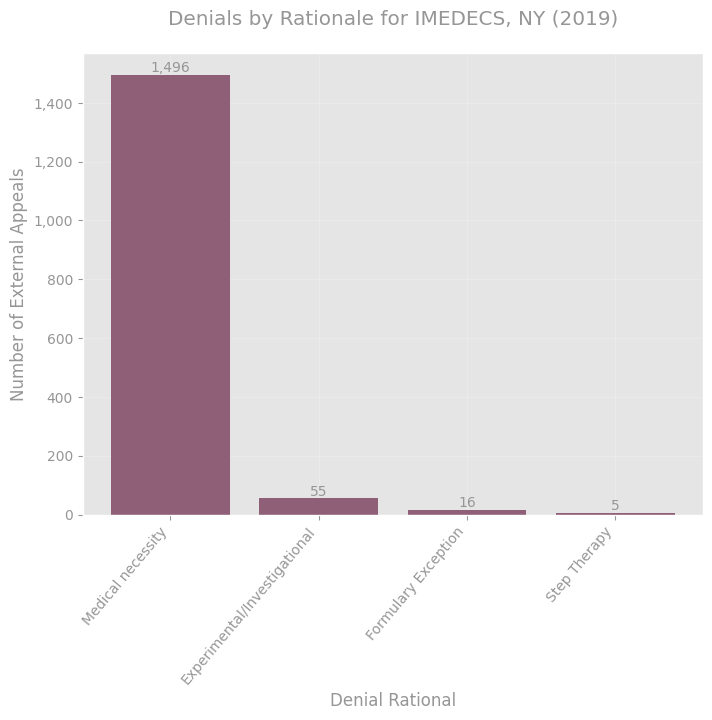

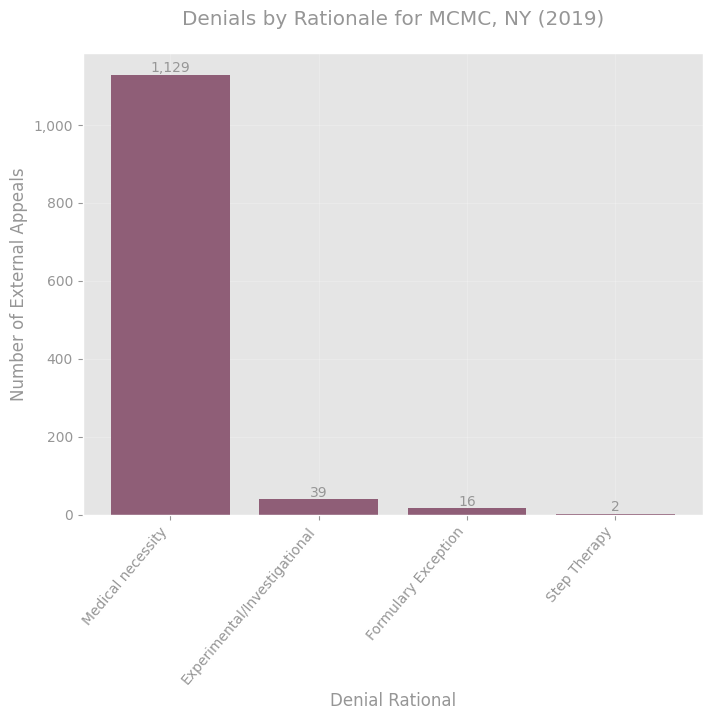

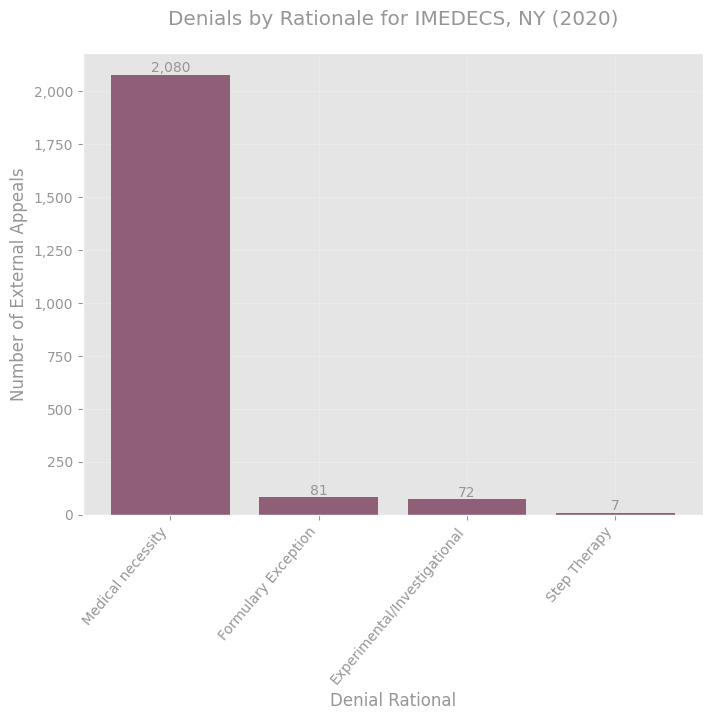

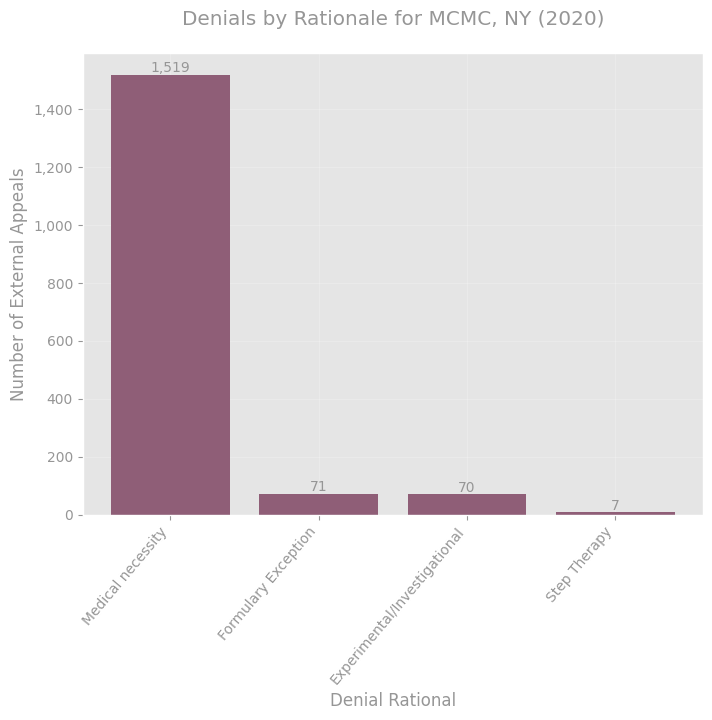

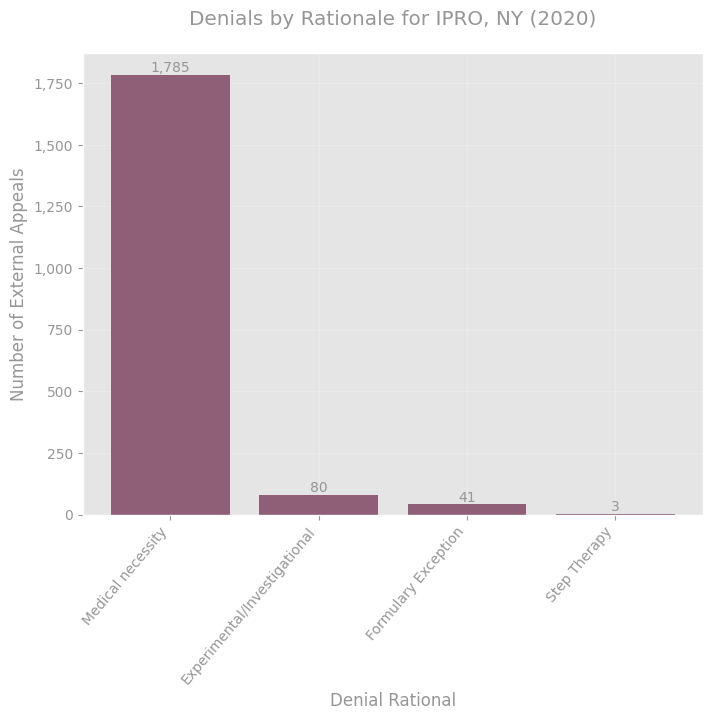

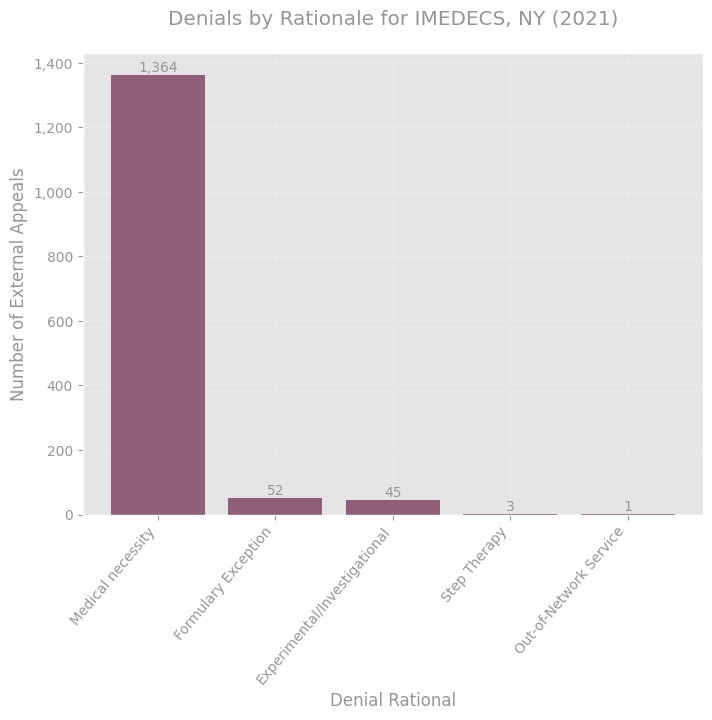

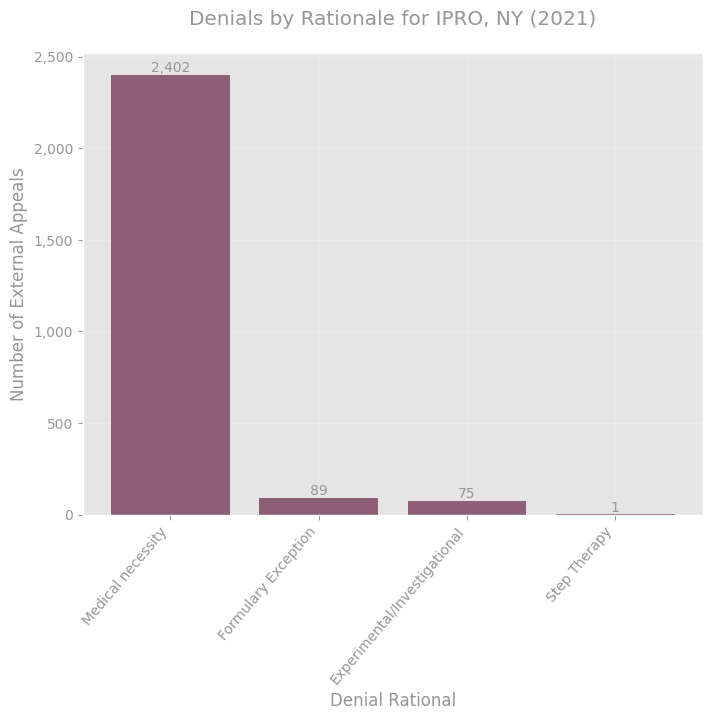

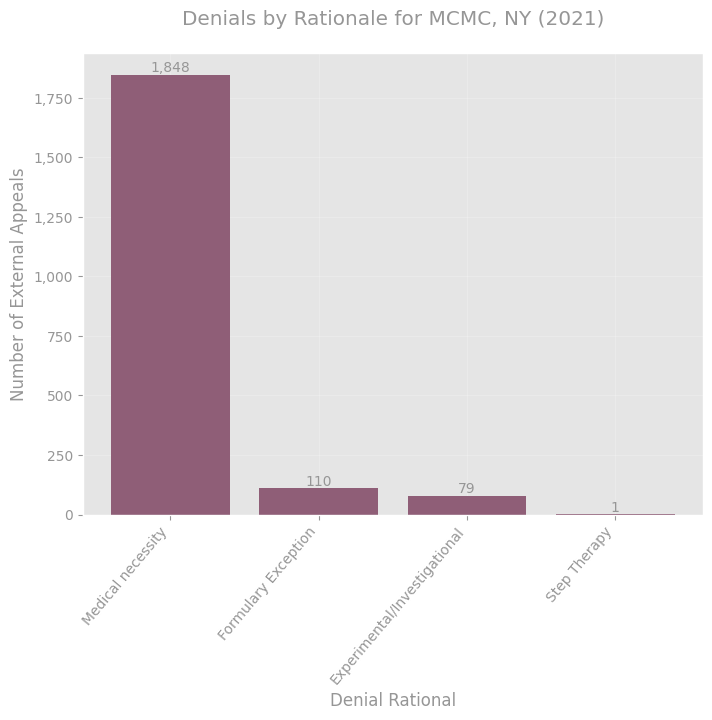

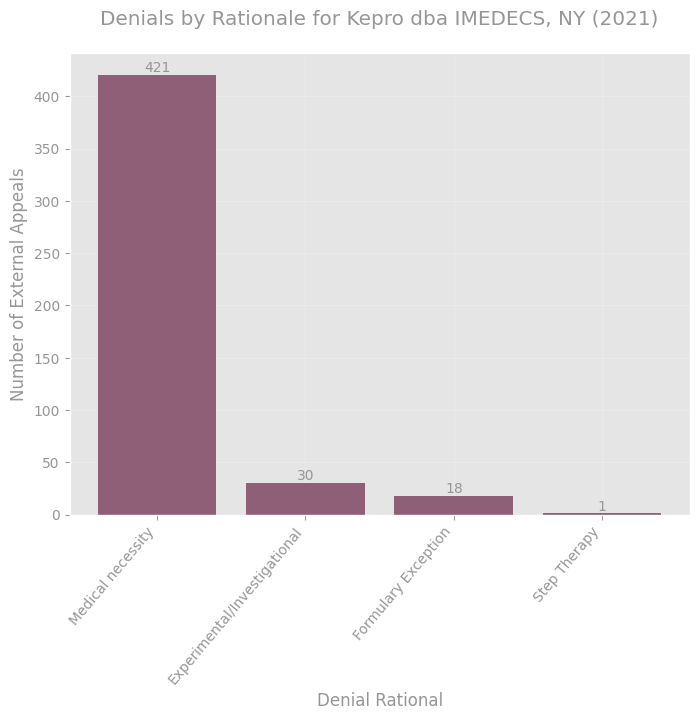

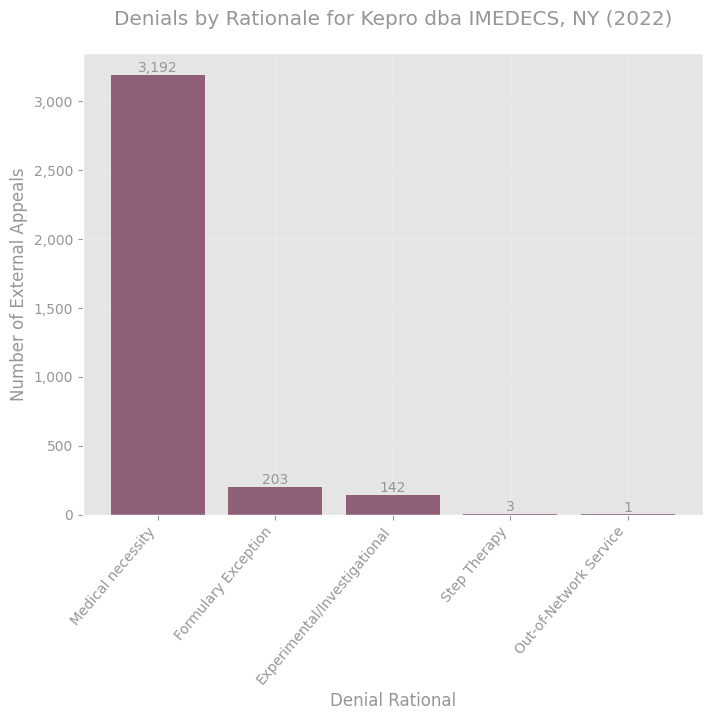

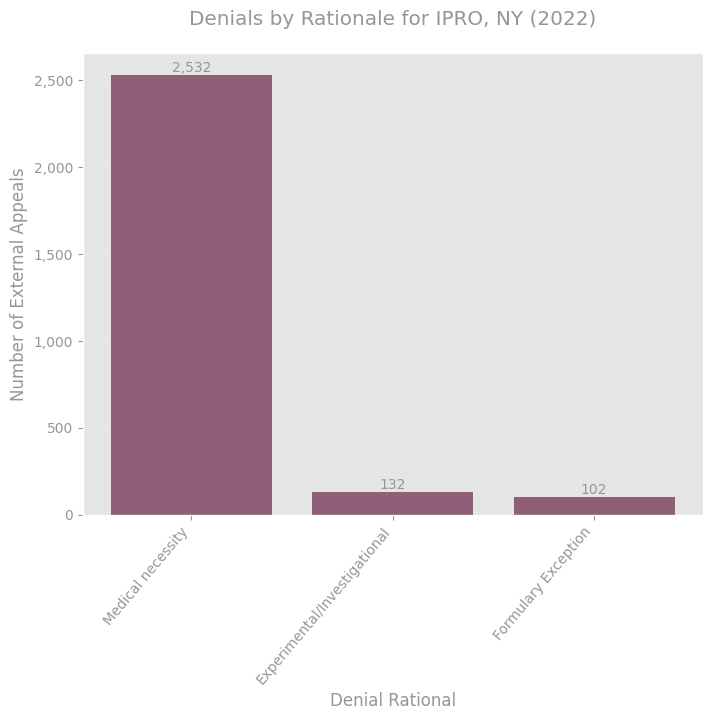

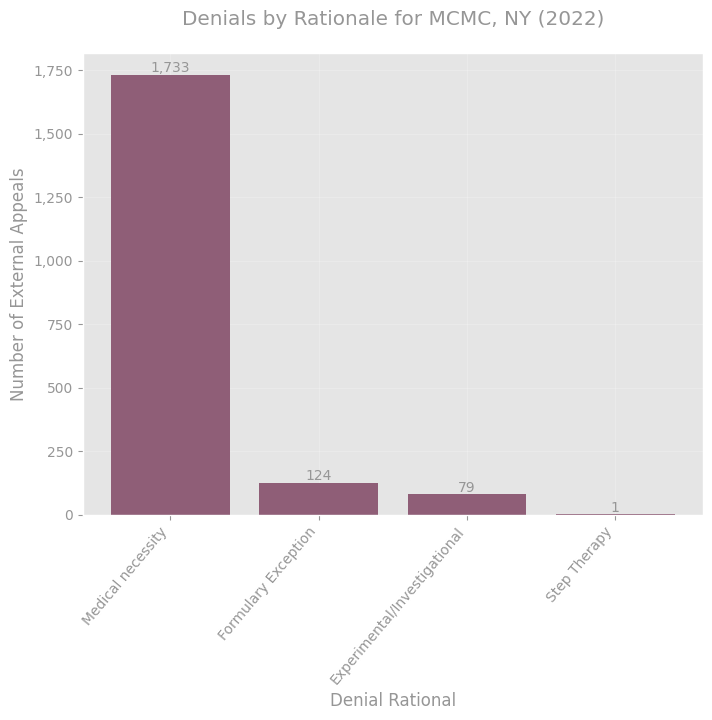

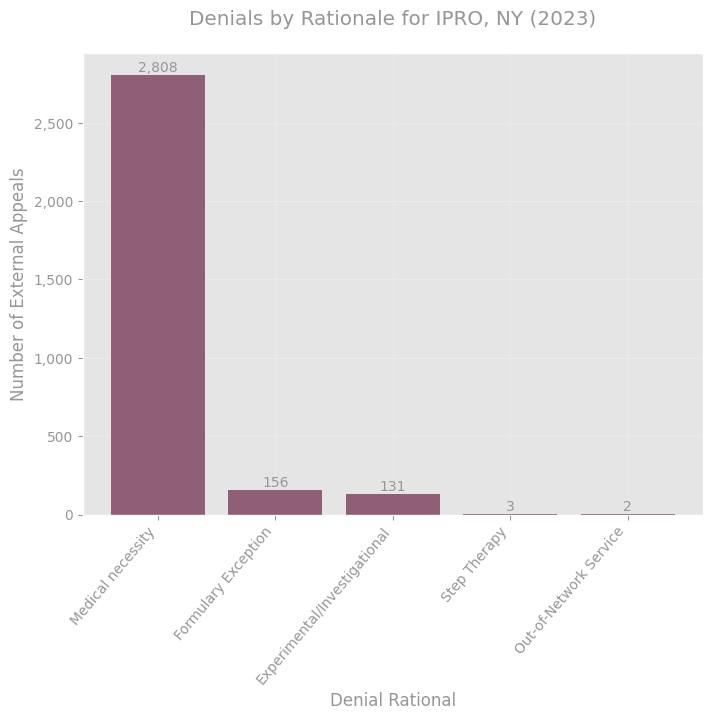

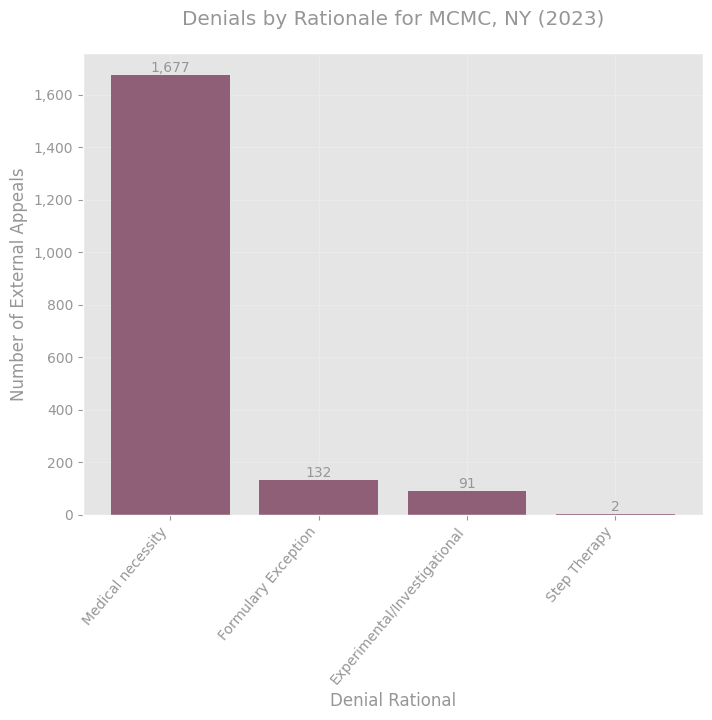

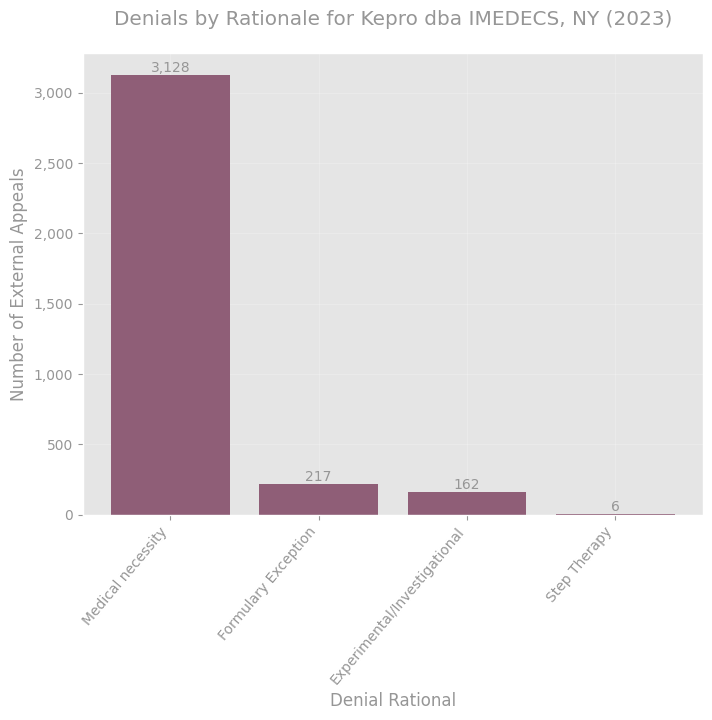

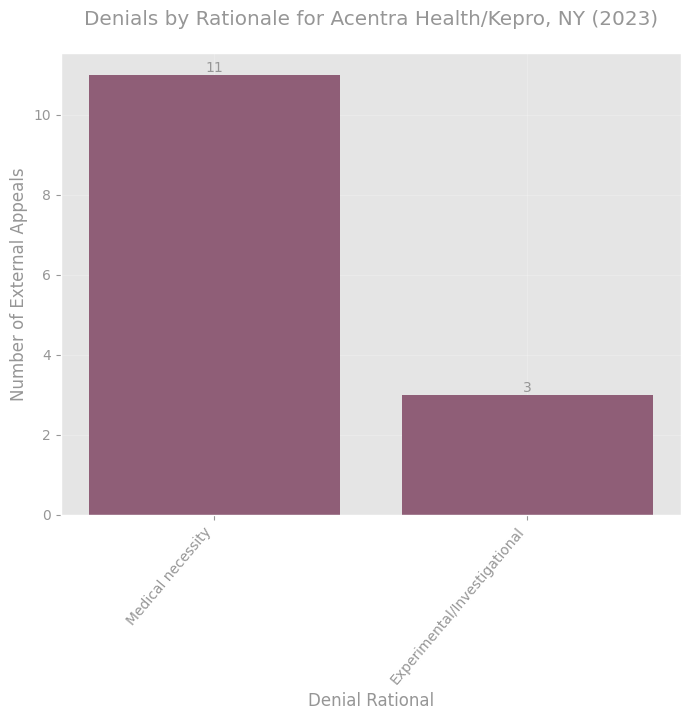

In [34]:
# Plot Distribution of Denial Rationales Handled Across Agents
for year in sorted(list(df["Decision Year"].unique())):
    rel_df = df[df["Decision Year"] == year]
    for agent in rel_df["Agent"].unique():
        agent_year_df = rel_df[rel_df["Agent"] == agent]
        val_counts = agent_year_df["Denial Reason"].value_counts()
        title = f"Denials by Rationale for {agent}, NY ({year})"
        val_axis_label = "Number of External Appeals"
        cat_axis_label = "Denial Rational"
        bar_names, bar_vals = list(val_counts.index), val_counts.values
        agent = agent.replace("/", "-")
        plot_bar(
            bar_names,
            bar_vals,
            title=title if not NO_PLOT_TITLES else None,
            val_axis_label=val_axis_label,
            cat_axis_label=cat_axis_label,
            save_path=os.path.join(
                OUTPUT_IMAGE_DIR, f"denial_rationales_{agent}_{year}.png"
            ),
            bar_label=True,
            figsize=(8, 6),
        )

It's interesting to note that that three Independent Review Organizations serving New York State have wildly different (and consistently different) complete overturn rates over the last four years.
While the average difference of about 3-6% between the agency with the highest overturn rate and the lowest may seem small, the implications for individuals whose cases are being reviewed are obviously serious.

This discrepancy also has implications for the costs of our healthcare (and who shoulders those costs). For example, suppose the ground truth here is that the review organization with the lower overturn rate (IMEDECS, which was subsumed by KEPRO) was in fact not appropriately administering reviews effectively, and were they to hand all of their cases over to either of the other organizations, those organizations would maintain their same overturn rates even with the new data (I have no evidence to back this up; this supposition is made as a thought experiment). If that were the case, the avgerage difference in overturn rate would have the effect of overturning about 445 denial decisions that would otherwise go upheld by kepro/IMEDECS, by a back of the envelope calculation. If each of these claims reduced out of pocket consumer costs by just 200 dollars (which feels highly conservative), this would amount to about 90k of wealth being inappropriately transferred from the population of average consumers fighting bills to the population of billion dollar, already highly profitable companies. See below for this rough calculation.


In [22]:
# # Back of envelope calculation:

# # Assuming the average claim being externally appealed corresponds to $200 (to be paid either by insurer, or insured). No data to back this up, but trying to make it highly conservative estimate,
# # so the back of envelope calculation airs on the side of grossly underestimating value.
# avg_claim_value = 200

# # Kepro / IMEDECS avg overturn rate over course of data timespan
# imedecs_cases = agent_decision_data["IMEDECS"]["overall"]
# kepro_cases = agent_decision_data["Kepro dba IMEDECS"]["overall"]
# kepro_imedecs_overturns = imedecs_cases["completely_overturned"] + kepro_cases["completely_overturned"]
# kepro_imedecs_external_appeals = imedecs_cases["completely_overturned"] + imedecs_cases["partially_overturned"] + imedecs_cases ["upheld"] + kepro_cases["completely_overturned"] + kepro_cases["partially_overturned"] + kepro_cases ["upheld"]
# kepro_imedecs_avg_overturn_rate = kepro_imedecs_overturns / kepro_imedecs_external_appeals

# # IPRO avg
# ipro_overturn_rate = agent_decision_data["IPRO"]["overall"]["complete_overturn_rate"]

# # MCMC avg
# mcmc_overturn_rate = agent_decision_data["MCMC"]["overall"]["complete_overturn_rate"]


# # Overturns resulting from splitting KEPRO handled appelals between IPRO/MCMC
# hypothetical_kepro_overturns = .5* kepro_imedecs_external_appeals * (ipro_overturn_rate + mcmc_overturn_rate)

# # Extra overturns one might expect
# additional_overturns = hypothetical_kepro_overturns - kepro_imedecs_overturns

# # Possible wealth retained by consumers
# wealth = additional_overturns * (200)

# print(f"Distributing {kepro_imedecs_external_appeals} external appeals submitted to KEPRO/IMEDECS from 2019 to 2023 evenly between other review agencies",
#        f"would lead to an expected {round(additional_overturns)} additional denial overturns. If each overturn corresponded to just ${avg_claim_value}",
#        f"of reduced out of pocket expense for consumers, this would amount to a total of ${round(wealth)} being returned to consumers in NY.")

#### Diagnosis breakdowns


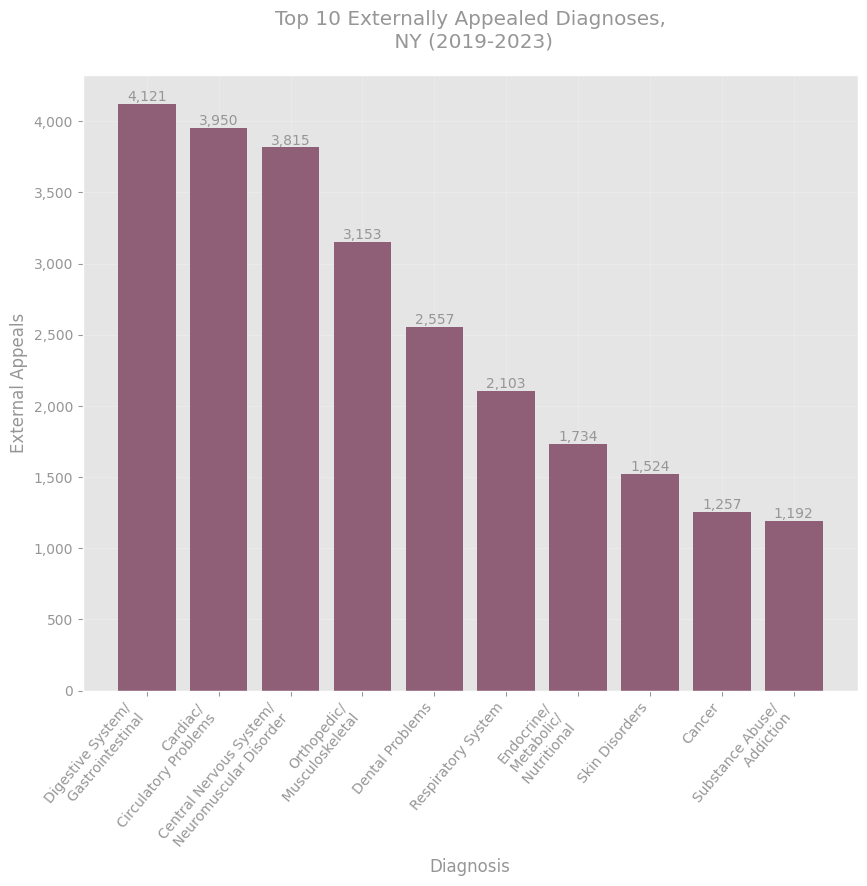

In [36]:
# Diagnosis breakdowns
n = 10
title = f"Top {n} Externally Appealed Diagnoses,\n NY (2019-2023)"
val_axis_label = "External Appeals"
cat_axis_label = "Diagnosis"
diagnosis_val_counts = df["Diagnosis"].value_counts()[:n]
bar_names, bar_vals = [
    "/\n".join(x.strip("[").strip("]").split("/"))
    for x in list(diagnosis_val_counts.index)
], diagnosis_val_counts.values
plot_bar(
    bar_names,
    bar_vals,
    title=title if not NO_PLOT_TITLES else None,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "top_externally_appealed_diagnoses.png"),
    bar_label=True,
    figsize=(10, 8),
)

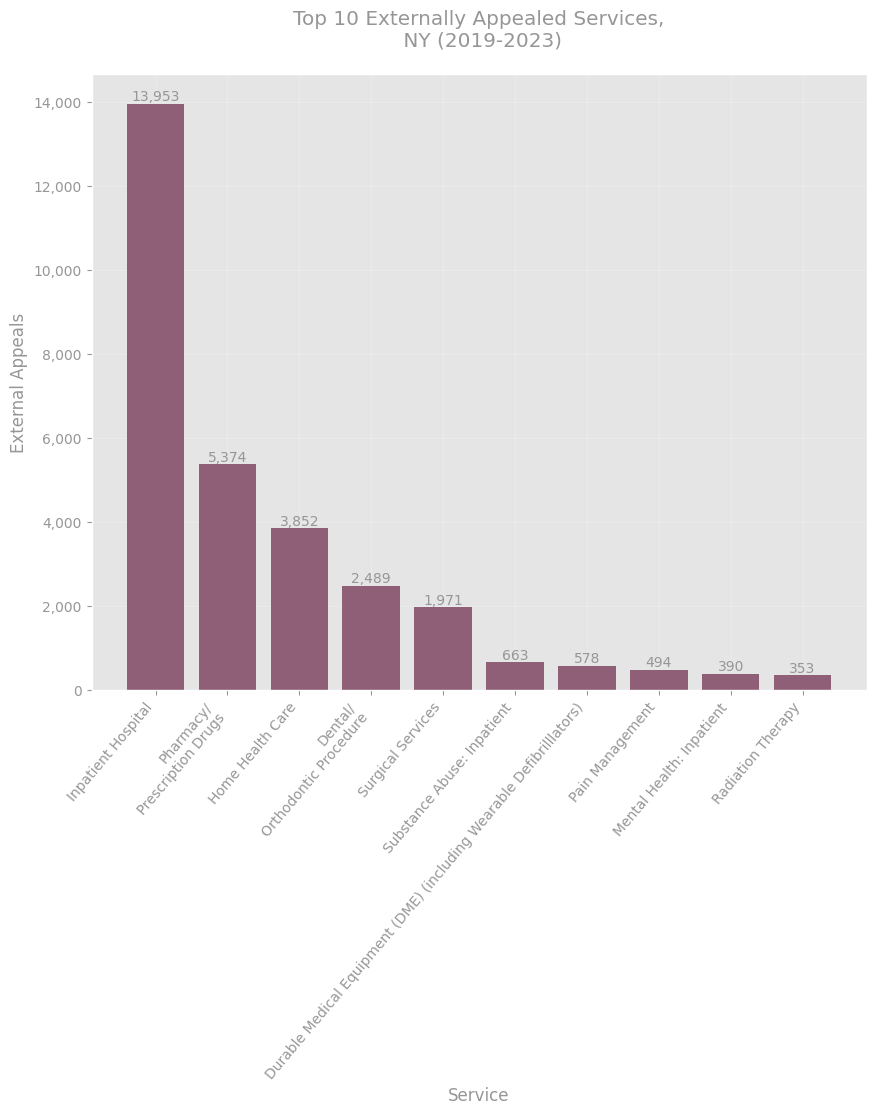

In [37]:
# Treatment breakdowns
n = 10
title = f"Top {n} Externally Appealed Services,\n NY (2019-2023)"
val_axis_label = "External Appeals"
cat_axis_label = "Service"
treatment_val_counts = df["Treatment"].value_counts()[:n]
bar_names, bar_vals = [
    "/\n".join(x.strip("[").strip("]").split("/"))
    for x in list(treatment_val_counts.index)
], treatment_val_counts.values
plot_bar(
    bar_names,
    bar_vals,
    title=title if not NO_PLOT_TITLES else None,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "top_externally_appealed_treatments.png"),
    bar_label=True,
    figsize=(10, 8),
)

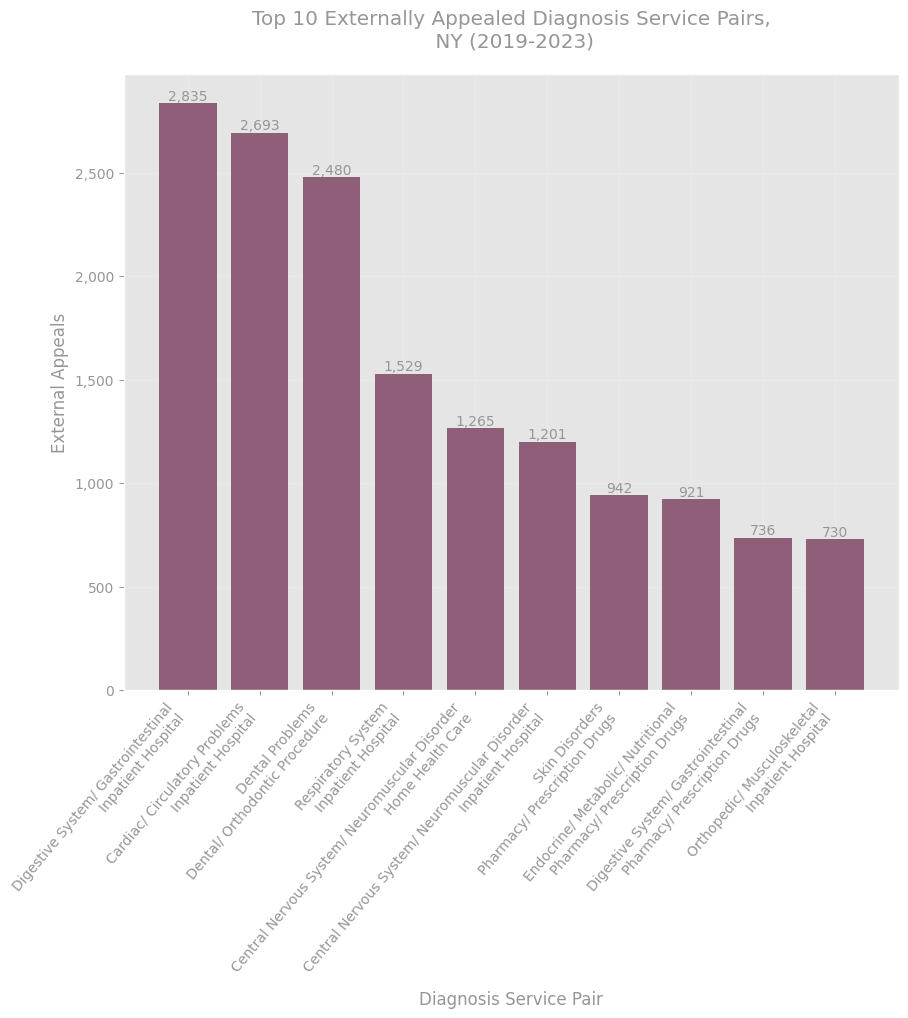

In [38]:
# Diagnosis/Treatment Pairs
n = 10
title = f"Top {n} Externally Appealed Diagnosis Service Pairs,\n NY (2019-2023)"
val_axis_label = "External Appeals"
cat_axis_label = "Diagnosis Service Pair"
diag_treat_pairs = (
    df.groupby(["Diagnosis", "Treatment"], as_index=False)
    .size()
    .sort_values(by="size", ascending=False)[:n]
)
bar_names, bar_vals = [
    x[0].strip("[").strip("]") + "\n" + x[1].strip("[").strip("]")
    for x in zip(
        diag_treat_pairs["Diagnosis"].values, diag_treat_pairs["Treatment"].values
    )
], diag_treat_pairs["size"].values
plot_bar(
    bar_names,
    bar_vals,
    title=title if not NO_PLOT_TITLES else None,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(
        OUTPUT_IMAGE_DIR, "top_externally_appealed_diag_treatments.png"
    ),
    bar_label=True,
    figsize=(10, 8),
)

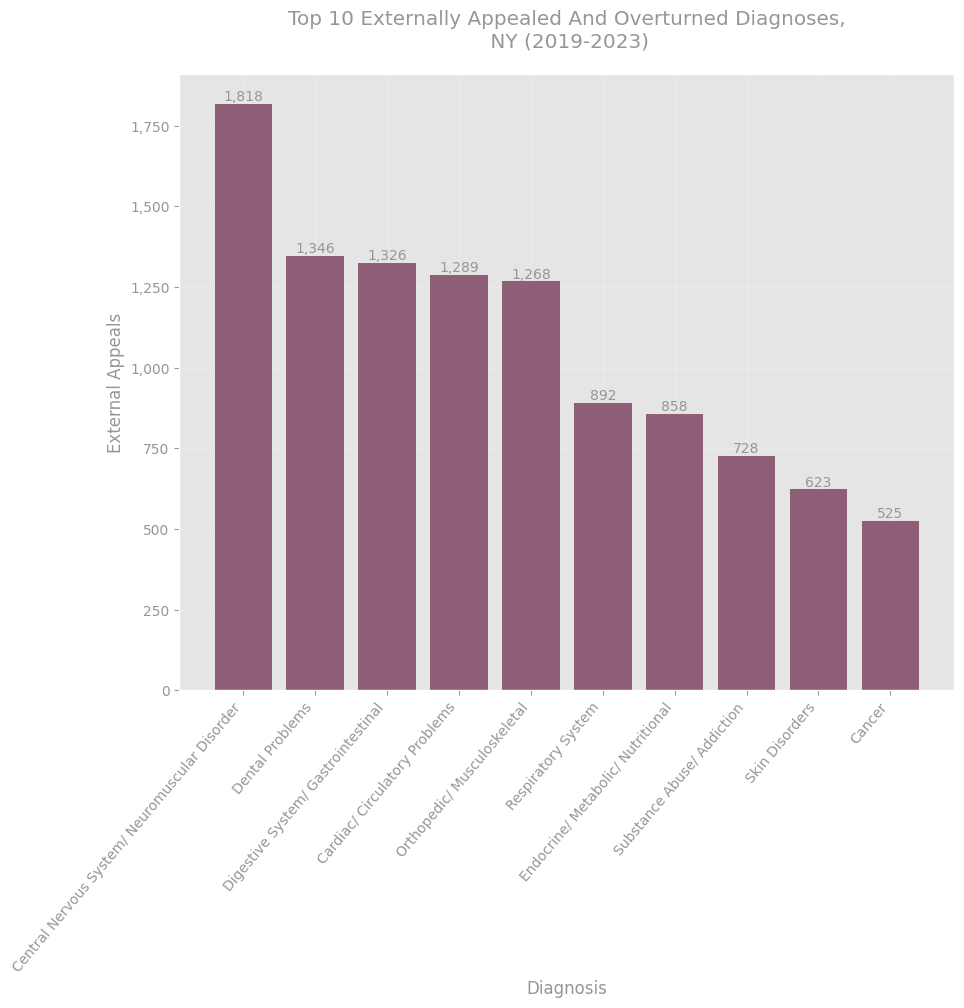

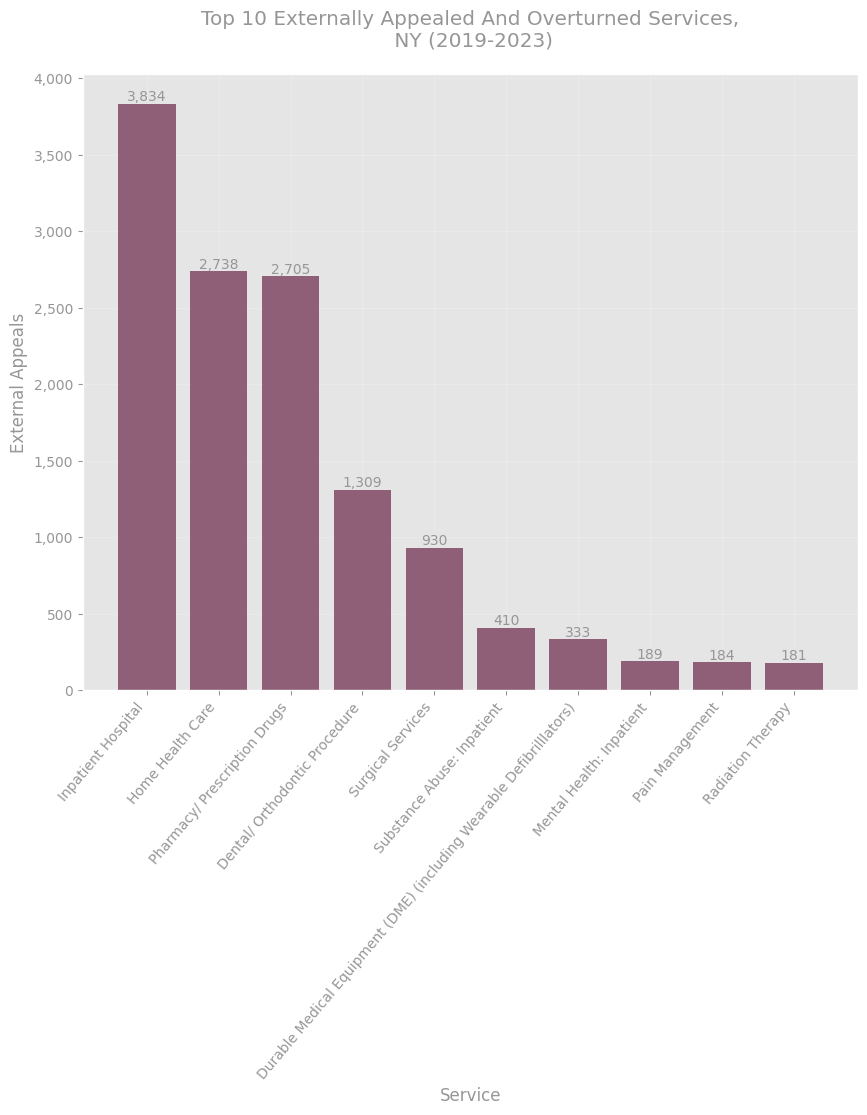

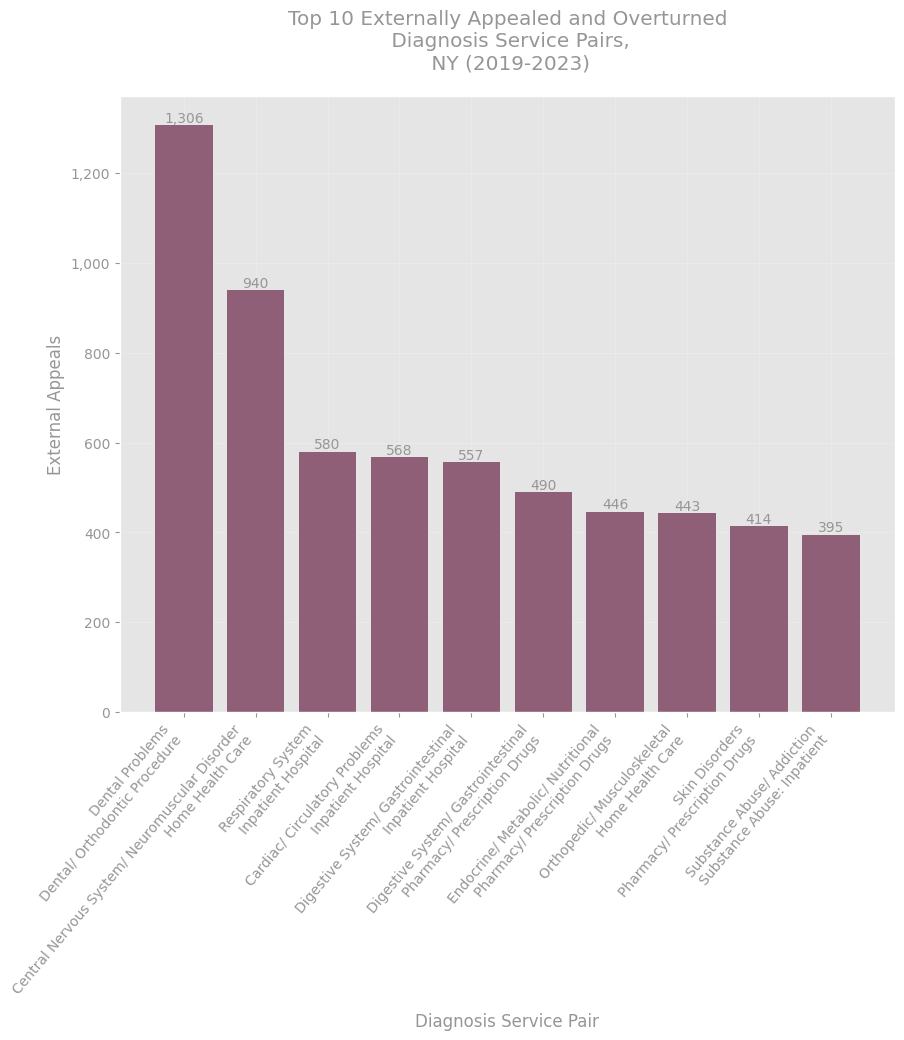

In [40]:
# Top Diagnoses, Services and Pairs for Overturned
overturns = df[df["Appeal Decision"] == "Overturned"]

# Diagnosis breakdowns
n = 10
title = f"Top {n} Externally Appealed And Overturned Diagnoses,\n NY (2019-2023)"
val_axis_label = "External Appeals"
cat_axis_label = "Diagnosis"
diagnosis_val_counts = overturns["Diagnosis"].value_counts()[:n]
bar_names, bar_vals = [
    x.strip("[").strip("]") for x in list(diagnosis_val_counts.index)
], diagnosis_val_counts.values
plot_bar(
    bar_names,
    bar_vals,
    title=title if not NO_PLOT_TITLES else None,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(
        OUTPUT_IMAGE_DIR, "top_externally_appealed_overturned_diagnoses.png"
    ),
    bar_label=True,
    figsize=(10, 8),
)

# Service
title = f"Top {n} Externally Appealed And Overturned Services,\n NY (2019-2023)"
val_axis_label = "External Appeals"
cat_axis_label = "Service"
treat_val_counts = overturns["Treatment"].value_counts()[:n]
bar_names, bar_vals = [
    x.strip("[").strip("]") for x in list(treat_val_counts.index)
], treat_val_counts.values
plot_bar(
    bar_names,
    bar_vals,
    title=title if not NO_PLOT_TITLES else None,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(
        OUTPUT_IMAGE_DIR, "top_externally_appealed_overturned_treatments.png"
    ),
    bar_label=True,
    figsize=(10, 8),
)

# Service / Diagnosis Pairs
title = f"Top {n} Externally Appealed and Overturned\n Diagnosis Service Pairs,\n NY (2019-2023)"
val_axis_label = "External Appeals"
cat_axis_label = "Diagnosis Service Pair"
diag_treat_pairs = (
    overturns.groupby(["Diagnosis", "Treatment"], as_index=False)
    .size()
    .sort_values(by="size", ascending=False)[:n]
)
bar_names, bar_vals = [
    x[0].strip("[").strip("]") + "\n" + x[1].strip("[").strip("]")
    for x in zip(
        diag_treat_pairs["Diagnosis"].values,
        diag_treat_pairs["Treatment"].values,
    )
], diag_treat_pairs["size"].values
plot_bar(
    bar_names,
    bar_vals,
    title=title if not NO_PLOT_TITLES else None,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "top_overturned_diag_services.png"),
    bar_label=True,
    figsize=(10, 8),
)

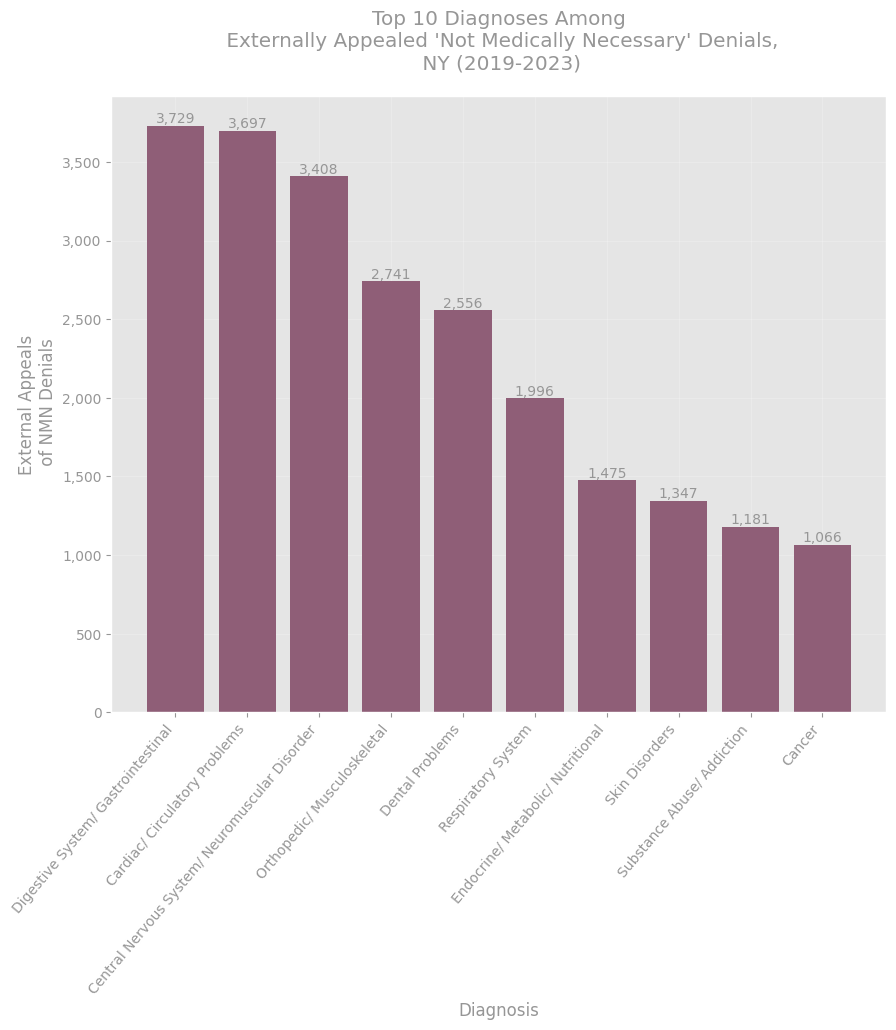

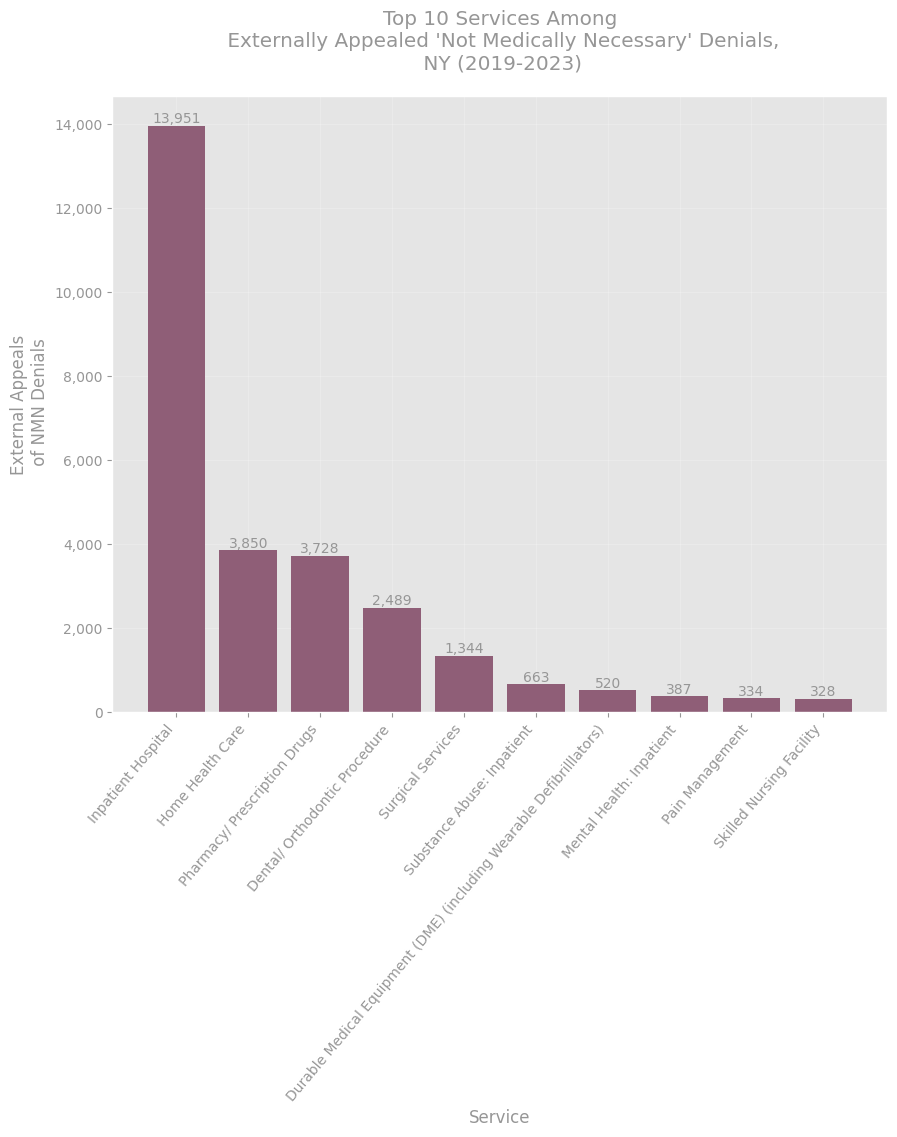

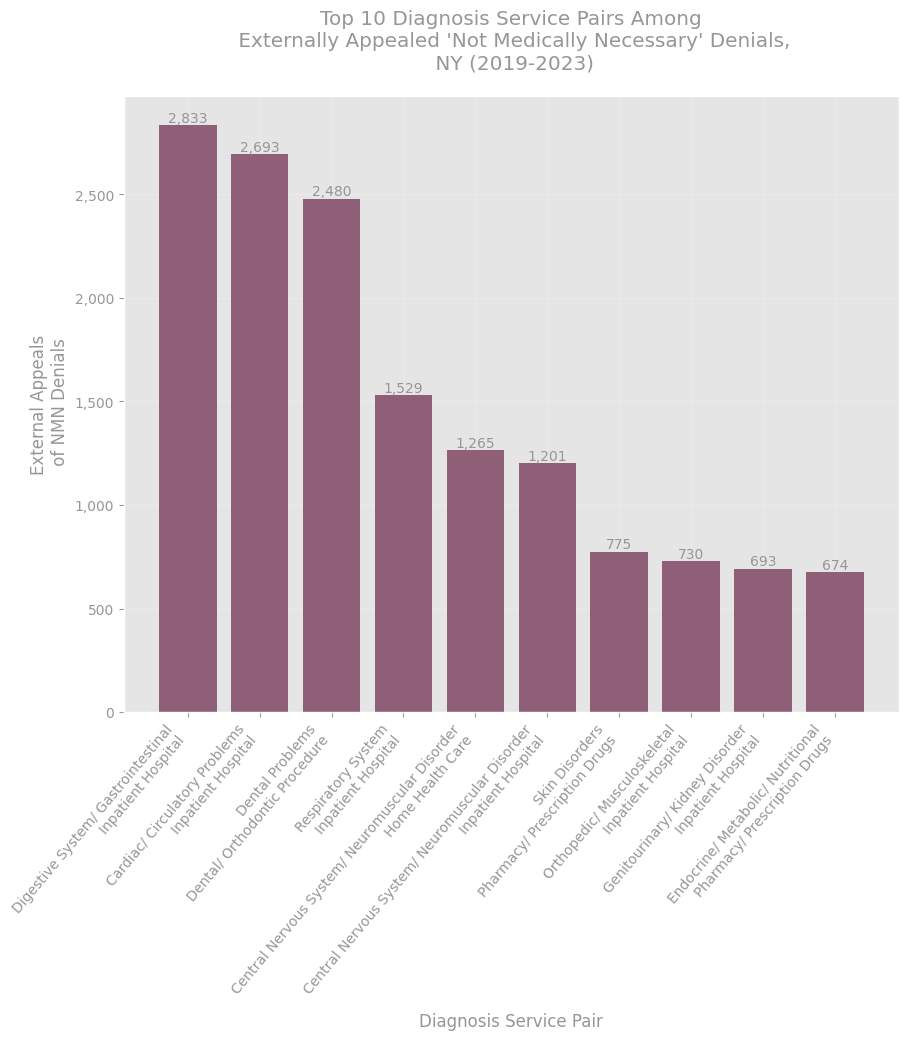

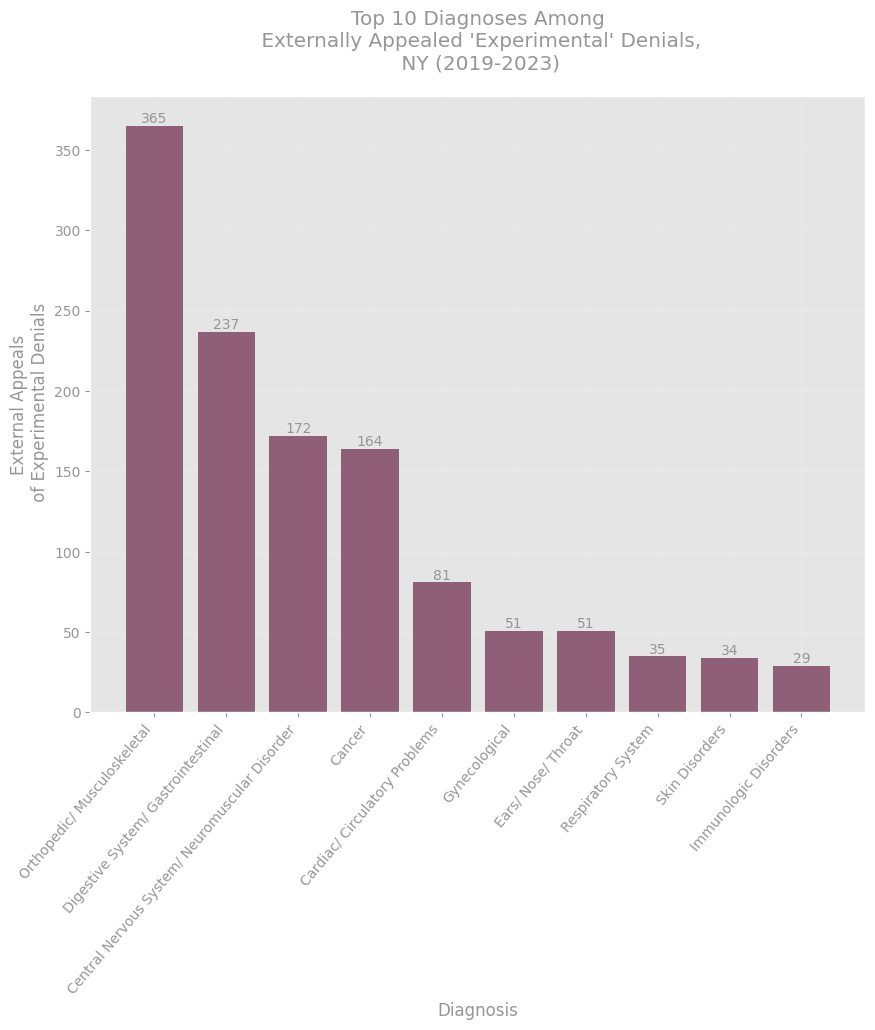

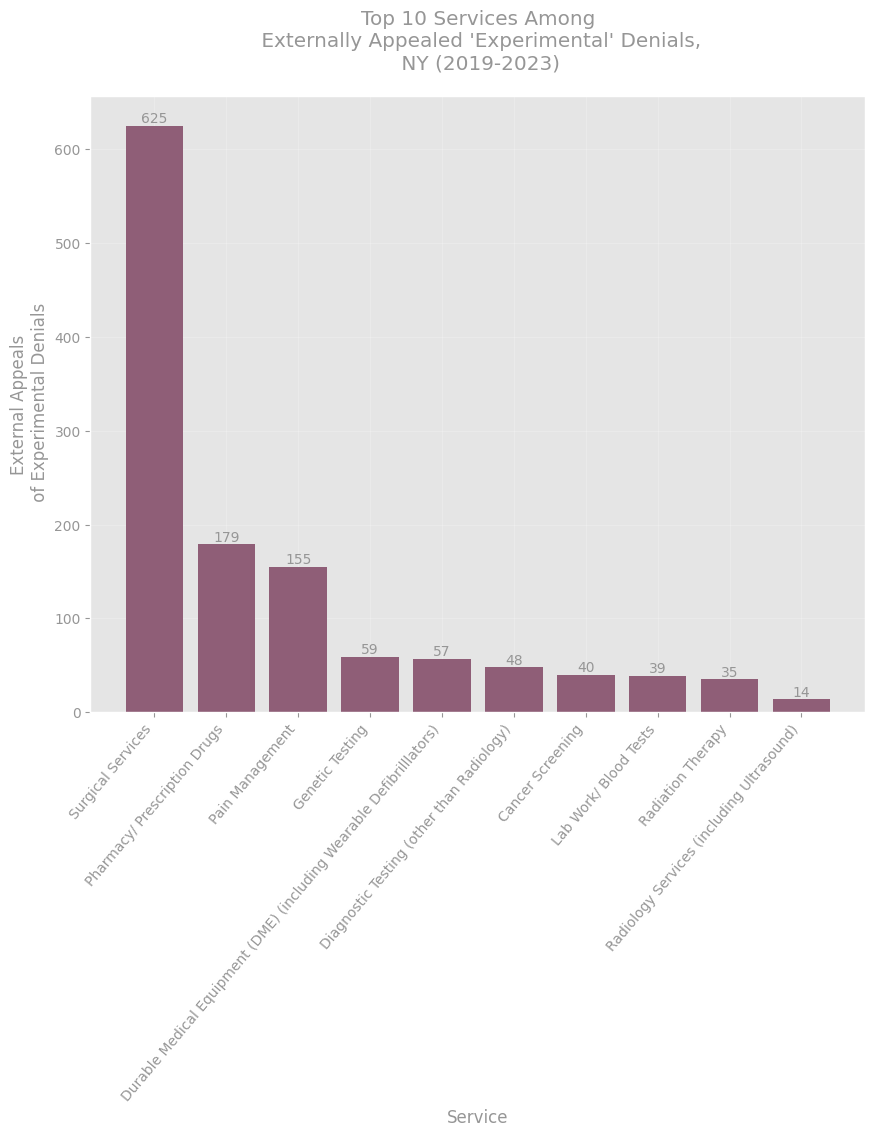

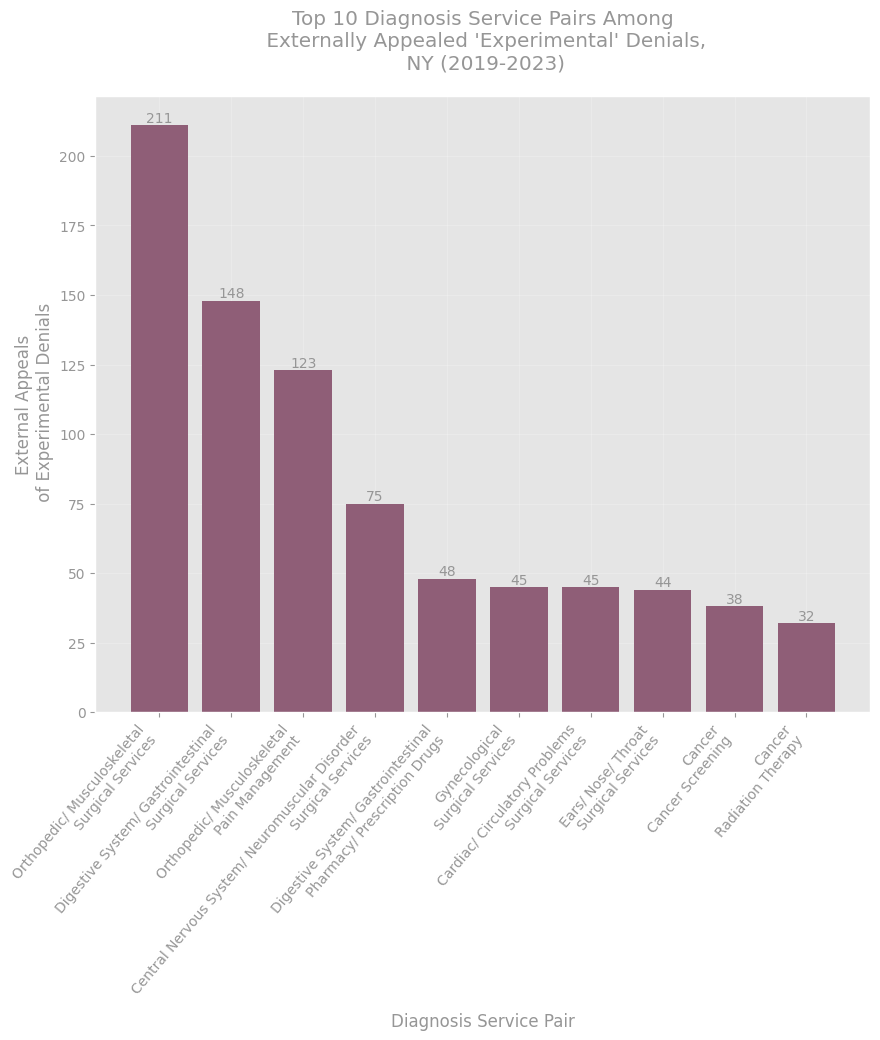

In [41]:
# Top Diagnoses, Services and Pairs for NMN/Experimental Appeals
nmn = df[df["Denial Reason"] == "Medical necessity"]
experimental = df[df["Denial Reason"] == "Experimental/Investigational"]
n = 10

title = f"Top {n} Diagnoses Among\n Externally Appealed 'Not Medically Necessary' Denials,\n NY (2019-2023)"
val_axis_label = "External Appeals\n of NMN Denials"
cat_axis_label = "Diagnosis"
diagnosis_val_counts = nmn["Diagnosis"].value_counts()[:n]
bar_names, bar_vals = [
    x.strip("[").strip("]") for x in list(diagnosis_val_counts.index)
], diagnosis_val_counts.values
plot_bar(
    bar_names,
    bar_vals,
    title=title if not NO_PLOT_TITLES else None,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "top_nmn_appeal_diagnoses.png"),
    figsize=(10, 8),
    bar_label=True,
)

title = f"Top {n} Services Among\n Externally Appealed 'Not Medically Necessary' Denials,\n NY (2019-2023)"
val_axis_label = "External Appeals\n of NMN Denials"
cat_axis_label = "Service"
service_val_counts = nmn["Treatment"].value_counts()[:n]
bar_names, bar_vals = [
    x.strip("[").strip("]") for x in list(service_val_counts.index)
], service_val_counts.values
plot_bar(
    bar_names,
    bar_vals,
    title=title if not NO_PLOT_TITLES else None,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "top_nmn_appeal_services.png"),
    figsize=(10, 8),
    bar_label=True,
)

title = f"Top {n} Diagnosis Service Pairs Among\n Externally Appealed 'Not Medically Necessary' Denials,\n NY (2019-2023)"
val_axis_label = "External Appeals\n of NMN Denials"
cat_axis_label = "Diagnosis Service Pair"
diag_treat_pairs = (
    nmn.groupby(["Diagnosis", "Treatment"], as_index=False)
    .size()
    .sort_values(by="size", ascending=False)[:n]
)
bar_names, bar_vals = [
    x[0].strip("[").strip("]") + "\n" + x[1].strip("[").strip("]")
    for x in zip(
        diag_treat_pairs["Diagnosis"].values,
        diag_treat_pairs["Treatment"].values,
    )
], diag_treat_pairs["size"].values
plot_bar(
    bar_names,
    bar_vals,
    title=title if not NO_PLOT_TITLES else None,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "top_nmn_appeal_diag_service.png"),
    figsize=(10, 8),
    bar_label=True,
)

# Diagnosis breakdowns among Experimental Denials
n = 10
title = f"Top {n} Diagnoses Among\n Externally Appealed 'Experimental' Denials,\n NY (2019-2023)"
val_axis_label = "External Appeals\n of Experimental Denials"
cat_axis_label = "Diagnosis"
diagnosis_val_counts = experimental["Diagnosis"].value_counts()[:n]
bar_names, bar_vals = [
    x.strip("[").strip("]") for x in list(diagnosis_val_counts.index)
], diagnosis_val_counts.values
plot_bar(
    bar_names,
    bar_vals,
    title=title if not NO_PLOT_TITLES else None,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "top_experimental_appeal_diagnoses.png"),
    bar_label=True,
    figsize=(10, 8),
)

title = f"Top {n} Services Among\n Externally Appealed 'Experimental' Denials,\n NY (2019-2023)"
val_axis_label = "External Appeals\n of Experimental Denials"
cat_axis_label = "Service"
treat_val_counts = experimental["Treatment"].value_counts()[:n]
bar_names, bar_vals = [
    x.strip("[").strip("]") for x in list(treat_val_counts.index)
], treat_val_counts.values
plot_bar(
    bar_names,
    bar_vals,
    title=title if not NO_PLOT_TITLES else None,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "top_experimental_appeal_services.png"),
    bar_label=True,
    figsize=(10, 8),
)

title = f"Top {n} Diagnosis Service Pairs Among\n Externally Appealed 'Experimental' Denials,\n NY (2019-2023)"
val_axis_label = "External Appeals\n of Experimental Denials"
cat_axis_label = "Diagnosis Service Pair"
diag_treat_pairs = (
    experimental.groupby(["Diagnosis", "Treatment"], as_index=False)
    .size()
    .sort_values(by="size", ascending=False)[:n]
)
bar_names, bar_vals = [
    x[0].strip("[").strip("]") + "\n" + x[1].strip("[").strip("]")
    for x in zip(
        diag_treat_pairs["Diagnosis"].values,
        diag_treat_pairs["Treatment"].values,
    )
], diag_treat_pairs["size"].values
plot_bar(
    bar_names,
    bar_vals,
    title=title if not NO_PLOT_TITLES else None,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(
        OUTPUT_IMAGE_DIR, "top_experimental_appeal_diag_services.png"
    ),
    bar_label=True,
    figsize=(10, 8),
)

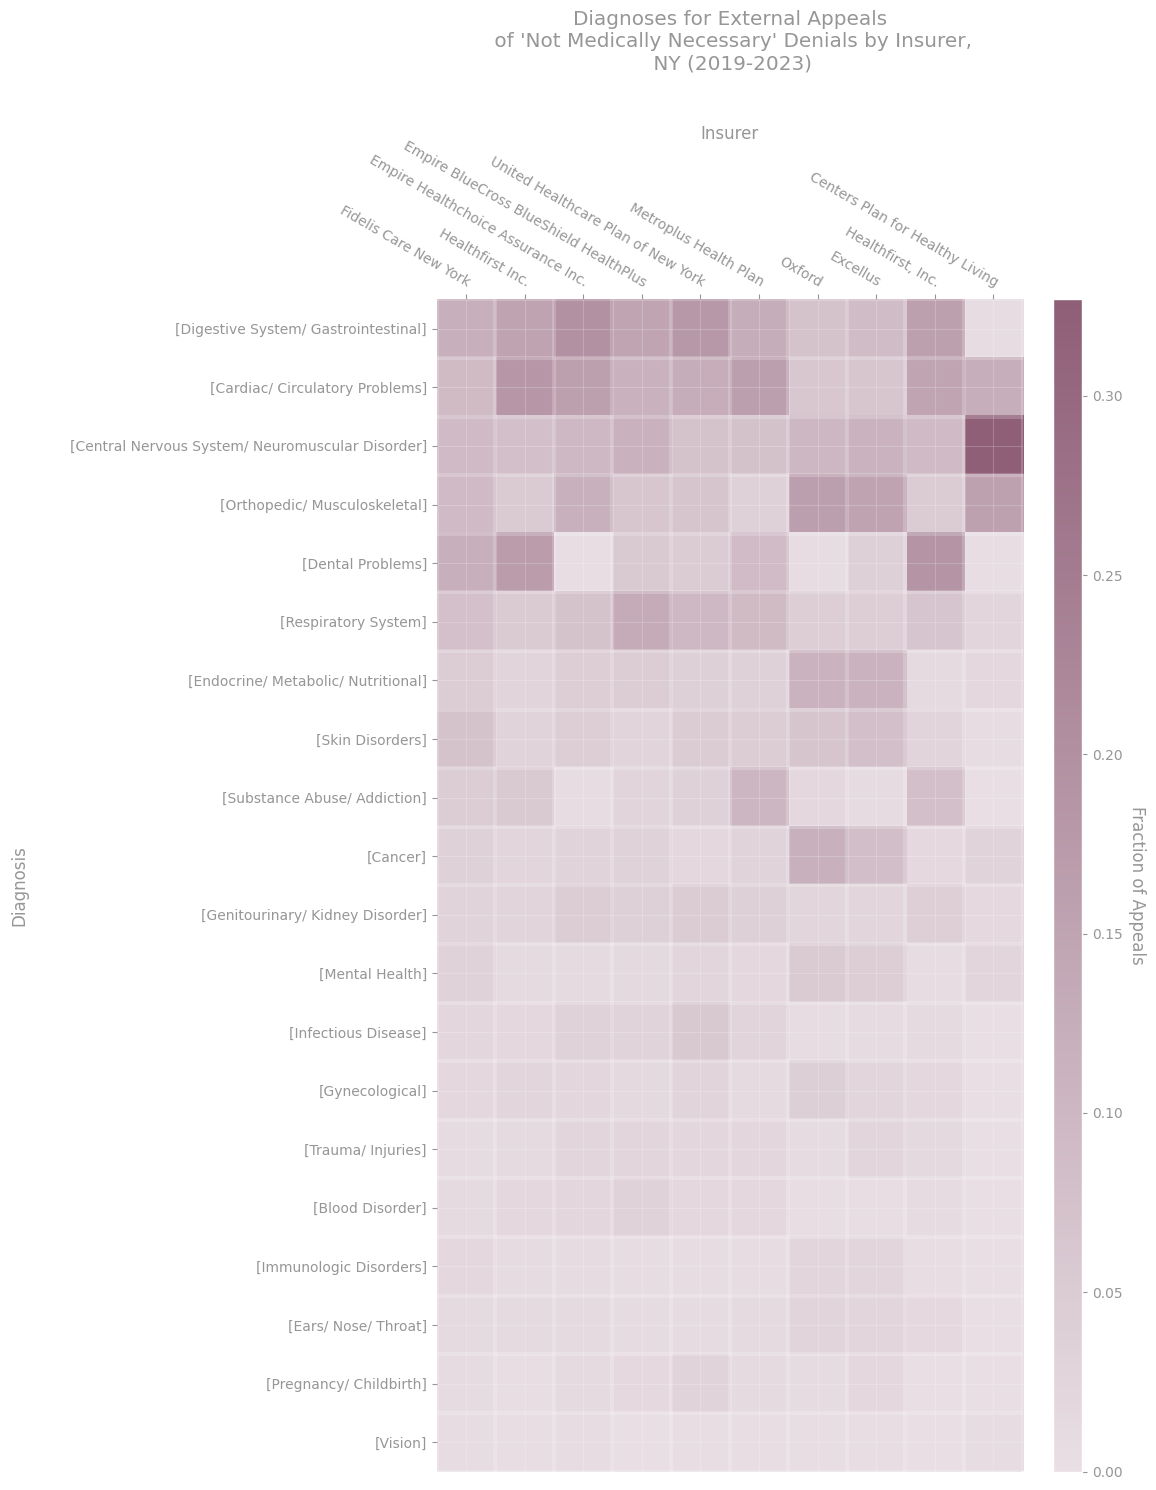

In [42]:
# Insurer/ Diagnosis Appeal Count heatmaps broken down by denial cat.
heatmap_from_df_cols(
    nmn,
    col1="Diagnosis",
    col2="Health Plan",
    top_k1=20,
    top_k2=10,
    heat_val_name="Fraction of Appeals",
    normalize=True,
    title="Diagnoses for External Appeals\n of 'Not Medically Necessary' Denials by Insurer,\n NY (2019-2023)"
    if not NO_PLOT_TITLES
    else None,
    x_label="Insurer",
    y_label="Diagnosis",
    figsize=(12, 15),
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "nmn_diagnosis_by_insurer.png"),
)

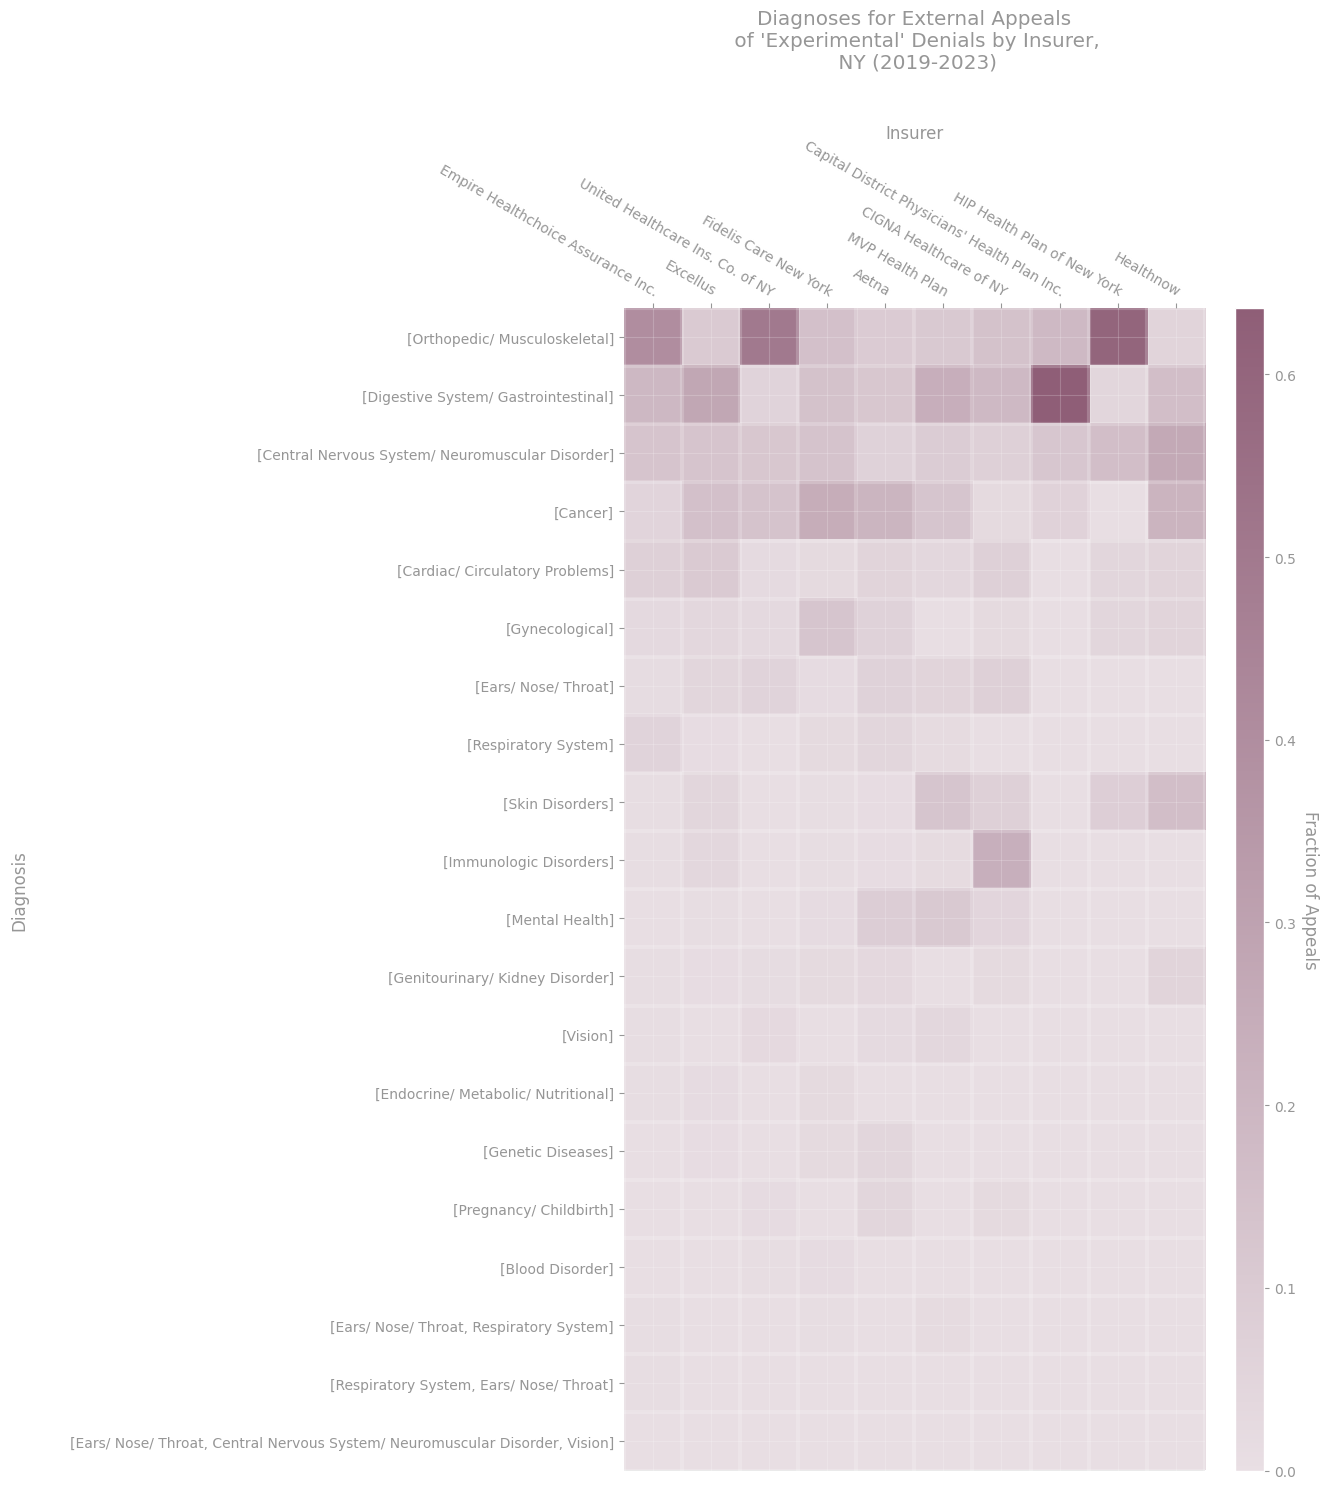

In [43]:
# Insurer/ Diagnosis Appeal Count heatmaps broken down by denial cat.
heatmap_from_df_cols(
    experimental,
    col1="Diagnosis",
    col2="Health Plan",
    top_k1=20,
    top_k2=10,
    heat_val_name="Fraction of Appeals",
    normalize=True,
    title="Diagnoses for External Appeals\n of 'Experimental' Denials by Insurer,\n NY (2019-2023)"
    if not NO_PLOT_TITLES
    else None,
    x_label="Insurer",
    y_label="Diagnosis",
    figsize=(12, 15),
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "experimental_diagnosis_by_insurer.png"),
)

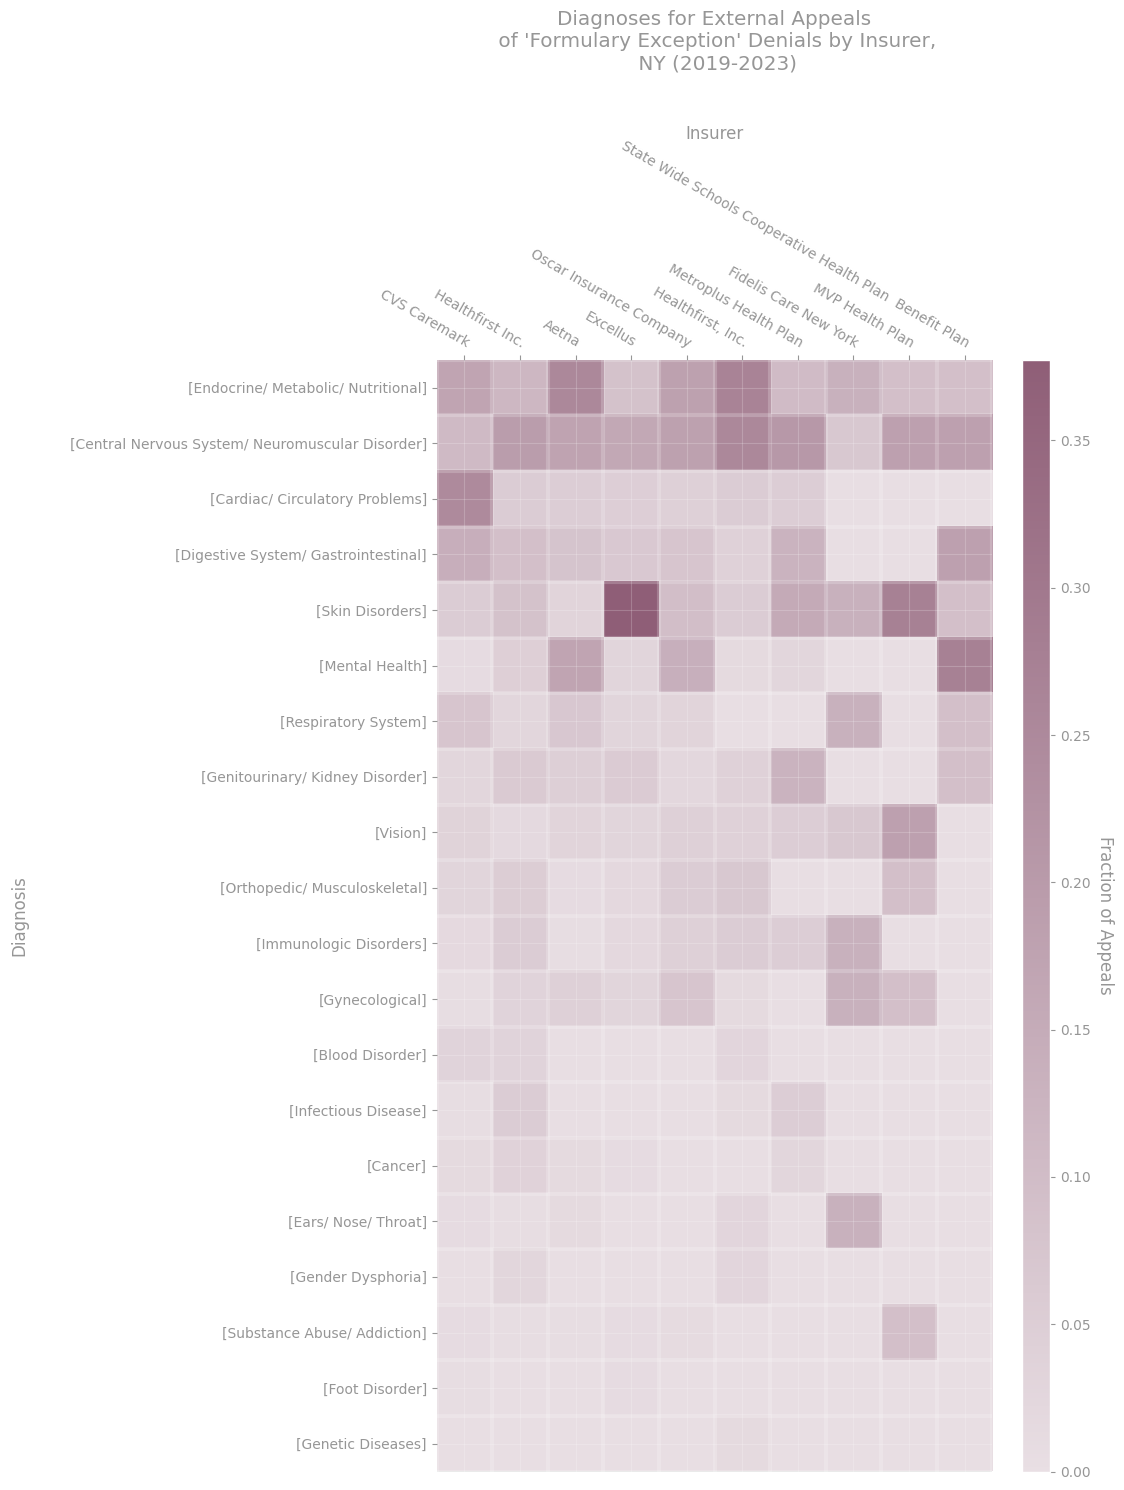

In [44]:
# Insurer/ Diagnosis Appeal Count heatmaps broken down by denial cat.
formulary = df[df["Denial Reason"] == "Formulary Exception"]
heatmap_from_df_cols(
    formulary,
    col1="Diagnosis",
    col2="Health Plan",
    top_k1=20,
    top_k2=10,
    heat_val_name="Fraction of Appeals",
    normalize=True,
    title="Diagnoses for External Appeals\n of 'Formulary Exception' Denials by Insurer,\n NY (2019-2023)"
    if not NO_PLOT_TITLES
    else None,
    x_label="Insurer",
    y_label="Diagnosis",
    figsize=(12, 15),
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "formulary_diagnosis_by_insurer.png"),
)

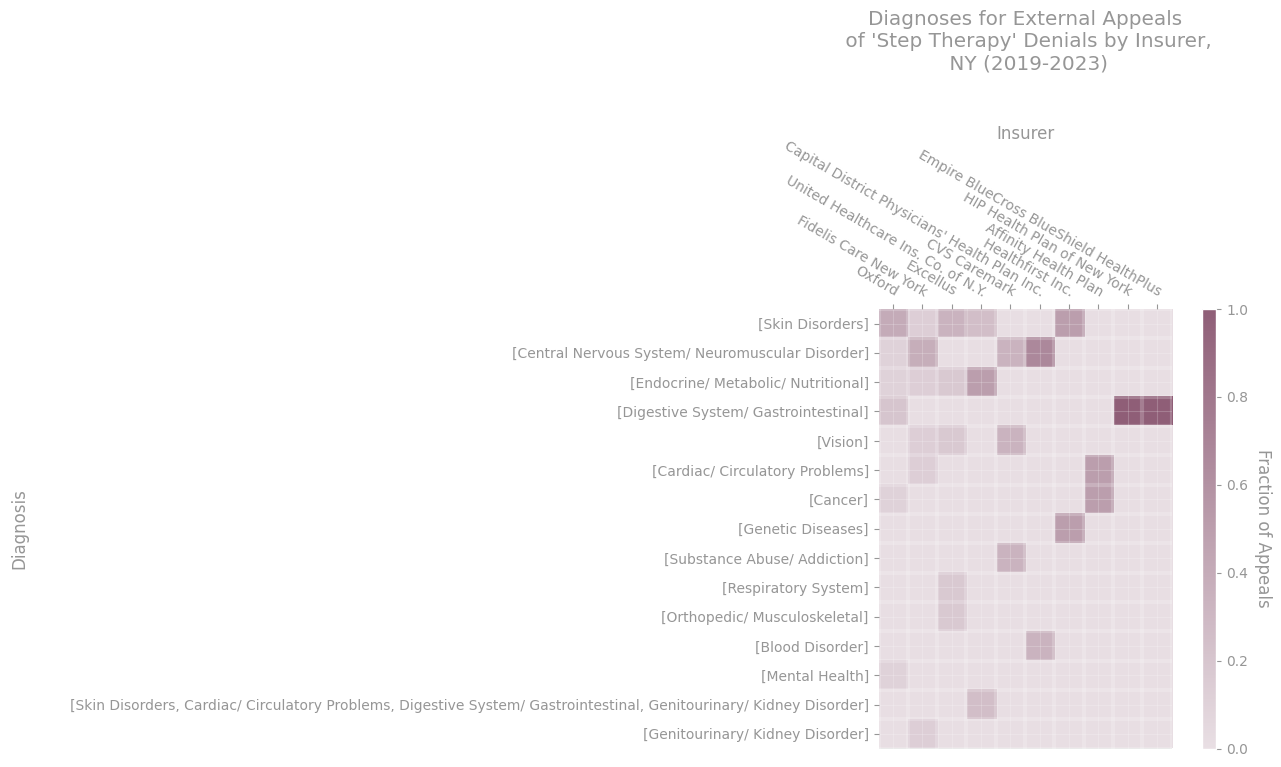

In [45]:
# Insurer/ Diagnosis Appeal Count heatmaps broken down by denial cat.
formulary = df[df["Denial Reason"] == "Step Therapy"]
heatmap_from_df_cols(
    formulary,
    col1="Diagnosis",
    col2="Health Plan",
    top_k1=20,
    top_k2=10,
    heat_val_name="Fraction of Appeals",
    normalize=True,
    title="Diagnoses for External Appeals\n of 'Step Therapy' Denials by Insurer,\n NY (2019-2023)"
    if not NO_PLOT_TITLES
    else None,
    x_label="Insurer",
    y_label="Diagnosis",
    figsize=(12, 15),
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "step_diagnosis_by_insurer.png"),
)

In [46]:
diagnosis_decision_data = get_overturn_rates_by_category(
    df, cat_col="Diagnosis", by_year=True
)

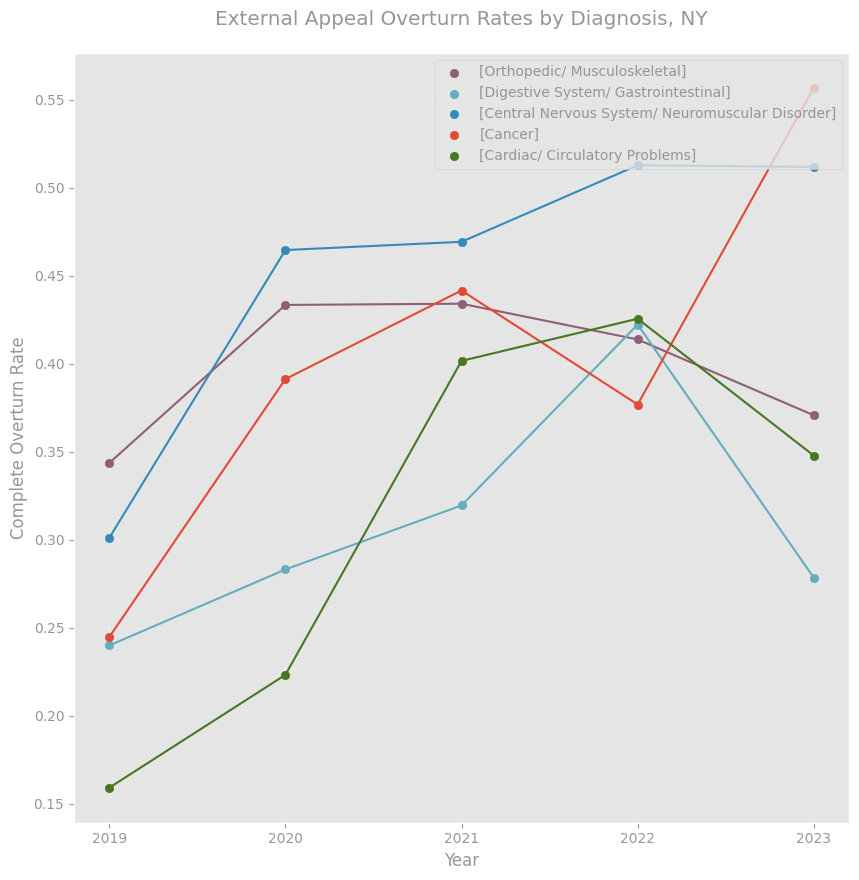

In [48]:
# Plot diagnosis decision rates over time
fig, ax = plt.subplots(figsize=(10, 10))
x = sorted(list(df["Decision Year"].unique()))
if not NO_PLOT_TITLES:
    ax.set_title("External Appeal Overturn Rates by Diagnosis, NY")
ax.set_ylabel("Complete Overturn Rate")
ax.set_xlabel("Year")
dates = np.asarray(x).astype(str)
for diagnosis in diagnosis_val_counts[:5].keys():
    timeseries = []
    for year in x:
        if diagnosis_decision_data[diagnosis].get(year, None):
            timeseries.append(
                diagnosis_decision_data[diagnosis][year]["complete_overturn_rate"]
            )
        else:
            timeseries.append(None)
    ax.scatter(dates, timeseries, label=diagnosis)
    ax.plot(dates, timeseries)
ax.legend()
save_path = os.path.join(
    OUTPUT_IMAGE_DIR, "external_appeal_overturn_rates_by_diganosis.png"
)
plt.savefig(save_path, transparent=True, bbox_inches="tight")
plt.show()

#### Breakdowns By Demographic Information

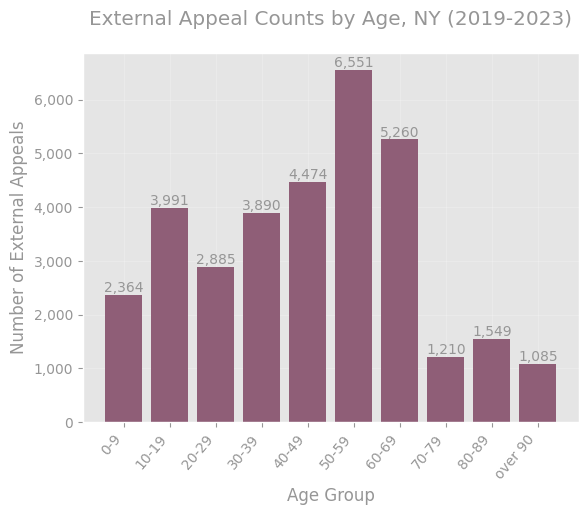

In [49]:
cat_val_counts = df["Age Range"].value_counts()
bar_names, bar_vals = list(cat_val_counts.index), cat_val_counts.values
sort_order = np.argsort(bar_names)
bar_names = [bar_names[x] for x in sort_order]
bar_vals = [bar_vals[x] for x in sort_order]
title = "External Appeal Counts by Age, NY (2019-2023)"
val_axis_label = "Number of External Appeals"
cat_axis_label = "Age Group"
plot_bar(
    bar_names,
    bar_vals,
    title=title if not NO_PLOT_TITLES else None,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "external_appeal_counts_by_age.png"),
    bar_label=True,
)

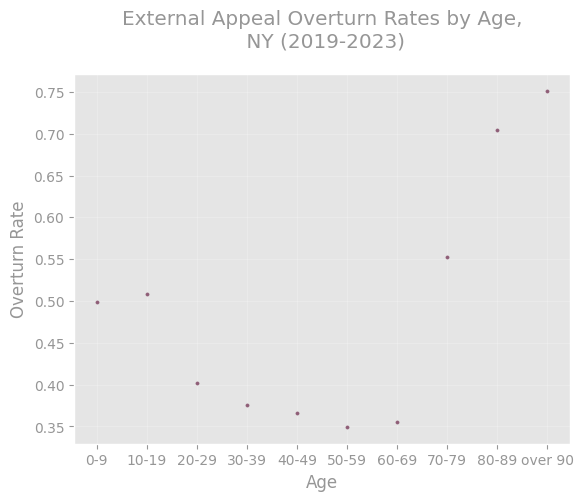

In [50]:
df["AgeRange"] = df["Age Range"].fillna("No Value")
(cats, overturn_rates) = zip(
    *get_overturn_rates_by_categorical_col(
        df,
        "AgeRange",
        outcome_col_name="Appeal Decision",
        overturn_val="Overturned",
    )
)

title = "External Appeal Overturn Rates by Age,\n NY (2019-2023)"
y_label = "Overturn Rate"
x_label = "Age"

fig, ax = plt.subplots()
ax.scatter(cats, overturn_rates, s=5)
ax.set_title(title)
ax.set_ylabel(y_label)
ax.set_xlabel(x_label)
plt.show()

In [51]:
# Success rate by age per year
age_decision_data = get_overturn_rates_by_category(
    df, cat_col="Age Range", by_year=True
)

# Sorted (for plotting)
age_keys = list(age_decision_data.keys())
age_keys.sort()
sorted_age_decision_data = {key: age_decision_data[key] for key in age_keys}

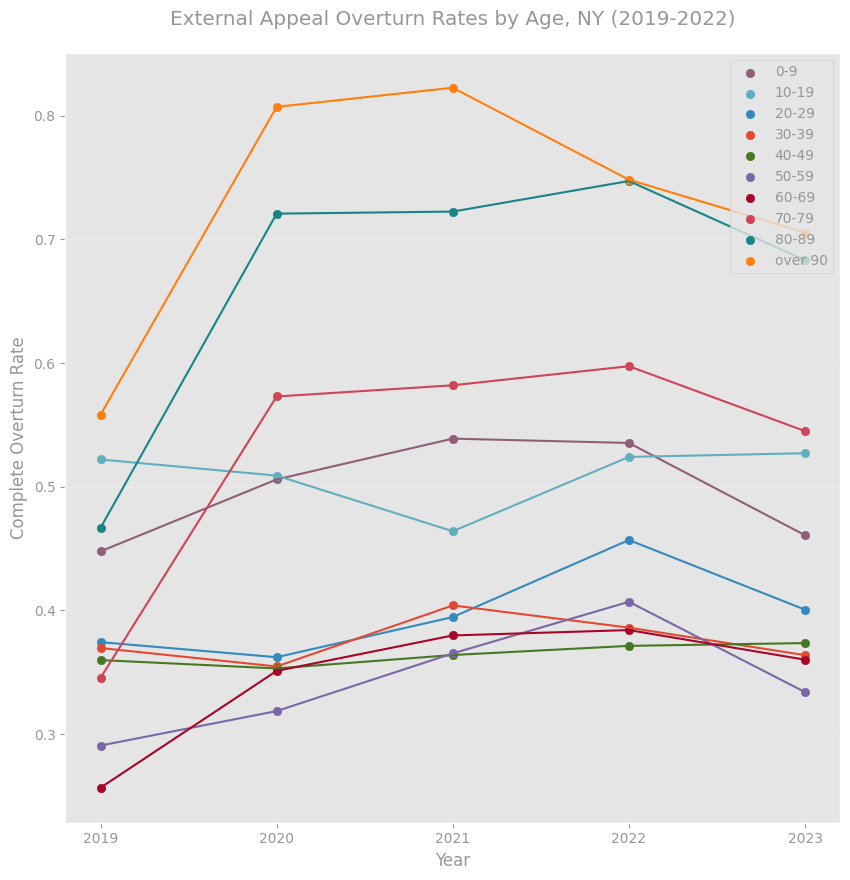

In [53]:
# Plot agent decision rates over time
fig, ax = plt.subplots(figsize=(10, 10))
x = sorted(list(df["Decision Year"].unique()))
if not NO_PLOT_TITLES:
    ax.set_title("External Appeal Overturn Rates by Age, NY (2019-2022)")
ax.set_ylabel("Complete Overturn Rate")
ax.set_xlabel("Year")
dates = np.asarray(x).astype(str)
for age in sorted_age_decision_data:
    age_timeseries = []
    for year in x:
        if age_decision_data[age].get(year, None):
            age_timeseries.append(
                age_decision_data[age][year]["complete_overturn_rate"]
            )
        else:
            age_timeseries.append(None)
    ax.scatter(dates, age_timeseries, label=age)
    ax.plot(dates, age_timeseries)
ax.legend()
save_path = os.path.join(OUTPUT_IMAGE_DIR, "external_appeal_overturn_rates_by_age.png")
plt.savefig(save_path, transparent=True, bbox_inches="tight")
plt.show()

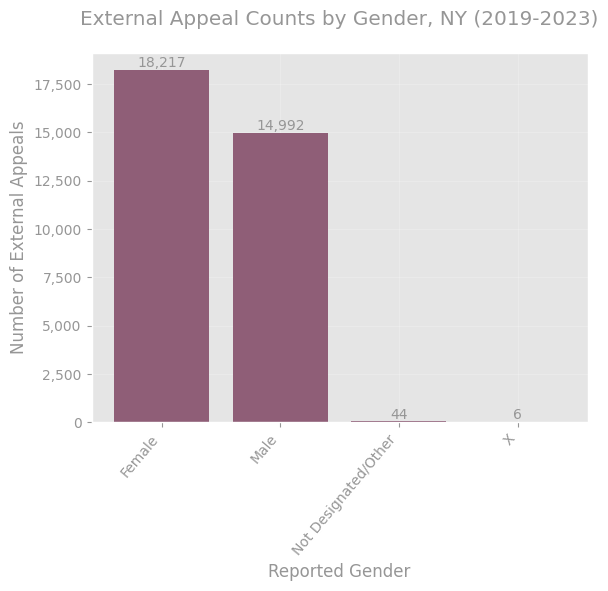

In [55]:
cat_val_counts = df["Gender"].value_counts()
bar_names, bar_vals = list(cat_val_counts.index), cat_val_counts.values
title = "External Appeal Counts by Gender, NY (2019-2023)"
val_axis_label = "Number of External Appeals"
cat_axis_label = "Reported Gender"
plot_bar(
    bar_names,
    bar_vals,
    title=title if not NO_PLOT_TITLES else None,
    val_axis_label=val_axis_label,
    cat_axis_label=cat_axis_label,
    save_path=os.path.join(OUTPUT_IMAGE_DIR, "external_appeal_counts_by_gender.png"),
    bar_label=True,
)

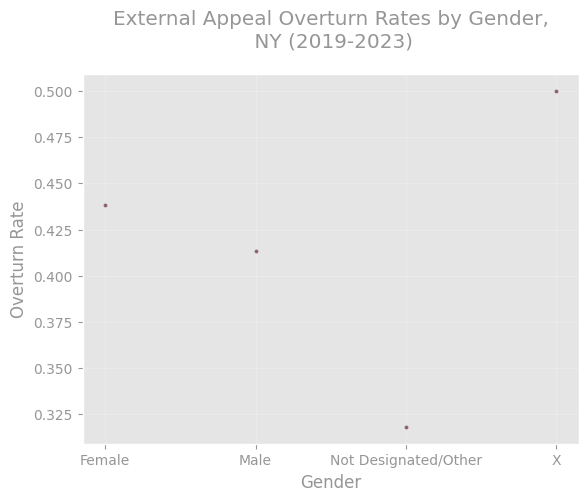

In [56]:
(cats, overturn_rates) = zip(
    *get_overturn_rates_by_categorical_col(
        df,
        "Gender",
        outcome_col_name="Appeal Decision",
        overturn_val="Overturned",
    )
)

title = "External Appeal Overturn Rates by Gender,\n NY (2019-2023)"
y_label = "Overturn Rate"
x_label = "Gender"

fig, ax = plt.subplots()
ax.scatter(cats, overturn_rates, s=5)
ax.set_title(title)
ax.set_ylabel(y_label)
ax.set_xlabel(x_label)
plt.show()

In [57]:
# Success rate by gender
gender_decision_data = get_overturn_rates_by_category(
    df, cat_col="Gender", by_year=True
)

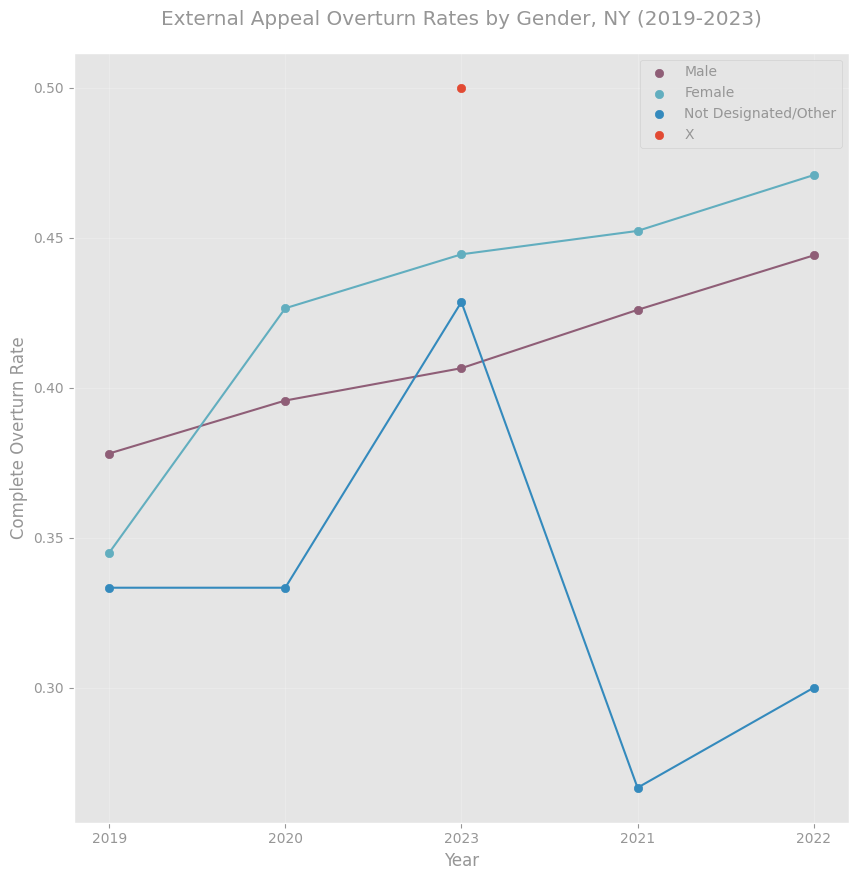

In [58]:
# Plot gender decision rates over time
fig, ax = plt.subplots(figsize=(10, 10))
x = list(df["Decision Year"].unique())
if not NO_PLOT_TITLES:
    ax.set_title("External Appeal Overturn Rates by Gender, NY (2019-2023)")
ax.set_ylabel("Complete Overturn Rate")
ax.set_xlabel("Year")
dates = np.asarray(x).astype(str)
for age in gender_decision_data:
    age_timeseries = []
    for year in x:
        if gender_decision_data[age].get(year, None):
            age_timeseries.append(
                gender_decision_data[age][year]["complete_overturn_rate"]
            )
        else:
            age_timeseries.append(None)
    ax.scatter(dates, age_timeseries, label=age)
    ax.plot(dates, age_timeseries)
ax.legend()
save_path = os.path.join(
    OUTPUT_IMAGE_DIR, "external_appeal_overturn_rates_by_gender.png"
)
plt.savefig(save_path, transparent=True, bbox_inches="tight")
plt.show()

In [77]:
name = "Crohn's Disease"
pattern = r"\b(?:crohn's)\b"
mask = np.column_stack(
    [
        df[col].str.contains(pattern, na=False, flags=re.IGNORECASE)
        for col in ["Diagnosis", "Treatment", "Summary 1"]
    ]
)
sub_df = df.loc[mask.any(axis=1)]
sub_df = sub_df.loc[sub_df["Coverage Type"] == 'Medicaid']
overturn_rate = get_overturn_rate(
    sub_df,
    outcome_col_name="Appeal Decision",
    overturn_val="Overturned",
)
print(
    f"{name}: {overturn_rate*100:.2f}% overturn rate among {len(sub_df)} external appeals.\n"
)
print("Data sample:")
sub_df.head()

Crohn's Disease: 66.34% overturn rate among 205 external appeals.

Data sample:


Case Number                             Diagnosis   
221   201912-124328  [Digestive System/ Gastrointestinal]  \
487   201907-119047  [Digestive System/ Gastrointestinal]   
751   201904-116037  [Digestive System/ Gastrointestinal]   
780   201910-122344  [Digestive System/ Gastrointestinal]   
1103  201908-119733  [Digestive System/ Gastrointestinal]   

                           Treatment            Health Plan Coverage Type   
221   [Pharmacy/ Prescription Drugs]  Fidelis Care New York      Medicaid  \
487               [Medical Supplies]  Fidelis Care New York      Medicaid   
751             [Inpatient Hospital]       Healthfirst Inc.      Medicaid   
780               [Infusion Therapy]               Excellus      Medicaid   
1103  [Pharmacy/ Prescription Drugs]  Fidelis Care New York      Medicaid   

     Appeal Decision      Denial Reason  Gender Age Range  Decision Year   
221       Overturned  Medical necessity    Male       0-9           2020  \
487           Upheld  Medical necessity    Male     10-19           2019   
751           Upheld  Medical necessity  Female       0-9           2019   
780           Upheld  Medical necessity    Male     10-19           2020   
1103          Upheld  Medical necessity    Male     50-59           2019   

        Agent                                                    Summary 1   
221   IMEDECS  This is a patient under evaluation and management for Cr...  \
487      IPRO  Diagnosis: Crohn's Disease\n \nTreatment: Medication- Hu...   
751      IPRO  Diagnosis: Abdominal pain, Crohn's disease\n\nTreatment:...   
780      IPRO  Diagnosis: Granulomatous Gastrointestinal (GI) Inflammat...   
1103     MCMC  Diagnosis: Crohn's disease\nIssue under review: Stelara\...   

     Summary 2 Summary 3 Summary 4   
221        NaN       NaN       NaN  \
487        NaN       NaN       NaN   
751        NaN       NaN       NaN   
780        NaN       NaN       NaN   
1103       NaN       NaN       NaN   

                                                     References 1   
221   1) Adedokun OJ, Xu Z, Gasink C, et al. Pharmacokinetics ...  \
487   1) Kotlyar DS, Osterman MT, Diamond RH, Porter D, Blonsk...   
751   1) Scholer SJ, Pituch K, Orr DP, Dittus RS. Clinical out...   
780   1)\tArmuzzi, A., & Felice, C. (2014). IBD: Infliximab do...   
1103  1) Singh S. et al. Primary Non-Response to Tumor Necrosi...   

     References 2 References 3 References 4 AgeRange  
221           NaN          NaN          NaN      0-9  
487           NaN          NaN          NaN    10-19  
751           NaN          NaN          NaN      0-9  
780           NaN          NaN          NaN    10-19  
1103          NaN          NaN          NaN    50-59

In [78]:
name = "Ulcerative Colitis"
pattern = r"\b(?:uc|ulcerative colitis)\b"
mask = np.column_stack(
    [
        df[col].str.contains(pattern, na=False, flags=re.IGNORECASE)
        for col in ["Diagnosis", "Treatment", "Summary 1"]
    ]
)
sub_df = df.loc[mask.any(axis=1)]
sub_df = sub_df.loc[sub_df["Coverage Type"] == 'Medicaid']
overturn_rate = get_overturn_rate(
    sub_df,
    outcome_col_name="Appeal Decision",
    overturn_val="Overturned",
)
print(
    f"{name}: {overturn_rate*100:.2f}% overturn rate among {len(sub_df)} external appeals.\n"
)
print("Data sample:")
sub_df.head()

Ulcerative Colitis: 52.34% overturn rate among 107 external appeals.

Data sample:


Case Number                             Diagnosis   
409   201907-119074                  [Respiratory System]  \
1153  201908-119706  [Digestive System/ Gastrointestinal]   
2297  201908-120567                     [Dental Problems]   
3199  201912-123603  [Digestive System/ Gastrointestinal]   
3247  201911-122988  [Digestive System/ Gastrointestinal]   

                            Treatment                             Health Plan   
409              [Inpatient Hospital]  Empire BlueCross BlueShield HealthPlus  \
1153   [Pharmacy/ Prescription Drugs]                   Fidelis Care New York   
2297  [Dental/ Orthodontic Procedure]                        Healthfirst Inc.   
3199   [Pharmacy/ Prescription Drugs]                   Fidelis Care New York   
3247   [Pharmacy/ Prescription Drugs]  Empire BlueCross BlueShield HealthPlus   

     Coverage Type Appeal Decision      Denial Reason  Gender Age Range   
409       Medicaid          Upheld  Medical necessity    Male     50-59  \
1153      Medicaid      Overturned  Medical necessity    Male       0-9   
2297      Medicaid          Upheld  Medical necessity  Female     10-19   
3199      Medicaid      Overturned  Medical necessity  Female     30-39   
3247      Medicaid          Upheld       Step Therapy  Female     20-29   

      Decision Year    Agent   
409            2019  IMEDECS  \
1153           2019  IMEDECS   
2297           2019  IMEDECS   
3199           2019     MCMC   
3247           2019  IMEDECS   

                                                        Summary 1 Summary 2   
409   \nThe patient has a past medical history significant for...       NaN  \
1153  This patient is a pediatric patient with a history of ul...       NaN   
2297  This is a patient with a skeletal Class I molar occlusio...       NaN   
3199  Diagnosis: Ulcerative colitis\nIssue under review: Stela...       NaN   
3247  This is a patient under management for ulcerative coliti...       NaN   

     Summary 3 Summary 4   
409        NaN       NaN  \
1153       NaN       NaN   
2297       NaN       NaN   
3199       NaN       NaN   
3247       NaN       NaN   

                                                     References 1   
409   1) Hemoptysis, Noah Lechtzin, MD. April 2018, Merck Manu...  \
1153  1) Gastroenterology Dose escalation of biologics in Croh...   
2297  1) Parker WS. The HLD (CalMod) index and the index quest...   
3199  1) Khorrami S1, Ginard D, Marín-Jiménez I, Chaparro M, S...   
3247  1) Rubin DT, Ananthakrishnan AN, Siegel CA, et al. ACG C...   

     References 2 References 3 References 4 AgeRange  
409           NaN          NaN          NaN    50-59  
1153          NaN          NaN          NaN      0-9  
2297          NaN          NaN          NaN    10-19  
3199          NaN          NaN          NaN    30-39  
3247          NaN          NaN          NaN    20-29

In [80]:
name = "Gender Identity"
pattern = r"\b(?:gender|affirming|transgender|dysphoria|sex change)\b"
mask = np.column_stack(
    [
        df[col].str.contains(pattern, na=False, flags=re.IGNORECASE)
        for col in [
            "Diagnosis",
            "Treatment",
            # "Summary 1"
        ]
    ]
)
sub_df = df.loc[mask.any(axis=1)]
sub_df = sub_df.loc[sub_df["Coverage Type"] == 'Medicaid']
overturn_rate = get_overturn_rate(
    sub_df,
    outcome_col_name="Appeal Decision",
    overturn_val="Overturned",
)
print(
    f"{name}: {overturn_rate*100:.2f}% overturn rate among {len(sub_df)} external appeals.\n"
)
print("Data sample:")
sub_df.head()

Gender Identity: 36.84% overturn rate among 19 external appeals.

Data sample:


Case Number           Diagnosis                       Treatment   
5240   202008-130472  [Gender Dysphoria]             [Surgical Services]  \
5353   202008-130813  [Gender Dysphoria]  [Pharmacy/ Prescription Drugs]   
8410   202009-131537  [Gender Dysphoria]  [Pharmacy/ Prescription Drugs]   
8503   202009-131146  [Gender Dysphoria]  [Pharmacy/ Prescription Drugs]   
12478  202103-136051  [Gender Dysphoria]             [Surgical Services]   

            Health Plan Coverage Type Appeal Decision           Denial Reason   
5240   Healthfirst Inc.      Medicaid          Upheld       Medical necessity  \
5353   Healthfirst Inc.      Medicaid          Upheld     Formulary Exception   
8410   Healthfirst Inc.      Medicaid      Overturned     Formulary Exception   
8503   Healthfirst Inc.      Medicaid          Upheld     Formulary Exception   
12478  Amida Care, Inc.      Medicaid      Overturned  Out-of-Network Service   

       Gender Age Range  Decision Year    Agent   
5240     Male     20-29           2020  IMEDECS  \
5353   Female     30-39           2020  IMEDECS   
8410   Female     30-39           2020     IPRO   
8503   Female     30-39           2020     MCMC   
12478  Female     30-39           2021  IMEDECS   

                                                         Summary 1 Summary 2   
5240   Diagnosis:Gender Dysphoria\nTreatment:Surgical services\...       NaN  \
5353   Diagnosis:  Transsexualism.\nTreatment:  Pharmacy/Prescr...       NaN   
8410   Diagnosis:  Gender dysphoria.\nTreatment:  Estradiol val...       NaN   
8503   Diagnosis: Transgender hormone therapy\nTreatment: Formu...       NaN   
12478  Diagnosis: Gender Dysphoria/Gender Dysphoria\nTreatment:...       NaN   

      Summary 3 Summary 4   
5240        NaN       NaN  \
5353        NaN       NaN   
8410        NaN       NaN   
8503        NaN       NaN   
12478       NaN       NaN   

                                                      References 1   
5240   1)\tFemale-to-Male Gender-Affirming Chest Reconstruction...  \
5353   1)  Hembree, W. Et al. Endocrine Treatment of Gender-Dys...   
8410   1)  Fernandez, J.D., et al. (2019).  "Assessment of Gend...   
8503   1) T'Sjoen G et al, Endocrinology of Transgender Medicin...   
12478  1) Manrique OJ, Sabbagh MD, Ciudad P, Martinez-Jorge J, ...   

      References 2 References 3 References 4 AgeRange  
5240           NaN          NaN          NaN    20-29  
5353           NaN          NaN          NaN    30-39  
8410           NaN          NaN          NaN    30-39  
8503           NaN          NaN          NaN    30-39  
12478          NaN          NaN          NaN    30-39

In [81]:
name = "HIV/AIDS"
pattern = r"\b(?:HIV|AIDS)\b"
mask = np.column_stack(
    [
        df[col].str.contains(pattern, na=False, flags=re.IGNORECASE)
        for col in ["Diagnosis", "Treatment", "Summary 1"]
    ]
)
sub_df = df.loc[mask.any(axis=1)]
sub_df = sub_df.loc[sub_df["Coverage Type"] == 'Medicaid']
overturn_rate = get_overturn_rate(
    sub_df,
    outcome_col_name="Appeal Decision",
    overturn_val="Overturned",
)
print(
    f"{name}: {overturn_rate*100:.2f}% overturn rate among {len(sub_df)} external appeals.\n"
)
print("Data sample:")
sub_df.head()

HIV/AIDS: 32.95% overturn rate among 173 external appeals.

Data sample:


Case Number                             Diagnosis   
254   201907-119237          [Substance Abuse/ Addiction]  \
770   201905-116765                       [Mental Health]   
830   201905-117449  [Digestive System/ Gastrointestinal]   
1486  201905-117074   [Endocrine/ Metabolic/ Nutritional]   
1619  201906-118092                  [Ears/ Nose/ Throat]   

                                                        Treatment   
254                                  [Substance Abuse: Inpatient]  \
770                                          [Inpatient Hospital]   
830                                          [Inpatient Hospital]   
1486  [Diabetic Equipment, Supplies and Self-Management Educat...   
1619                                               [Hearing Aids]   

                                 Health Plan Coverage Type Appeal Decision   
254                    Fidelis Care New York      Medicaid          Upheld  \
770                    Fidelis Care New York      Medicaid          Upheld   
830   Empire BlueCross BlueShield HealthPlus      Medicaid          Upheld   
1486                   Fidelis Care New York      Medicaid      Overturned   
1619                   Fidelis Care New York      Medicaid      Overturned   

          Denial Reason  Gender Age Range  Decision Year    Agent   
254   Medical necessity    Male     50-59           2019  IMEDECS  \
770   Medical necessity    Male     30-39           2019  IMEDECS   
830   Medical necessity    Male     20-29           2019  IMEDECS   
1486  Medical necessity  Female     50-59           2019  IMEDECS   
1619  Medical necessity  Female     20-29           2019  IMEDECS   

                                                        Summary 1 Summary 2   
254   This is a male who was admitted for inpatient detoxifica...       NaN  \
770   The patient has past diagnoses of depression, post-traum...       NaN   
830   The patient has a history of human immunodeficiency viru...       NaN   
1486  The patient has type 2 diabetes, HIV with AIDS.  Patient...       NaN   
1619  The patient has hearing loss.  The patient has difficult...       NaN   

     Summary 3 Summary 4   
254        NaN       NaN  \
770        NaN       NaN   
830        NaN       NaN   
1486       NaN       NaN   
1619       NaN       NaN   

                                                     References 1   
254   1) Dugosh KL, Cacciola JS, Saxon AJ. Clinical assessment...  \
770   1)  American Psychiatric Association Practice Guideline ...   
830   1) Bányai K, Estes MK, et al. Viral gastroenteritis. Lan...   
1486  1) FDA, CGMS approval. Accessed at: http: //www.fda.gov/...   
1619  1)  http://www.entnet.org/Practice/policyHearingAidEvalu...   

     References 2 References 3 References 4 AgeRange  
254           NaN          NaN          NaN    50-59  
770           NaN          NaN          NaN    30-39  
830           NaN          NaN          NaN    20-29  
1486          NaN          NaN          NaN    50-59  
1619          NaN          NaN          NaN    20-29

In [83]:
pd.set_option('display.max_colwidth', 60)
name = "Sickle Cell"
pattern = r"\b(?:sickle cell)\b"
mask = np.column_stack(
    [
        df[col].str.contains(pattern, na=False, flags=re.IGNORECASE)
        for col in ["Summary 1", "Summary 2", "Summary 3"]
    ]
)
sub_df = df.loc[mask.any(axis=1)]
sub_df = sub_df.loc[sub_df["Coverage Type"] == 'Medicaid']
sub_df = sub_df.loc[sub_df["Diagnosis"]=='[Blood Disorder]']
overturn_rate = get_overturn_rate(
    sub_df,
    outcome_col_name="Appeal Decision",
    overturn_val="Overturned",
)
print(
    f"{name}: {overturn_rate*100:.2f}% overturn rate among {len(sub_df)} external appeals.\n"
)
print("Data sample:")
sub_df.head()

Sickle Cell: 32.14% overturn rate among 112 external appeals.

Data sample:


Case Number         Diagnosis             Treatment   
15   201906-117774  [Blood Disorder]  [Inpatient Hospital]  \
271  201907-119234  [Blood Disorder]  [Inpatient Hospital]   
374  201907-119094  [Blood Disorder]  [Inpatient Hospital]   
495  201907-119347  [Blood Disorder]  [Inpatient Hospital]   
533  201904-115851  [Blood Disorder]  [Inpatient Hospital]   

                                Health Plan Coverage Type Appeal Decision   
15   Empire BlueCross BlueShield HealthPlus      Medicaid      Overturned  \
271                        Healthfirst Inc.      Medicaid      Overturned   
374  Empire BlueCross BlueShield HealthPlus      Medicaid      Overturned   
495                    Affinity Health Plan      Medicaid          Upheld   
533                    Affinity Health Plan      Medicaid      Overturned   

         Denial Reason  Gender Age Range  Decision Year    Agent   
15   Medical necessity  Female     10-19           2019     IPRO  \
271  Medical necessity  Female     20-29           2019  IMEDECS   
374  Medical necessity    Male     10-19           2019     MCMC   
495  Medical necessity    Male     30-39           2019     IPRO   
533  Medical necessity    Male     30-39           2019     MCMC   

                                                       Summary 1 Summary 2   
15   Diagnosis: Vaso-occlusive Sickle Cell Disease Crisis\n \...       NaN  \
271  The patient is a female who presented to the hospital wi...       NaN   
374  Diagnosis: Pain due to Sickle Cell\nTreatment: Inpatient...       NaN   
495  Diagnosis: Sickle cell crisis\n \nTreatment: Inpatient a...       NaN   
533  Diagnosis: Sickle cell disease\nTreatment: Inpatient sta...       NaN   

    Summary 3 Summary 4   
15        NaN       NaN  \
271       NaN       NaN   
374       NaN       NaN   
495       NaN       NaN   
533       NaN       NaN   

                                                    References 1 References 2   
15   1)\tCochrane Database Syst Rev. 2017 Nov; 2017(11): CD00...          NaN  \
271  1) Patrick T. McGann, Alecia C. Nero, Russell E. Ware. C...          NaN   
374  1) Nelson Textbook of Pediatrics, 20th Edition. RM Kleig...          NaN   
495  1) MCG Health, 22nd ed. (2018). Sickle Cell Disease.ORG:...          NaN   
533  1) 2018 InterQual Level of Care Guidelines.\n\n2) 2018 C...          NaN   

    References 3 References 4 AgeRange  
15           NaN          NaN    10-19  
271          NaN          NaN    20-29  
374          NaN          NaN    10-19  
495          NaN          NaN    30-39  
533          NaN          NaN    30-39

In [84]:
name = "Tay sachs"
pattern = r"\b(?:tay-sachs)\b"
mask = np.column_stack(
    [
        df[col].str.contains(pattern, na=False, flags=re.IGNORECASE)
        for col in ["Summary 1", "Summary 2", "Summary 3"]
    ]
)
sub_df = df.loc[mask.any(axis=1)]
sub_df = sub_df.loc[sub_df["Coverage Type"] == 'Medicaid']
overturn_rate = get_overturn_rate(
    sub_df,
    outcome_col_name="Appeal Decision",
    overturn_val="Overturned",
)
print(
    f"{name}: {overturn_rate*100:.2f}% overturn rate among {len(sub_df)} external appeals.\n"
)
print("Data sample:")
sub_df.head()

Tay sachs: -100.00% overturn rate among 0 external appeals.

Data sample:


Empty DataFrame
Columns: [Case Number, Diagnosis, Treatment, Health Plan, Coverage Type, Appeal Decision, Denial Reason, Gender, Age Range, Decision Year, Agent, Summary 1, Summary 2, Summary 3, Summary 4, References 1, References 2, References 3, References 4, AgeRange]
Index: []

In [89]:
name = "Hysterectomy"
pattern = r"\b(?:hysterectomy)\b"
mask = np.column_stack(
    [
        df[col].str.contains(pattern, na=False, flags=re.IGNORECASE)
        for col in ["Summary 1", "Summary 2", "Summary 3"]
    ]
)
sub_df = df.loc[mask.any(axis=1)]
sub_df = sub_df.loc[sub_df["Diagnosis"]=='[Gynecological]']
sub_df = sub_df.loc[sub_df["Coverage Type"] == 'Medicaid']
overturn_rate = get_overturn_rate(
    sub_df,
    outcome_col_name="Appeal Decision",
    overturn_val="Overturned",
)
print(
    f"{name}: {overturn_rate*100:.2f}% overturn rate among {len(sub_df)} external appeals.\n"
)
print("Data sample:")
sub_df.head()

Hysterectomy: 26.76% overturn rate among 71 external appeals.

Data sample:


Case Number        Diagnosis             Treatment   
1323  201905-117036  [Gynecological]  [Inpatient Hospital]  \
1765  201906-118021  [Gynecological]  [Inpatient Hospital]   
2001  202001-124438  [Gynecological]  [Inpatient Hospital]   
2737  201908-120099  [Gynecological]  [Inpatient Hospital]   
3146  201911-123048  [Gynecological]  [Inpatient Hospital]   

                                 Health Plan Coverage Type Appeal Decision   
1323                        Healthfirst Inc.      Medicaid          Upheld  \
1765                        Healthfirst Inc.      Medicaid          Upheld   
2001  Empire BlueCross BlueShield HealthPlus      Medicaid          Upheld   
2737                   Fidelis Care New York      Medicaid      Overturned   
3146                        Healthfirst Inc.      Medicaid          Upheld   

          Denial Reason  Gender Age Range  Decision Year    Agent   
1323  Medical necessity  Female     40-49           2019  IMEDECS  \
1765  Medical necessity  Female     30-39           2019     MCMC   
2001  Medical necessity  Female     40-49           2020  IMEDECS   
2737  Medical necessity  Female     40-49           2019     MCMC   
3146  Medical necessity  Female     30-39           2019     IPRO   

                                                        Summary 1 Summary 2   
1323  This is a patient with pelvic pain and an ovarian cyst. ...       NaN  \
1765  Diagnosis: Uterine fibroids and pelvic pain\nTreatment: ...       NaN   
2001  Gynecological\nInpatient stay\n\nThis is the case of a p...       NaN   
2737  Diagnosis:  Fibroids\nTreatment:  Inpatient admission\nT...       NaN   
3146  Diagnosis: Pelvic pain and endometriosis\n\nTreatment: I...       NaN   

     Summary 3 Summary 4   
1323       NaN       NaN  \
1765       NaN       NaN   
2001       NaN       NaN   
2737       NaN       NaN   
3146       NaN       NaN   

                                                     References 1   
1323  1) MCG Gynecology. Inpatient Admission Guidelines. Lapar...  \
1765  1) Chapter 25 - Postoperative Counseling and Management:...   
2001  1)\tBottomley C, Bourne T. Diagnosis and management of o...   
2737  1)  Einarsson, Jon Ivar MD, MPH, PhD and Sarah L Cohen M...   
3146  1)\tMilliman Care Guidelines: Inpatient and Surgical Car...   

     References 2 References 3 References 4 AgeRange  
1323          NaN          NaN          NaN    40-49  
1765          NaN          NaN          NaN    30-39  
2001          NaN          NaN          NaN    40-49  
2737          NaN          NaN          NaN    40-49  
3146          NaN          NaN          NaN    30-39

In [92]:
name = "Leukemia"
pattern = r"\b(?:leukemia|lymphoma)\b"
mask = np.column_stack(
    [
        df[col].str.contains(pattern, na=False, flags=re.IGNORECASE)
        for col in ["Summary 1", "Summary 2", "Summary 3"]
    ]
)
sub_df = df.loc[mask.any(axis=1)]
sub_df = sub_df.loc[sub_df["Coverage Type"] == 'Medicaid']
sub_df = sub_df.loc[sub_df["Diagnosis"]=='[Cancer]']
overturn_rate = get_overturn_rate(
    sub_df,
    outcome_col_name="Appeal Decision",
    overturn_val="Overturned",
)
print(
    f"{name}: {overturn_rate*100:.2f}% overturn rate among {len(sub_df)} external appeals.\n"
)
print("Data sample:")
sub_df.head()

Leukemia: 46.77% overturn rate among 62 external appeals.

Data sample:


Case Number Diagnosis                       Treatment   
27    201906-117755  [Cancer]  [Pharmacy/ Prescription Drugs]  \
758   202002-125400  [Cancer]              [Infusion Therapy]   
1679  201906-118064  [Cancer]  [Pharmacy/ Prescription Drugs]   
2614  201908-120033  [Cancer]            [Inpatient Hospital]   
3347  202002-126087  [Cancer]  [Pharmacy/ Prescription Drugs]   

                Health Plan Coverage Type Appeal Decision      Denial Reason   
27         Healthfirst Inc.      Medicaid          Upheld  Medical necessity  \
758   Fidelis Care New York      Medicaid          Upheld  Medical necessity   
1679  Fidelis Care New York      Medicaid          Upheld  Medical necessity   
2614  Fidelis Care New York      Medicaid      Overturned  Medical necessity   
3347  Fidelis Care New York      Medicaid          Upheld  Medical necessity   

      Gender Age Range  Decision Year    Agent   
27      Male     20-29           2019  IMEDECS  \
758     Male     30-39           2020     MCMC   
1679    Male     60-69           2019     MCMC   
2614  Female       0-9           2019  IMEDECS   
3347    Male     40-49           2020     IPRO   

                                                        Summary 1 Summary 2   
27    This is patient who had undergone an allogeneic stem cel...       NaN  \
758   Diagnosis:  Acute Myeloblastic Leukemia (AML)\nIssue und...       NaN   
1679  Diagnosis: Acute Myelogenous Leukemia; Chronic graft ver...       NaN   
2614  This is a patient who presented to the hospital with a f...       NaN   
3347  Diagnosis: Cerebellar glioblastoma \n\nTreatment: Verzen...       NaN   

     Summary 3 Summary 4   
27         NaN       NaN  \
758        NaN       NaN   
1679       NaN       NaN   
2614       NaN       NaN   
3347       NaN       NaN   

                                                     References 1   
27    1) Ethier MC, Science M, Beyene J, et al. Mould-active c...  \
758   1)  Daver N, Kantarjian H, Ravandi F, et al. A phase II ...   
1679  1) https://www.accessdata.fda.gov/drugsatfda_docs/label/...   
2614  1) Lehrnbecher T. Treatment of fever in neutropenia in p...   
3347  1)\tDowless, M., Lowery, C. D., & Shackleford, T., et al...   

     References 2 References 3 References 4 AgeRange  
27            NaN          NaN          NaN    20-29  
758           NaN          NaN          NaN    30-39  
1679          NaN          NaN          NaN    60-69  
2614          NaN          NaN          NaN      0-9  
3347          NaN          NaN          NaN    40-49

In [95]:
name = "Diabetes"
pattern = r"\b(?:type 2 diabetes)\b"
mask = np.column_stack(
    [
        df[col].str.contains(pattern, na=False, flags=re.IGNORECASE)
        for col in ["Summary 1", "Summary 2", "Summary 3"]
    ]
)
sub_df = df.loc[mask.any(axis=1)]
sub_df = sub_df.loc[sub_df["Coverage Type"] == 'Medicaid']
sub_df = sub_df.loc[sub_df["Diagnosis"]=='[Endocrine/ Metabolic/ Nutritional]']
overturn_rate = get_overturn_rate(
    sub_df,
    outcome_col_name="Appeal Decision",
    overturn_val="Overturned",
)
print(
    f"{name}: {overturn_rate*100:.2f}% overturn rate among {len(sub_df)} external appeals.\n"
)
print("Data sample:")
sub_df.head()

Diabetes: 55.10% overturn rate among 98 external appeals.

Data sample:


Case Number                            Diagnosis   
137   201905-116836  [Endocrine/ Metabolic/ Nutritional]  \
745   201904-116428  [Endocrine/ Metabolic/ Nutritional]   
1004  201905-117669  [Endocrine/ Metabolic/ Nutritional]   
1486  201905-117074  [Endocrine/ Metabolic/ Nutritional]   
1582  201906-117935  [Endocrine/ Metabolic/ Nutritional]   

                                                        Treatment   
137                                          [Inpatient Hospital]  \
745                                          [Inpatient Hospital]   
1004  [Durable Medical Equipment (DME) (including Wearable Def...   
1486  [Diabetic Equipment, Supplies and Self-Management Educat...   
1582                               [Pharmacy/ Prescription Drugs]   

                                 Health Plan Coverage Type Appeal Decision   
137   Empire BlueCross BlueShield HealthPlus      Medicaid          Upheld  \
745   Empire BlueCross BlueShield HealthPlus      Medicaid          Upheld   
1004                        Healthfirst Inc.      Medicaid      Overturned   
1486                   Fidelis Care New York      Medicaid      Overturned   
1582                   Fidelis Care New York      Medicaid      Overturned   

          Denial Reason  Gender Age Range  Decision Year    Agent   
137   Medical necessity  Female     60-69           2019     IPRO  \
745   Medical necessity    Male     60-69           2019  IMEDECS   
1004  Medical necessity    Male     40-49           2019     MCMC   
1486  Medical necessity  Female     50-59           2019  IMEDECS   
1582  Medical necessity    Male     60-69           2019     MCMC   

                                                        Summary 1 Summary 2   
137   Diagnoses:  type 2 diabetes mellitus with hypoglycemia w...       NaN  \
745   The patient has hypertension (HTN), chronic kidney disea...       NaN   
1004  Diagnosis: Diabetes\nIssue under review: Dexcom\n\nDeter...       NaN   
1486  The patient has type 2 diabetes, HIV with AIDS.  Patient...       NaN   
1582  Diagnosis: Diabetes\nIssue under review: Jardiance\n\nDe...       NaN   

     Summary 3 Summary 4   
137        NaN       NaN  \
745        NaN       NaN   
1004       NaN       NaN   
1486       NaN       NaN   
1582       NaN       NaN   

                                                     References 1   
137   1) MCG Health, Inpatient & Surgical Care, 23rd Edition, ...  \
745   1) MCG Health Inpatient & Surgical Care 22nd Edition Ren...   
1004  1)\tBeck RW, Riddlesworth TD, Ruedy K, Ahmann A, Haller ...   
1486  1) FDA, CGMS approval. Accessed at: http: //www.fda.gov/...   
1582  1)\tZinman B, Wanner C, Lachin JM, Fitchett D, Bluhmki E...   

     References 2 References 3 References 4 AgeRange  
137           NaN          NaN          NaN    60-69  
745           NaN          NaN          NaN    60-69  
1004          NaN          NaN          NaN    40-49  
1486          NaN          NaN          NaN    50-59  
1582          NaN          NaN          NaN    60-69

In [103]:
name = "Multiple Sclerosis"
pattern = r"\b(?:ms|multiple sclerosis)\b"
mask = np.column_stack(
    [
        df[col].str.contains(pattern, na=False, flags=re.IGNORECASE)
        for col in ["Summary 1", "Summary 2", "Summary 3"]
    ]
)
sub_df = df.loc[mask.any(axis=1)]
sub_df = sub_df.loc[sub_df["Coverage Type"] == 'Medicaid']
overturn_rate = get_overturn_rate(
    sub_df,
    outcome_col_name="Appeal Decision",
    overturn_val="Overturned",
)
print(
    f"{name}: {overturn_rate*100:.2f}% overturn rate among {len(sub_df)} external appeals.\n"
)
print("Data sample:")
sub_df.head()

Multiple Sclerosis: 31.30% overturn rate among 115 external appeals.

Data sample:


Case Number                                         Diagnosis   
521   201905-116733                                   [Mental Health]  \
1525  201905-117173  [Central Nervous System/ Neuromuscular Disorder]   
2148  201906-118268                      [Substance Abuse/ Addiction]   
2359  201909-120794  [Central Nervous System/ Neuromuscular Disorder]   
2687  201908-120316                     [Orthopedic/ Musculoskeletal]   

                       Treatment                             Health Plan   
521   [Mental Health: Inpatient]                   Fidelis Care New York  \
1525        [Inpatient Hospital]                        Healthfirst Inc.   
2148        [Inpatient Hospital]                        Healthfirst Inc.   
2359          [Home Health Care]                        Healthfirst Inc.   
2687        [Inpatient Hospital]  Empire BlueCross BlueShield HealthPlus   

     Coverage Type Appeal Decision      Denial Reason  Gender Age Range   
521       Medicaid          Upheld  Medical necessity  Female     50-59  \
1525      Medicaid          Upheld  Medical necessity    Male     20-29   
2148      Medicaid      Overturned  Medical necessity    Male     50-59   
2359      Medicaid          Upheld  Medical necessity  Female     40-49   
2687      Medicaid          Upheld  Medical necessity  Female     40-49   

      Decision Year    Agent   
521            2019     IPRO  \
1525           2019  IMEDECS   
2148           2019     IPRO   
2359           2019  IMEDECS   
2687           2019     IPRO   

                                                        Summary 1 Summary 2   
521   Diagnosis: Suicide Attempt\n \nTreatment: Inpatient admi...       NaN  \
1525  This is a male patient with progressive right-sided weak...       NaN   
2148  Diagnosis: Alcohol Abuse, alcohol withdrawal\n \nTreatme...       NaN   
2359  The patient is a female with a listed diagnosis of multi...       NaN   
2687  Diagnosis: Knee Pain \n \nTreatment: Inpatient Admission...       NaN   

     Summary 3 Summary 4   
521        NaN       NaN  \
1525       NaN       NaN   
2148       NaN       NaN   
2359       NaN       NaN   
2687       NaN       NaN   

                                                     References 1   
521   1) American Psychiatric Association Practice Guidelines ...  \
1525  1) Berkovich RR. Acute Multiple Sclerosis Relapse. Conti...   
2148  1) American Psychiatric Association Practice Guidelines ...   
2359  1) Donzé C. Update on rehabilitation in multiple scleros...   
2687  1) MCG, 23rd Edition, General Recovery Care > Body Syste...   

     References 2 References 3 References 4 AgeRange  
521           NaN          NaN          NaN    50-59  
1525          NaN          NaN          NaN    20-29  
2148          NaN          NaN          NaN    50-59  
2359          NaN          NaN          NaN    40-49  
2687          NaN          NaN          NaN    40-49

In [105]:
name = "Parkinson's"
pattern = r"\b(?:parkinson|parkinson's)\b"
mask = np.column_stack(
    [
        df[col].str.contains(pattern, na=False, flags=re.IGNORECASE)
        for col in ["Summary 1", "Summary 2", "Summary 3"]
    ]
)
sub_df = df.loc[mask.any(axis=1)]
sub_df = sub_df.loc[sub_df["Coverage Type"] == 'Medicaid']
overturn_rate = get_overturn_rate(
    sub_df,
    outcome_col_name="Appeal Decision",
    overturn_val="Overturned",
)
print(
    f"{name}: {overturn_rate*100:.2f}% overturn rate among {len(sub_df)} external appeals.\n"
)
print("Data sample:")
sub_df.head()

Parkinson's: 56.19% overturn rate among 105 external appeals.

Data sample:


Case Number                                         Diagnosis   
848   201905-117360                   [Cardiac/ Circulatory Problems]  \
1088  201907-119604                   [Cardiac/ Circulatory Problems]   
1412  201905-117335                   [Cardiac/ Circulatory Problems]   
1936  201907-118859  [Central Nervous System/ Neuromuscular Disorder]   
1938  201907-118858  [Central Nervous System/ Neuromuscular Disorder]   

                 Treatment            Health Plan Coverage Type   
848   [Inpatient Hospital]       Healthfirst Inc.      Medicaid  \
1088  [Inpatient Hospital]  Fidelis Care New York      Medicaid   
1412  [Inpatient Hospital]   Affinity Health Plan      Medicaid   
1936  [Inpatient Hospital]       Healthfirst Inc.      Medicaid   
1938  [Inpatient Hospital]       Healthfirst Inc.      Medicaid   

     Appeal Decision      Denial Reason  Gender Age Range  Decision Year   
848       Overturned  Medical necessity  Female     50-59           2019  \
1088          Upheld  Medical necessity    Male     40-49           2019   
1412      Overturned  Medical necessity    Male     20-29           2019   
1936          Upheld  Medical necessity    Male     80-89           2019   
1938          Upheld  Medical necessity    Male     80-89           2019   

        Agent                                                    Summary 1   
848      IPRO  Diagnosis: Decompensated CHF with ongoing cardiac ischem...  \
1088  IMEDECS  The patient with body mass index (BMI) of 35 and family ...   
1412     MCMC  Diagnosis: Syncope\nTreatment: Inpatient admission\nThe ...   
1936     IPRO  Diagnosis: Syncopal Episode  \n\nTreatment: Inpatient Ad...   
1938     IPRO  Diagnosis: Syncopal Episode\n \nTreatment: Inpatient Adm...   

     Summary 2 Summary 3 Summary 4   
848        NaN       NaN       NaN  \
1088       NaN       NaN       NaN   
1412       NaN       NaN       NaN   
1936       NaN       NaN       NaN   
1938       NaN       NaN       NaN   

                                                     References 1   
848   1) Theo E Meyer MD. "Approach to Acute Decompensated HF ...  \
1088  1) 2014 ACC/AHA/AATS/PCNA/SCAI/STS focused update of the...   
1412  1) Numeroso F. et al. Short-term Prognosis and Current M...   
1936  1)\tHuff JS, Decker WW, Quinn JV, et al.  "Clinical Poli...   
1938  1)\tMCG Guidelines, 20th Edition - General Admission Cri...   

     References 2 References 3 References 4 AgeRange  
848           NaN          NaN          NaN    50-59  
1088          NaN          NaN          NaN    40-49  
1412          NaN          NaN          NaN    20-29  
1936          NaN          NaN          NaN    80-89  
1938          NaN          NaN          NaN    80-89

In [128]:
name = "Asthma"
pattern = r"\b(?:asthma)\b"
mask = np.column_stack(
    [
        df[col].str.contains(pattern, na=False, flags=re.IGNORECASE)
        for col in ["Summary 1", "Summary 2", "Summary 3"]
    ]
)
sub_df = df.loc[mask.any(axis=1)]
sub_df = sub_df.loc[sub_df["Coverage Type"] == 'HMO']
overturn_rate = get_overturn_rate(
    sub_df,
    outcome_col_name="Appeal Decision",
    overturn_val="Overturned",
)
print(
    f"{name}: {overturn_rate*100:.2f}% overturn rate among {len(sub_df)} external appeals.\n"
)
print("Data sample:")
sub_df.head()

Asthma: 29.19% overturn rate among 394 external appeals.

Data sample:


Case Number                         Diagnosis             Treatment   
47   201906-117732              [Infectious Disease]  [Inpatient Hospital]  \
50   201906-117729              [Respiratory System]  [Inpatient Hospital]   
97   201908-119932                          [Cancer]  [Inpatient Hospital]   
132  201905-116844   [Cardiac/ Circulatory Problems]  [Inpatient Hospital]   
195  201907-119435  [Genitourinary/ Kidney Disorder]  [Inpatient Hospital]   

                            Health Plan Coverage Type Appeal Decision   
47                Metroplus Health Plan           HMO          Upheld  \
50                Metroplus Health Plan           HMO          Upheld   
97         Empire Healthchoice HMO Inc.           HMO          Upheld   
132               Metroplus Health Plan           HMO          Upheld   
195  United Healthcare Plan of New York           HMO      Overturned   

         Denial Reason  Gender Age Range  Decision Year    Agent   
47   Medical necessity  Female     40-49           2019     IPRO  \
50   Medical necessity  Female     60-69           2019  IMEDECS   
97   Medical necessity    Male     60-69           2019     IPRO   
132  Medical necessity    Male     60-69           2019  IMEDECS   
195  Medical necessity  Female     40-49           2019     IPRO   

                                                       Summary 1 Summary 2   
47   Diagnosis: Viral syndrome\n \nTreatment: Inpatient admis...       NaN  \
50   The patient is a female, with a history of asthma and pr...       NaN   
97   Diagnosis: Sarcoma with Lung Metastasis\nTreatment: Inpa...       NaN   
132  The patient has a past medical history significant for h...       NaN   
195  Diagnosis: Right-sided flank pain and groin pain\n \nTre...       NaN   

    Summary 3 Summary 4   
47        NaN       NaN  \
50        NaN       NaN   
97        NaN       NaN   
132       NaN       NaN   
195       NaN       NaN   

                                                    References 1 References 2   
47   1) Kaakoush NO, Mitchell HM, Man SM. Role of emerging Ca...          NaN  \
50   1)\tTabatabai RR, Gruber PF. Chronic obstructive pulmona...          NaN   
97   1)  MCG, 23rd Edition, General Recovery Care > Problem O...          NaN   
132  1) Pritchett EL. Management of atrial fibrillation. N En...          NaN   
195  1)\tMilliman Care Guidelines, 23rd Edition, Inpatient & ...          NaN   

    References 3 References 4 AgeRange  
47           NaN          NaN    40-49  
50           NaN          NaN    60-69  
97           NaN          NaN    60-69  
132          NaN          NaN    60-69  
195          NaN          NaN    40-49

In [106]:
name = "Asthma"
pattern = r"\b(?:asthma)\b"
mask = np.column_stack(
    [
        df[col].str.contains(pattern, na=False, flags=re.IGNORECASE)
        for col in ["Summary 1", "Summary 2", "Summary 3"]
    ]
)
sub_df = df.loc[mask.any(axis=1)]
sub_df = sub_df.loc[sub_df["Coverage Type"] == 'Medicaid']
overturn_rate = get_overturn_rate(
    sub_df,
    outcome_col_name="Appeal Decision",
    overturn_val="Overturned",
)
print(
    f"{name}: {overturn_rate*100:.2f}% overturn rate among {len(sub_df)} external appeals.\n"
)
print("Data sample:")
sub_df.head()

Asthma: 38.85% overturn rate among 1310 external appeals.

Data sample:


Case Number                            Diagnosis   
35   201906-117743                 [Respiratory System]  \
85   201908-119950  [Endocrine/ Metabolic/ Nutritional]   
143  201905-116826  [Endocrine/ Metabolic/ Nutritional]   
161  201905-116880                 [Respiratory System]   
177  201907-119462                 [Respiratory System]   

                          Treatment            Health Plan Coverage Type   
35             [Inpatient Hospital]       Healthfirst Inc.      Medicaid  \
85   [Pharmacy/ Prescription Drugs]  Fidelis Care New York      Medicaid   
143            [Inpatient Hospital]       Healthfirst Inc.      Medicaid   
161            [Inpatient Hospital]       Healthfirst Inc.      Medicaid   
177            [Inpatient Hospital]       Healthfirst Inc.      Medicaid   

    Appeal Decision      Denial Reason  Gender Age Range  Decision Year Agent   
35           Upheld  Medical necessity  Female     70-79           2019  MCMC  \
85           Upheld  Medical necessity    Male     10-19           2019  IPRO   
143          Upheld  Medical necessity  Female     20-29           2019  IPRO   
161          Upheld  Medical necessity  Female     20-29           2019  IPRO   
177          Upheld  Medical necessity  Female     60-69           2019  MCMC   

                                                       Summary 1 Summary 2   
35   Diagnosis: Shortness of breath and wheezing\n\nTreatment...       NaN  \
85   Diagnosis: Small Gestational Age\nTreatment: Norditropin...       NaN   
143  Diagnosis: Diabetes Mellitus\nTreatment: Inpatient Hospi...       NaN   
161  Diagnosis: Asthma\n \nTreatment:  Inpatient admission, d...       NaN   
177  Diagnosis: Asthma\nTreatment: Inpatient admission\nThe i...       NaN   

    Summary 3 Summary 4   
35        NaN       NaN  \
85        NaN       NaN   
143       NaN       NaN   
161       NaN       NaN   
177       NaN       NaN   

                                                    References 1 References 2   
35   1)\tBloom CI, Nissen F, Douglas IJ, Smeeth L, Cullinan P...          NaN  \
85   1)\tFDA 2006 Genotropin label. https://www.accessdata.fd...          NaN   
143  1) MCG 23rd Edition- Inpatient & Surgical Care > Optimal...          NaN   
161  \n1)\tTalmadge E King MD. "Bronchiolitis in Adults."  In...          NaN   
177  1)\tFergeson JE, Patel SS, Lockey RF. Acute asthma, prog...          NaN   

    References 3 References 4 AgeRange  
35           NaN          NaN    70-79  
85           NaN          NaN    10-19  
143          NaN          NaN    20-29  
161          NaN          NaN    20-29  
177          NaN          NaN    60-69

In [107]:
name = "Hepatitis C"
pattern = r"\b(?:hepatitis c)\b"
mask = np.column_stack(
    [
        df[col].str.contains(pattern, na=False, flags=re.IGNORECASE)
        for col in ["Summary 1", "Summary 2", "Summary 3"]
    ]
)
sub_df = df.loc[mask.any(axis=1)]
sub_df = sub_df.loc[sub_df["Coverage Type"] == 'Medicaid']
overturn_rate = get_overturn_rate(
    sub_df,
    outcome_col_name="Appeal Decision",
    overturn_val="Overturned",
)
print(
    f"{name}: {overturn_rate*100:.2f}% overturn rate among {len(sub_df)} external appeals.\n"
)
print("Data sample:")
sub_df.head()

Hepatitis C: 42.34% overturn rate among 137 external appeals.

Data sample:


Case Number   
159   201905-116884  \
248   201907-119038   
830   201905-117449   
953   201905-117400   
1133  201908-119839   

                                                        Diagnosis   
159                                  [Substance Abuse/ Addiction]  \
248   [Digestive System/ Gastrointestinal, Cardiac/ Circulator...   
830                          [Digestive System/ Gastrointestinal]   
953                               [Cardiac/ Circulatory Problems]   
1133                                 [Substance Abuse/ Addiction]   

                         Treatment                             Health Plan   
159           [Inpatient Hospital]                        Healthfirst Inc.  \
248           [Inpatient Hospital]                        Healthfirst Inc.   
830           [Inpatient Hospital]  Empire BlueCross BlueShield HealthPlus   
953           [Inpatient Hospital]                        Healthfirst Inc.   
1133  [Substance Abuse: Inpatient]                   Fidelis Care New York   

     Coverage Type Appeal Decision      Denial Reason  Gender Age Range   
159       Medicaid          Upheld  Medical necessity    Male     20-29  \
248       Medicaid      Overturned  Medical necessity  Female     60-69   
830       Medicaid          Upheld  Medical necessity    Male     20-29   
953       Medicaid          Upheld  Medical necessity    Male     60-69   
1133      Medicaid      Overturned  Medical necessity    Male     50-59   

      Decision Year    Agent   
159            2019  IMEDECS  \
248            2019     MCMC   
830            2019  IMEDECS   
953            2019  IMEDECS   
1133           2019  IMEDECS   

                                                        Summary 1 Summary 2   
159   This is a patientwith a past medical history significant...       NaN  \
248   Diagnosis: Abdominal pain; Aortitis\nIssue under review:...       NaN   
830   The patient has a history of human immunodeficiency viru...       NaN   
953   The patient  with a past medical history significant for...       NaN   
1133  The patient was admitted following medical screening to ...       NaN   

     Summary 3 Summary 4   
159        NaN       NaN  \
248        NaN       NaN   
830        NaN       NaN   
953        NaN       NaN   
1133       NaN       NaN   

                                                     References 1   
159   1)  Opioid Toxicity and Withdrawal. March 2018, Gerald F...  \
248   1)\tMilliman Care Guidelines for Vascular Disease, in MC...   
830   1) Bányai K, Estes MK, et al. Viral gastroenteritis. Lan...   
953   1) Chest Pain. Andrea D. Thompson, MD. June 2018, Merck ...   
1133  1) New York State Level of Care for Alcohol and Drug Tre...   

     References 2 References 3 References 4 AgeRange  
159           NaN          NaN          NaN    20-29  
248           NaN          NaN          NaN    60-69  
830           NaN          NaN          NaN    20-29  
953           NaN          NaN          NaN    60-69  
1133          NaN          NaN          NaN    50-59

In [108]:
name = "Sepsis"
pattern = r"\b(?:sepsis)\b"
mask = np.column_stack(
    [
        df[col].str.contains(pattern, na=False, flags=re.IGNORECASE)
        for col in ["Summary 1", "Summary 2", "Summary 3"]
    ]
)
sub_df = df.loc[mask.any(axis=1)]
sub_df = sub_df.loc[sub_df["Coverage Type"] == 'Medicaid']
overturn_rate = get_overturn_rate(
    sub_df,
    outcome_col_name="Appeal Decision",
    overturn_val="Overturned",
)
print(
    f"{name}: {overturn_rate*100:.2f}% overturn rate among {len(sub_df)} external appeals.\n"
)
print("Data sample:")
sub_df.head()

Sepsis: 25.28% overturn rate among 886 external appeals.

Data sample:


Case Number                             Diagnosis   
11   201906-117784                      [Skin Disorders]  \
26   201906-117757  [Digestive System/ Gastrointestinal]   
44   201906-117735                  [Infectious Disease]   
91   201908-119938  [Blood Disorder, Respiratory System]   
129  201905-116848                      [Skin Disorders]   

                Treatment                             Health Plan   
11   [Inpatient Hospital]  Empire BlueCross BlueShield HealthPlus  \
26   [Inpatient Hospital]                    Affinity Health Plan   
44   [Inpatient Hospital]                        Healthfirst Inc.   
91   [Inpatient Hospital]                    Affinity Health Plan   
129  [Inpatient Hospital]                        Healthfirst Inc.   

    Coverage Type     Appeal Decision      Denial Reason  Gender Age Range   
11       Medicaid          Overturned  Medical necessity  Female     10-19  \
26       Medicaid              Upheld  Medical necessity  Female     50-59   
44       Medicaid              Upheld  Medical necessity    Male       0-9   
91       Medicaid  Overturned in Part  Medical necessity    Male     20-29   
129      Medicaid          Overturned  Medical necessity  Female     50-59   

     Decision Year    Agent   
11            2019  IMEDECS  \
26            2019     MCMC   
44            2019  IMEDECS   
91            2019     MCMC   
129           2019  IMEDECS   

                                                       Summary 1 Summary 2   
11   The patient presented with swollen lips for two days aft...       NaN  \
26   Diagnosis: Abdominal Pain \nTreatment: Inpatient Admissi...       NaN   
44   This is a patient with no significant past medical histo...       NaN   
91   Diagnosis: Sickle cell crisis and pneumonia\nTreatment: ...       NaN   
129  This patient with past history of diabetes presented wit...       NaN   

    Summary 3 Summary 4   
11        NaN       NaN  \
26        NaN       NaN   
44        NaN       NaN   
91        NaN       NaN   
129       NaN       NaN   

                                                    References 1 References 2   
11   1) Meyer Sauteur PM, Goetschel P, Lautenschlager S. Myco...          NaN  \
26   1) Sneider EB, Maykel JA. Diagnosis and management of sy...          NaN   
44   1) Halilovic J, Heintz B, Brown J. Risk factors for clin...          NaN   
91   1) Vichinsky EP. Overview of the clinical manifestations...          NaN   
129  1) Cellulitis. A. Damian Dhar, MD, JD. August 2017, Merc...          NaN   

    References 3 References 4 AgeRange  
11           NaN          NaN    10-19  
26           NaN          NaN    50-59  
44           NaN          NaN      0-9  
91           NaN          NaN    20-29  
129          NaN          NaN    50-59

In [109]:
name = "Tuberculosis"
pattern = r"\b(?:tuberculosis)\b"
mask = np.column_stack(
    [
        df[col].str.contains(pattern, na=False, flags=re.IGNORECASE)
        for col in ["Summary 1", "Summary 2", "Summary 3"]
    ]
)
sub_df = df.loc[mask.any(axis=1)]
sub_df = sub_df.loc[sub_df["Coverage Type"] == 'Medicaid']
overturn_rate = get_overturn_rate(
    sub_df,
    outcome_col_name="Appeal Decision",
    overturn_val="Overturned",
)
print(
    f"{name}: {overturn_rate*100:.2f}% overturn rate among {len(sub_df)} external appeals.\n"
)
print("Data sample:")
sub_df.head()

Tuberculosis: 46.81% overturn rate among 47 external appeals.

Data sample:


Case Number                                 Diagnosis   
409   201907-119074                      [Respiratory System]  \
712   201905-116780  [Respiratory System, Infectious Disease]   
2905  201910-122018                      [Respiratory System]   
2995  201910-122278                      [Respiratory System]   
3841  202003-126265           [Cardiac/ Circulatory Problems]   

                 Treatment                             Health Plan   
409   [Inpatient Hospital]  Empire BlueCross BlueShield HealthPlus  \
712   [Inpatient Hospital]  Empire BlueCross BlueShield HealthPlus   
2905  [Inpatient Hospital]                        Healthfirst Inc.   
2995  [Inpatient Hospital]  Empire BlueCross BlueShield HealthPlus   
3841  [Inpatient Hospital]                   Fidelis Care New York   

     Coverage Type Appeal Decision      Denial Reason  Gender Age Range   
409       Medicaid          Upheld  Medical necessity    Male     50-59  \
712       Medicaid          Upheld  Medical necessity  Female     60-69   
2905      Medicaid          Upheld  Medical necessity  Female     50-59   
2995      Medicaid      Overturned  Medical necessity  Female     30-39   
3841      Medicaid          Upheld  Medical necessity  Female     60-69   

      Decision Year    Agent   
409            2019  IMEDECS  \
712            2019     IPRO   
2905           2019  IMEDECS   
2995           2019     MCMC   
3841           2020     MCMC   

                                                        Summary 1 Summary 2   
409   \nThe patient has a past medical history significant for...       NaN  \
712   \nDiagnosis: Bronchiectasis, Pneumonia\nTreatment: Inpat...       NaN   
2905  Breathing Problem\nInpatient Hospital\n\nThe patient pre...       NaN   
2995  Diagnosis: Multifocal pneumonia \nTreatment: Inpatient S...       NaN   
3841  Diagnosis: Chest pain with diaphoresis\nTreatment: Inpat...       NaN   

     Summary 3 Summary 4   
409        NaN       NaN  \
712        NaN       NaN   
2905       NaN       NaN   
2995       NaN       NaN   
3841       NaN       NaN   

                                                     References 1   
409   1) Hemoptysis, Noah Lechtzin, MD. April 2018, Merck Manu...  \
712   1) Donald M Yealy, MD.  "Community Acquired Pneumonia in...   
2905  1)\tConrad N, Judge A, Tran J, Mohseni H, Hedgecott D, C...   
2995  1) Noguchi S, Yatera K, Kawanami T, Fujino Y, Moro H, Ao...   
3841  1)  Harrison's Principles of Internal Medicine, 20th Edi...   

     References 2 References 3 References 4 AgeRange  
409           NaN          NaN          NaN    50-59  
712           NaN          NaN          NaN    60-69  
2905          NaN          NaN          NaN    50-59  
2995          NaN          NaN          NaN    30-39  
3841          NaN          NaN          NaN    60-69

In [116]:
name = "Heart Disease"
pattern = r"\b(?:heart disease)\b"
mask = np.column_stack(
    [
        df[col].str.contains(pattern, na=False, flags=re.IGNORECASE)
        for col in ["Summary 1", "Summary 2", "Summary 3"]
    ]
)
sub_df = df.loc[mask.any(axis=1)]
sub_df = sub_df.loc[sub_df["Coverage Type"] == 'Medicaid']
sub_df = sub_df.loc[sub_df["Diagnosis"] == '[Cardiac/ Circulatory Problems]']
overturn_rate = get_overturn_rate(
    sub_df,
    outcome_col_name="Appeal Decision",
    overturn_val="Overturned",
)
print(
    f"{name}: {overturn_rate*100:.2f}% overturn rate among {len(sub_df)} external appeals.\n"
)
print("Data sample:")
sub_df.head()

Heart Disease: 41.03% overturn rate among 117 external appeals.

Data sample:


Case Number                        Diagnosis             Treatment   
1147  201908-119836  [Cardiac/ Circulatory Problems]  [Inpatient Hospital]  \
1483  201905-117080  [Cardiac/ Circulatory Problems]  [Inpatient Hospital]   
1966  201907-118971  [Cardiac/ Circulatory Problems]  [Inpatient Hospital]   
2216  201906-118243  [Cardiac/ Circulatory Problems]  [Inpatient Hospital]   
2247  201906-118351  [Cardiac/ Circulatory Problems]  [Inpatient Hospital]   

               Health Plan Coverage Type Appeal Decision      Denial Reason   
1147      Healthfirst Inc.      Medicaid          Upheld  Medical necessity  \
1483      Healthfirst Inc.      Medicaid          Upheld  Medical necessity   
1966      Healthfirst Inc.      Medicaid          Upheld  Medical necessity   
2216  Affinity Health Plan      Medicaid          Upheld  Medical necessity   
2247      Healthfirst Inc.      Medicaid          Upheld  Medical necessity   

      Gender Age Range  Decision Year Agent   
1147    Male     60-69           2019  IPRO  \
1483    Male     10-19           2019  MCMC   
1966    Male     50-59           2019  MCMC   
2216    Male     30-39           2019  MCMC   
2247  Female     40-49           2019  MCMC   

                                                        Summary 1 Summary 2   
1147  Diagnosis: Coronary artery disease\n \nTreatment: Inpati...       NaN  \
1483  Diagnosis: Syncope\nTreatment: Inpatient hospital admiss...       NaN   
1966  Diagnosis: Syncope\nTreatment: Inpatient admission\nInpa...       NaN   
2216  Diagnosis: Chest pain\nTreatment: Inpatient admission\nT...       NaN   
2247  Diagnosis:  Chest pain\nTreatment:  Inpatient admission\...       NaN   

     Summary 3 Summary 4   
1147       NaN       NaN  \
1483       NaN       NaN   
1966       NaN       NaN   
2216       NaN       NaN   
2247       NaN       NaN   

                                                     References 1   
1147  1)\tMCG Angioplasty, Percutaneous Coronary Intervention ...  \
1483  1) SE Guse, MI Neuman, et al. Implementing a guideline t...   
1966  1) \tSerrano LA, Hess EP, Bellolio MF, et al. Accuracy a...   
2216  1) Harrison's Principles of Internal Medicine, 17th Edit...   
2247  1) Weinstock MB et al.  Risk for clinically relevant adv...   

     References 2 References 3 References 4 AgeRange  
1147          NaN          NaN          NaN    60-69  
1483          NaN          NaN          NaN    10-19  
1966          NaN          NaN          NaN    50-59  
2216          NaN          NaN          NaN    30-39  
2247          NaN          NaN          NaN    40-49

In [129]:
name = "Lung Cancer"
pattern = r"\b(?:lung cancer)\b"
mask = np.column_stack(
    [
        df[col].str.contains(pattern, na=False, flags=re.IGNORECASE)
        for col in ["Summary 1", "Summary 2", "Summary 3"]
    ]
)
sub_df = df.loc[mask.any(axis=1)]
sub_df = sub_df.loc[sub_df["Coverage Type"] == 'HMO']
sub_df = sub_df.loc[sub_df["Diagnosis"] == '[Cancer]']
overturn_rate = get_overturn_rate(
    sub_df,
    outcome_col_name="Appeal Decision",
    overturn_val="Overturned",
)
print(
    f"{name}: {overturn_rate*100:.2f}% overturn rate among {len(sub_df)} external appeals.\n"
)
print("Data sample:")
sub_df.head()

Lung Cancer: 29.41% overturn rate among 17 external appeals.

Data sample:


Case Number Diagnosis                        Treatment   
1442   201905-117098  [Cancer]             [Inpatient Hospital]  \
2974   201911-122604  [Cancer]  [Palliative Care (End of Life)]   
3005   201910-122539  [Cancer]              [Radiation Therapy]   
7456   201909-121452  [Cancer]              [Radiation Therapy]   
10130  202012-133487  [Cancer]               [Cancer Screening]   

                              Health Plan Coverage Type Appeal Decision   
1442   United Healthcare Plan of New York           HMO          Upheld  \
2974   United Healthcare Plan of New York           HMO          Upheld   
3005          HIP Health Plan of New York           HMO          Upheld   
7456               CIGNA Healthcare of NY           HMO          Upheld   
10130                  Independent Health           HMO          Upheld   

           Denial Reason  Gender Age Range  Decision Year    Agent   
1442   Medical necessity    Male     40-49           2019  IMEDECS  \
2974   Medical necessity  Female     60-69           2019     MCMC   
3005   Medical necessity  Female     60-69           2019  IMEDECS   
7456   Medical necessity    Male     50-59           2019     MCMC   
10130  Medical necessity  Female     50-59           2021  IMEDECS   

                                                         Summary 1 Summary 2   
1442   The patient was diagnosed with Stage IV small cell lung ...       NaN  \
2974   Diagnosis: Non-small cell lung cancer\nTreatment: Transf...       NaN   
3005    Lung Cancer\nRadiation Therapy\n\nThis is a female with...       NaN   
7456   Diagnosis: Lung cancer\nTreatment: Proton Beam Thearpy\n...       NaN   
10130  Diagnosis: Cancer. \nTreatment: Cancer Screening. \nThe ...       NaN   

      Summary 3 Summary 4   
1442        NaN       NaN  \
2974        NaN       NaN   
3005        NaN       NaN   
7456        NaN       NaN   
10130       NaN       NaN   

                                                      References 1   
1442   1) Milliman Care Guidelines, 22nd edition, Oncology GRG,...  \
2974   Not applicable. The decision is based on clinical experi...   
3005   1) Atkins KM, Pashtan IM, Bussière MR, Kang KH, Niemierk...   
7456   1)\tPatterns of failure after proton therapy in medullob...   
10130  1) Le Tourneau C, Delord JP, Gonçalves A, Gavoille C, Du...   

      References 2 References 3 References 4 AgeRange  
1442           NaN          NaN          NaN    40-49  
2974           NaN          NaN          NaN    60-69  
3005           NaN          NaN          NaN    60-69  
7456           NaN          NaN          NaN    50-59  
10130          NaN          NaN          NaN    50-59

In [115]:
name = "Lung Cancer"
pattern = r"\b(?:lung cancer)\b"
mask = np.column_stack(
    [
        df[col].str.contains(pattern, na=False, flags=re.IGNORECASE)
        for col in ["Summary 1", "Summary 2", "Summary 3"]
    ]
)
sub_df = df.loc[mask.any(axis=1)]
sub_df = sub_df.loc[sub_df["Coverage Type"] == 'Medicaid']
sub_df = sub_df.loc[sub_df["Diagnosis"] == '[Cancer]']
overturn_rate = get_overturn_rate(
    sub_df,
    outcome_col_name="Appeal Decision",
    overturn_val="Overturned",
)
print(
    f"{name}: {overturn_rate*100:.2f}% overturn rate among {len(sub_df)} external appeals.\n"
)
print("Data sample:")
sub_df.head()

Lung Cancer: 53.12% overturn rate among 32 external appeals.

Data sample:


Case Number Diagnosis                       Treatment   
3183  201912-123627  [Cancer]             [Radiation Therapy]  \
3189  201911-122856  [Cancer]               [Genetic Testing]   
3347  202002-126087  [Cancer]  [Pharmacy/ Prescription Drugs]   
4128  202002-125391  [Cancer]               [Genetic Testing]   
5051  202001-124778  [Cancer]            [Inpatient Hospital]   

                                 Health Plan Coverage Type Appeal Decision   
3183                   Fidelis Care New York      Medicaid          Upheld  \
3189                   Fidelis Care New York      Medicaid          Upheld   
3347                   Fidelis Care New York      Medicaid          Upheld   
4128                   Fidelis Care New York      Medicaid          Upheld   
5051  Empire BlueCross BlueShield HealthPlus      Medicaid      Overturned   

                     Denial Reason  Gender Age Range  Decision Year    Agent   
3183             Medical necessity    Male     60-69           2019  IMEDECS  \
3189             Medical necessity  Female     50-59           2019     MCMC   
3347             Medical necessity    Male     40-49           2020     IPRO   
4128  Experimental/Investigational  Female     70-79           2020     IPRO   
5051             Medical necessity  Female     60-69           2020  IMEDECS   

                                                        Summary 1   
3183  This is a patient with stomach cancer. He was treated wi...  \
3189  Diagnosis: Non-small cell lung cancer\nIssue under revie...   
3347  Diagnosis: Cerebellar glioblastoma \n\nTreatment: Verzen...   
4128  Reviewer # 3:\n\nThis is an elderly female patient with ...   
5051  Diagnosis: Cancer/Lung Cancer\nTreatment: Inpatient hosp...   

                                                        Summary 2   
3183                                                          NaN  \
3189                                                          NaN   
3347                                                          NaN   
4128  Reviewer # 2:\n\nThis is a female patient with a diagnos...   
5051                                                          NaN   

                                                        Summary 3 Summary 4   
3183                                                          NaN       NaN  \
3189                                                          NaN       NaN   
3347                                                          NaN       NaN   
4128  Diagnosis: Adenocarcinoma (NSCLC)\n\nTreatment: Genetic ...       NaN   
5051                                                          NaN       NaN   

                                                     References 1   
3183  1)\tJ Gastrointest Oncol. 2018 Oct;9(5):962-971. doi: 10...  \
3189  1) NCCN guidelines - Non-small cell lung cancer\n\n2) Le...   
3347  1)\tDowless, M., Lowery, C. D., & Shackleford, T., et al...   
4128  1)\tNEJM 2017Feb16, 376(7): 629-640 "Osimertinib or Plat...   
5051  1) http://www.cms.gov/Medicare/Medicare-Fee-for-Service-...   

                                                     References 2   
3183                                                          NaN  \
3189                                                          NaN   
3347                                                          NaN   
4128  1)\tMasters et al. (2016). Systemic Therapy for Stage IV...   
5051                                                          NaN   

                                                     References 3   
3183                                                          NaN  \
3189                                                          NaN   
3347                                                          NaN   
4128  1)\tKuderer, N. M., Burton, K. A., Blau, S., Rose, A. L....   
5051                                                          NaN   

     References 4 AgeRange  
3183          NaN    60-69  
3189          NaN    50-59  
3347          NaN    40-49  
4

In [119]:
name = "Cervical Cancer"
pattern = r"\b(?:cervical cancer|cervix|cervical)\b"
mask = np.column_stack(
    [
        df[col].str.contains(pattern, na=False, flags=re.IGNORECASE)
        for col in ["Summary 1", "Summary 2", "Summary 3"]
    ]
)
sub_df = df.loc[mask.any(axis=1)]
sub_df = sub_df.loc[sub_df["Coverage Type"] == 'Medicaid']
sub_df = sub_df.loc[sub_df["Diagnosis"] == '[Cancer]']
overturn_rate = get_overturn_rate(
    sub_df,
    outcome_col_name="Appeal Decision",
    overturn_val="Overturned",
)
print(
    f"{name}: {overturn_rate*100:.2f}% overturn rate among {len(sub_df)} external appeals.\n"
)
print("Data sample:")
sub_df.head()

Cervical Cancer: 70.00% overturn rate among 10 external appeals.

Data sample:


Case Number Diagnosis             Treatment            Health Plan   
3436  201911-123348  [Cancer]  [Inpatient Hospital]  Fidelis Care New York  \
4130  202002-125375  [Cancer]   [Radiation Therapy]  Fidelis Care New York   
4888  202002-125928  [Cancer]   [Radiation Therapy]  Fidelis Care New York   
8427  202009-131108  [Cancer]   [Radiation Therapy]  Fidelis Care New York   
8560  202009-131293  [Cancer]   [Radiation Therapy]       Healthfirst Inc.   

     Coverage Type Appeal Decision      Denial Reason  Gender Age Range   
3436      Medicaid      Overturned  Medical necessity    Male     20-29  \
4130      Medicaid      Overturned  Medical necessity    Male     40-49   
4888      Medicaid          Upheld  Medical necessity    Male     60-69   
8427      Medicaid      Overturned  Medical necessity    Male     40-49   
8560      Medicaid          Upheld  Medical necessity  Female     40-49   

      Decision Year    Agent   
3436           2020     IPRO  \
4130           2020     MCMC   
4888           2020  IMEDECS   
8427           2020  IMEDECS   
8560           2020     MCMC   

                                                        Summary 1 Summary 2   
3436  Diagnosis: Thyroid cancer\n \nTreatment: Inpatient admis...       NaN  \
4130  Diagnosis: Cancer\nTreatment: Radiation therapy\nThe Rad...       NaN   
4888  This is a patient with a left tonsil squamous cell carci...       NaN   
8427  Diagnosis:  Nasopharynx carcinoma.\nTreatment:  Proton B...       NaN   
8560  Diagnosis: Stage IIIC squamous cell carcinoma of the cer...       NaN   

     Summary 3 Summary 4   
3436       NaN       NaN  \
4130       NaN       NaN   
4888       NaN       NaN   
8427       NaN       NaN   
8560       NaN       NaN   

                                                     References 1   
3436  1)\tAmerican Thyroid Association (2015). "Clinical Thyro...  \
4130  1)  Proton beam therapy in pediatric oncology. Merchant ...   
4888  1) Cost-Effectiveness Analysis of Intensity Modulated Ra...   
8427  1)  Leptomeningeal Metastases. Graber JJ, Kesari S. Curr...   
8560  1) Clinical complementarities between proton and carbon ...   

     References 2 References 3 References 4 AgeRange  
3436          NaN          NaN          NaN    20-29  
4130          NaN          NaN          NaN    40-49  
4888          NaN          NaN          NaN    60-69  
8427          NaN          NaN          NaN    40-49  
8560          NaN          NaN          NaN    40-49

In [120]:
name = "Cervical Cancer"
pattern = r"\b(?:breast cancer)\b"
mask = np.column_stack(
    [
        df[col].str.contains(pattern, na=False, flags=re.IGNORECASE)
        for col in ["Summary 1", "Summary 2", "Summary 3"]
    ]
)
sub_df = df.loc[mask.any(axis=1)]
sub_df = sub_df.loc[sub_df["Coverage Type"] == 'Medicaid']
sub_df = sub_df.loc[sub_df["Diagnosis"] == '[Cancer]']
overturn_rate = get_overturn_rate(
    sub_df,
    outcome_col_name="Appeal Decision",
    overturn_val="Overturned",
)
print(
    f"{name}: {overturn_rate*100:.2f}% overturn rate among {len(sub_df)} external appeals.\n"
)
print("Data sample:")
sub_df.head()

Cervical Cancer: 39.53% overturn rate among 86 external appeals.

Data sample:


Case Number Diagnosis                       Treatment   
116   201905-116801  [Cancer]             [Radiation Therapy]  \
1142  202001-125109  [Cancer]             [Surgical Services]   
3279  201911-122800  [Cancer]            [Inpatient Hospital]   
3347  202002-126087  [Cancer]  [Pharmacy/ Prescription Drugs]   
3578  202002-125525  [Cancer]              [Home Health Care]   

                                 Health Plan Coverage Type Appeal Decision   
116   Empire BlueCross BlueShield HealthPlus      Medicaid          Upheld  \
1142                        Healthfirst Inc.      Medicaid      Overturned   
3279                        Healthfirst Inc.      Medicaid      Overturned   
3347                   Fidelis Care New York      Medicaid          Upheld   
3578                        Healthfirst Inc.      Medicaid      Overturned   

                     Denial Reason  Gender Age Range  Decision Year    Agent   
116   Experimental/Investigational  Female     50-59           2019  IMEDECS  \
1142             Medical necessity  Female     30-39           2020     MCMC   
3279             Medical necessity  Female     40-49           2019     MCMC   
3347             Medical necessity    Male     40-49           2020     IPRO   
3578             Medical necessity  Female   over 90           2020     IPRO   

                                                        Summary 1   
116   The patient has a diagnosis of invasive lobular carcinom...  \
1142  Diagnosis: Breast cancer \nTreatment: Revision of recons...   
3279  Diagnosis: Advanced breast cancer\nTreatment: Inpatient ...   
3347  Diagnosis: Cerebellar glioblastoma \n\nTreatment: Verzen...   
3578  Diagnosis: Breast Cancer\n\nTreatment: Consumer Directed...   

                                                        Summary 2   
116   The patient underwent lumpectomy in 2015 for breast canc...  \
1142                                                          NaN   
3279                                                          NaN   
3347                                                          NaN   
3578                                                          NaN   

                                                        Summary 3 Summary 4   
116   This patient has a history of a left breast invasive lob...       NaN  \
1142                                                          NaN       NaN   
3279                                                          NaN       NaN   
3347                                                          NaN       NaN   
3578                                                          NaN       NaN   

                                                     References 1   
116   1) International Journal of Radiation Oncology*Biology*P...  \
1142  1)\tFuture Directions for Breast Reconstruction on the 2...   
3279  Not applicable. The decision is based on clinical experi...   
3347  1)\tDowless, M., Lowery, C. D., & Shackleford, T., et al...   
3578  1)\tNew York Codes Rules and Regulations, Title: Section...   

                                                     References 2   
116   1) New frontiers in proton therapy: applications in brea...  \
1142                                                          NaN   
3279                                                          NaN   
3347                                                          NaN   
3578                                                          NaN   

                                                     References 3   
116   1) NCCN Guidelines Breast v1.2019 BINV-I\n2) Postmastect...  \
1142                                                          NaN   
3279                                                          NaN   
3347                                                          NaN   
3578                                                          NaN   

     References 4 AgeRange  
116           NaN    50-59  
1142          NaN    30-39  
3279          NaN    40-49  
3

In [126]:
name = "Colorectal Cancer"
pattern = r"\b(?:colorectal cancer|colorectal|colon cancer|colon)\b"
mask = np.column_stack(
    [
        df[col].str.contains(pattern, na=False, flags=re.IGNORECASE)
        for col in ["Summary 1", "Summary 2", "Summary 3"]
    ]
)
sub_df = df.loc[mask.any(axis=1)]
sub_df = sub_df.loc[sub_df["Coverage Type"] == 'Medicaid']
sub_df = sub_df.loc[sub_df["Diagnosis"] == '[Cancer]']
overturn_rate = get_overturn_rate(
    sub_df,
    outcome_col_name="Appeal Decision",
    overturn_val="Overturned",
)
print(
    f"{name}: {overturn_rate*100:.2f}% overturn rate among {len(sub_df)} external appeals.\n"
)
print("Data sample:")
sub_df.head()

Colorectal Cancer: 45.00% overturn rate among 20 external appeals.

Data sample:


Case Number Diagnosis   
3347  202002-126087  [Cancer]  \
4898  201912-123633  [Cancer]   
7859  201911-123334  [Cancer]   
8167  201903-114896  [Cancer]   
9300  202011-132819  [Cancer]   

                                                Treatment   
3347                       [Pharmacy/ Prescription Drugs]  \
4898                                  [Radiation Therapy]   
7859  [Nursing Services (including Private Duty Nursing)]   
8167                                 [Inpatient Hospital]   
9300                                   [Home Health Care]   

                                 Health Plan Coverage Type Appeal Decision   
3347                   Fidelis Care New York      Medicaid          Upheld  \
4898  Empire BlueCross BlueShield HealthPlus      Medicaid          Upheld   
7859                     HomeFirst/Elderplan      Medicaid          Upheld   
8167                        Healthfirst Inc.      Medicaid          Upheld   
9300                        Healthfirst Inc.      Medicaid          Upheld   

          Denial Reason  Gender Age Range  Decision Year    Agent   
3347  Medical necessity    Male     40-49           2020     IPRO  \
4898  Medical necessity  Female     40-49           2020  IMEDECS   
7859  Medical necessity  Female   over 90           2019  IMEDECS   
8167  Medical necessity  Female     30-39           2019     IPRO   
9300  Medical necessity  Female   over 90           2020  IMEDECS   

                                                        Summary 1 Summary 2   
3347  Diagnosis: Cerebellar glioblastoma \n\nTreatment: Verzen...       NaN  \
4898  Cancer\nRadiation Therapy\n\nThis patient is a woman wit...       NaN   
7859  Leukemia\nNursing Services (including Private Duty Nursi...       NaN   
8167  This patient has a history of colon cancer. The patient ...       NaN   
9300  Diagnosis: Breast Cancer.\nTreatment: Home Health Care.\...       NaN   

     Summary 3 Summary 4   
3347       NaN       NaN  \
4898       NaN       NaN   
7859       NaN       NaN   
8167       NaN       NaN   
9300       NaN       NaN   

                                                     References 1   
3347  1)\tDowless, M., Lowery, C. D., & Shackleford, T., et al...  \
4898  1) A prospective feasibility study of respiratory-gated ...   
7859  1)\tWWW.HEALTH.NY.GOV- "Guidelines for the Provision of ...   
8167         1) MCG Health, 22nd Edition, GRG: CG-GAC (ISC GRG).    
9300  1) NYCRR 505.14.\n2) www.health.ny.gov- Personal Care Se...   

     References 2 References 3 References 4 AgeRange  
3347          NaN          NaN          NaN    40-49  
4898          NaN          NaN          NaN    40-49  
7859          NaN          NaN          NaN  over 90  
8167          NaN          NaN          NaN    30-39  
9300          NaN          NaN          NaN  over 90

In [127]:
# Overall HMO overturn rates
hmo_df = df[df['Coverage Type'].isin(['HMO', 'PPO', 'EPO'])]

appeal_decision_counts = hmo_df["Appeal Decision"].value_counts()
print_appeal_results(appeal_decision_counts)

['Upheld', 'Overturned', 'Overturned in Part']
59% of all original determinations in external appeals were upheld
39% of all original determinations in external appeals were completely overturned.
2% of all original determinations in external appeals were partially overturned.


In [110]:
# Overall medicaid overturn rates
medicaid_df = df[df['Coverage Type'] == 'Medicaid']

appeal_decision_counts = medicaid_df["Appeal Decision"].value_counts()
print_appeal_results(appeal_decision_counts)

['Upheld', 'Overturned', 'Overturned in Part']
59% of all original determinations in external appeals were upheld
40% of all original determinations in external appeals were completely overturned.
1% of all original determinations in external appeals were partially overturned.


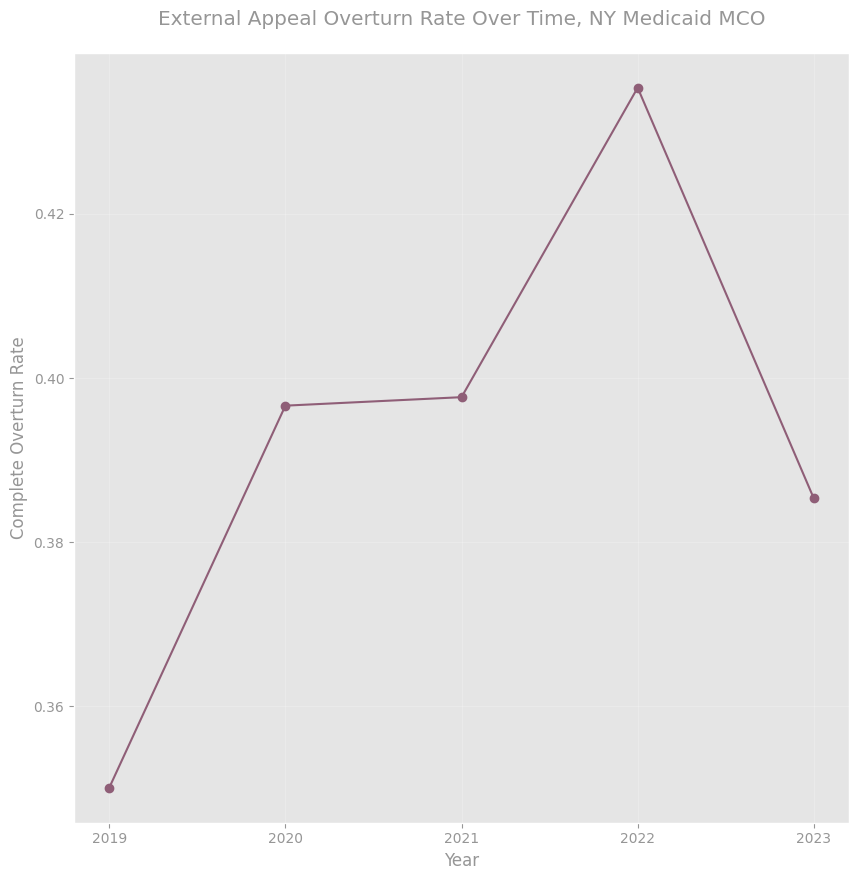

In [112]:
# Plot overall decision rates by year
decision_data = get_overturn_rates_by_category(medicaid_df, "Decision Year")
fig, ax = plt.subplots(figsize=(10, 10))
x = sorted(list(medicaid_df["Decision Year"].unique()))
if not NO_PLOT_TITLES:
    ax.set_title("External Appeal Overturn Rate Over Time, NY Medicaid MCO")
ax.set_ylabel("Complete Overturn Rate")
ax.set_xlabel("Year")
timeseries = []
for year in x:
    if decision_data.get(year, None):
        timeseries.append(decision_data[year]["overall"]["complete_overturn_rate"])
    else:
        timeseries.append(None)
dates = np.asarray(x).astype(str)
ax.plot(dates, timeseries, "o-")
save_path = os.path.join(OUTPUT_IMAGE_DIR, "external_appeal_overturn_rates_by_year_medicaid.png")
plt.savefig(save_path, transparent=True, bbox_inches="tight")
plt.show()